In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import warnings


In [ ]:

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Define the tickers and date range
tickers = [
    'AAPL', 'AIR.PA', 'ALV.DE', 'AMZN', 'ASML.AS', 'BRK-B', 'GOOGL', 'JPM',
    'LIN.DE', 'MC.PA', 'META', 'MSFT', 'NESN.SW', 'NVDA', 'OR.PA',
    'SAP.DE', 'SIE.DE', 'TSLA', 'VOW3.DE', 'V'
]
start_date = '2010-01-01'
end_date = '2025-5-31'
train_end_date = '2024-12-31'
test_start_date = '2025-01-01'

# Dictionary to store historical data and predictions
stock_data = {}
lstm_predictions = {}
lstm_metrics = {}


In [ ]:

# Download daily historical stock price data
print("Downloading historical stock data...")
for ticker in tickers:
    try:
        data = yf.download(ticker, start=start_date, end=end_date, progress=False)
        if not data.empty:
            stock_data[ticker] = data['Close'].dropna()
            print(f"Successfully downloaded data for {ticker}. Rows: {len(stock_data[ticker])}")
        else:
            print(f"No data downloaded for {ticker}. Skipping.")
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")

print("\n--- Data Download Complete ---")

In [ ]:

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)


In [ ]:

# Build LSTM model with the exact same architecture
def build_lstm_model(sequence_length):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

Successfully downloaded data for AAPL. Rows: 3876
Successfully downloaded data for AIR.PA. Rows: 3943
Successfully downloaded data for ALV.DE. Rows: 3915
Successfully downloaded data for AMZN. Rows: 3876
Successfully downloaded data for ASML.AS. Rows: 3944
Successfully downloaded data for BRK-B. Rows: 3876
Successfully downloaded data for GOOGL. Rows: 3876
Successfully downloaded data for JPM. Rows: 3876
Successfully downloaded data for LIN.DE. Rows: 3915
Successfully downloaded data for MC.PA. Rows: 3943
Successfully downloaded data for META. Rows: 3277
Successfully downloaded data for MSFT. Rows: 3876
Successfully downloaded data for NESN.SW. Rows: 3873
Successfully downloaded data for NVDA. Rows: 3876
Successfully downloaded data for OR.PA. Rows: 3943
Successfully downloaded data for SAP.DE. Rows: 3915
Successfully downloaded data for SIE.DE. Rows: 3915
Successfully downloaded data for TSLA. Rows: 3754
Successfully downloaded data for VOW3.DE. Rows: 3915
Successfully downloaded data

  LSTM RMSE: 7.87
  Predictions generated: 44

Processing AMZN...
  Train data points: 3774
  Test data points: 102
  Scaled train shape: (3774, 1)
  Scaled test shape: (102, 1)
  X_train shape before reshape: (3714, 60)
  X_test shape before reshape: (42, 60)
  X_train shape after reshape: (3714, 60, 1)
  X_test shape after reshape: (42, 60, 1)
  Training LSTM for AMZN...
  Making predictions...
  LSTM RMSE: 8.10
  Predictions generated: 42

Processing ASML.AS...
  Train data points: 3840
  Test data points: 104
  Scaled train shape: (3840, 1)
  Scaled test shape: (104, 1)
  X_train shape before reshape: (3780, 60)
  X_test shape before reshape: (44, 60)
  X_train shape after reshape: (3780, 60, 1)
  X_test shape after reshape: (44, 60, 1)
  Training LSTM for ASML.AS...
  Making predictions...
  LSTM RMSE: 29.83
  Predictions generated: 44

Processing BRK-B...
  Train data points: 3774
  Test data points: 102
  Scaled train shape: (3774, 1)
  Scaled test shape: (102, 1)
  X_train shap

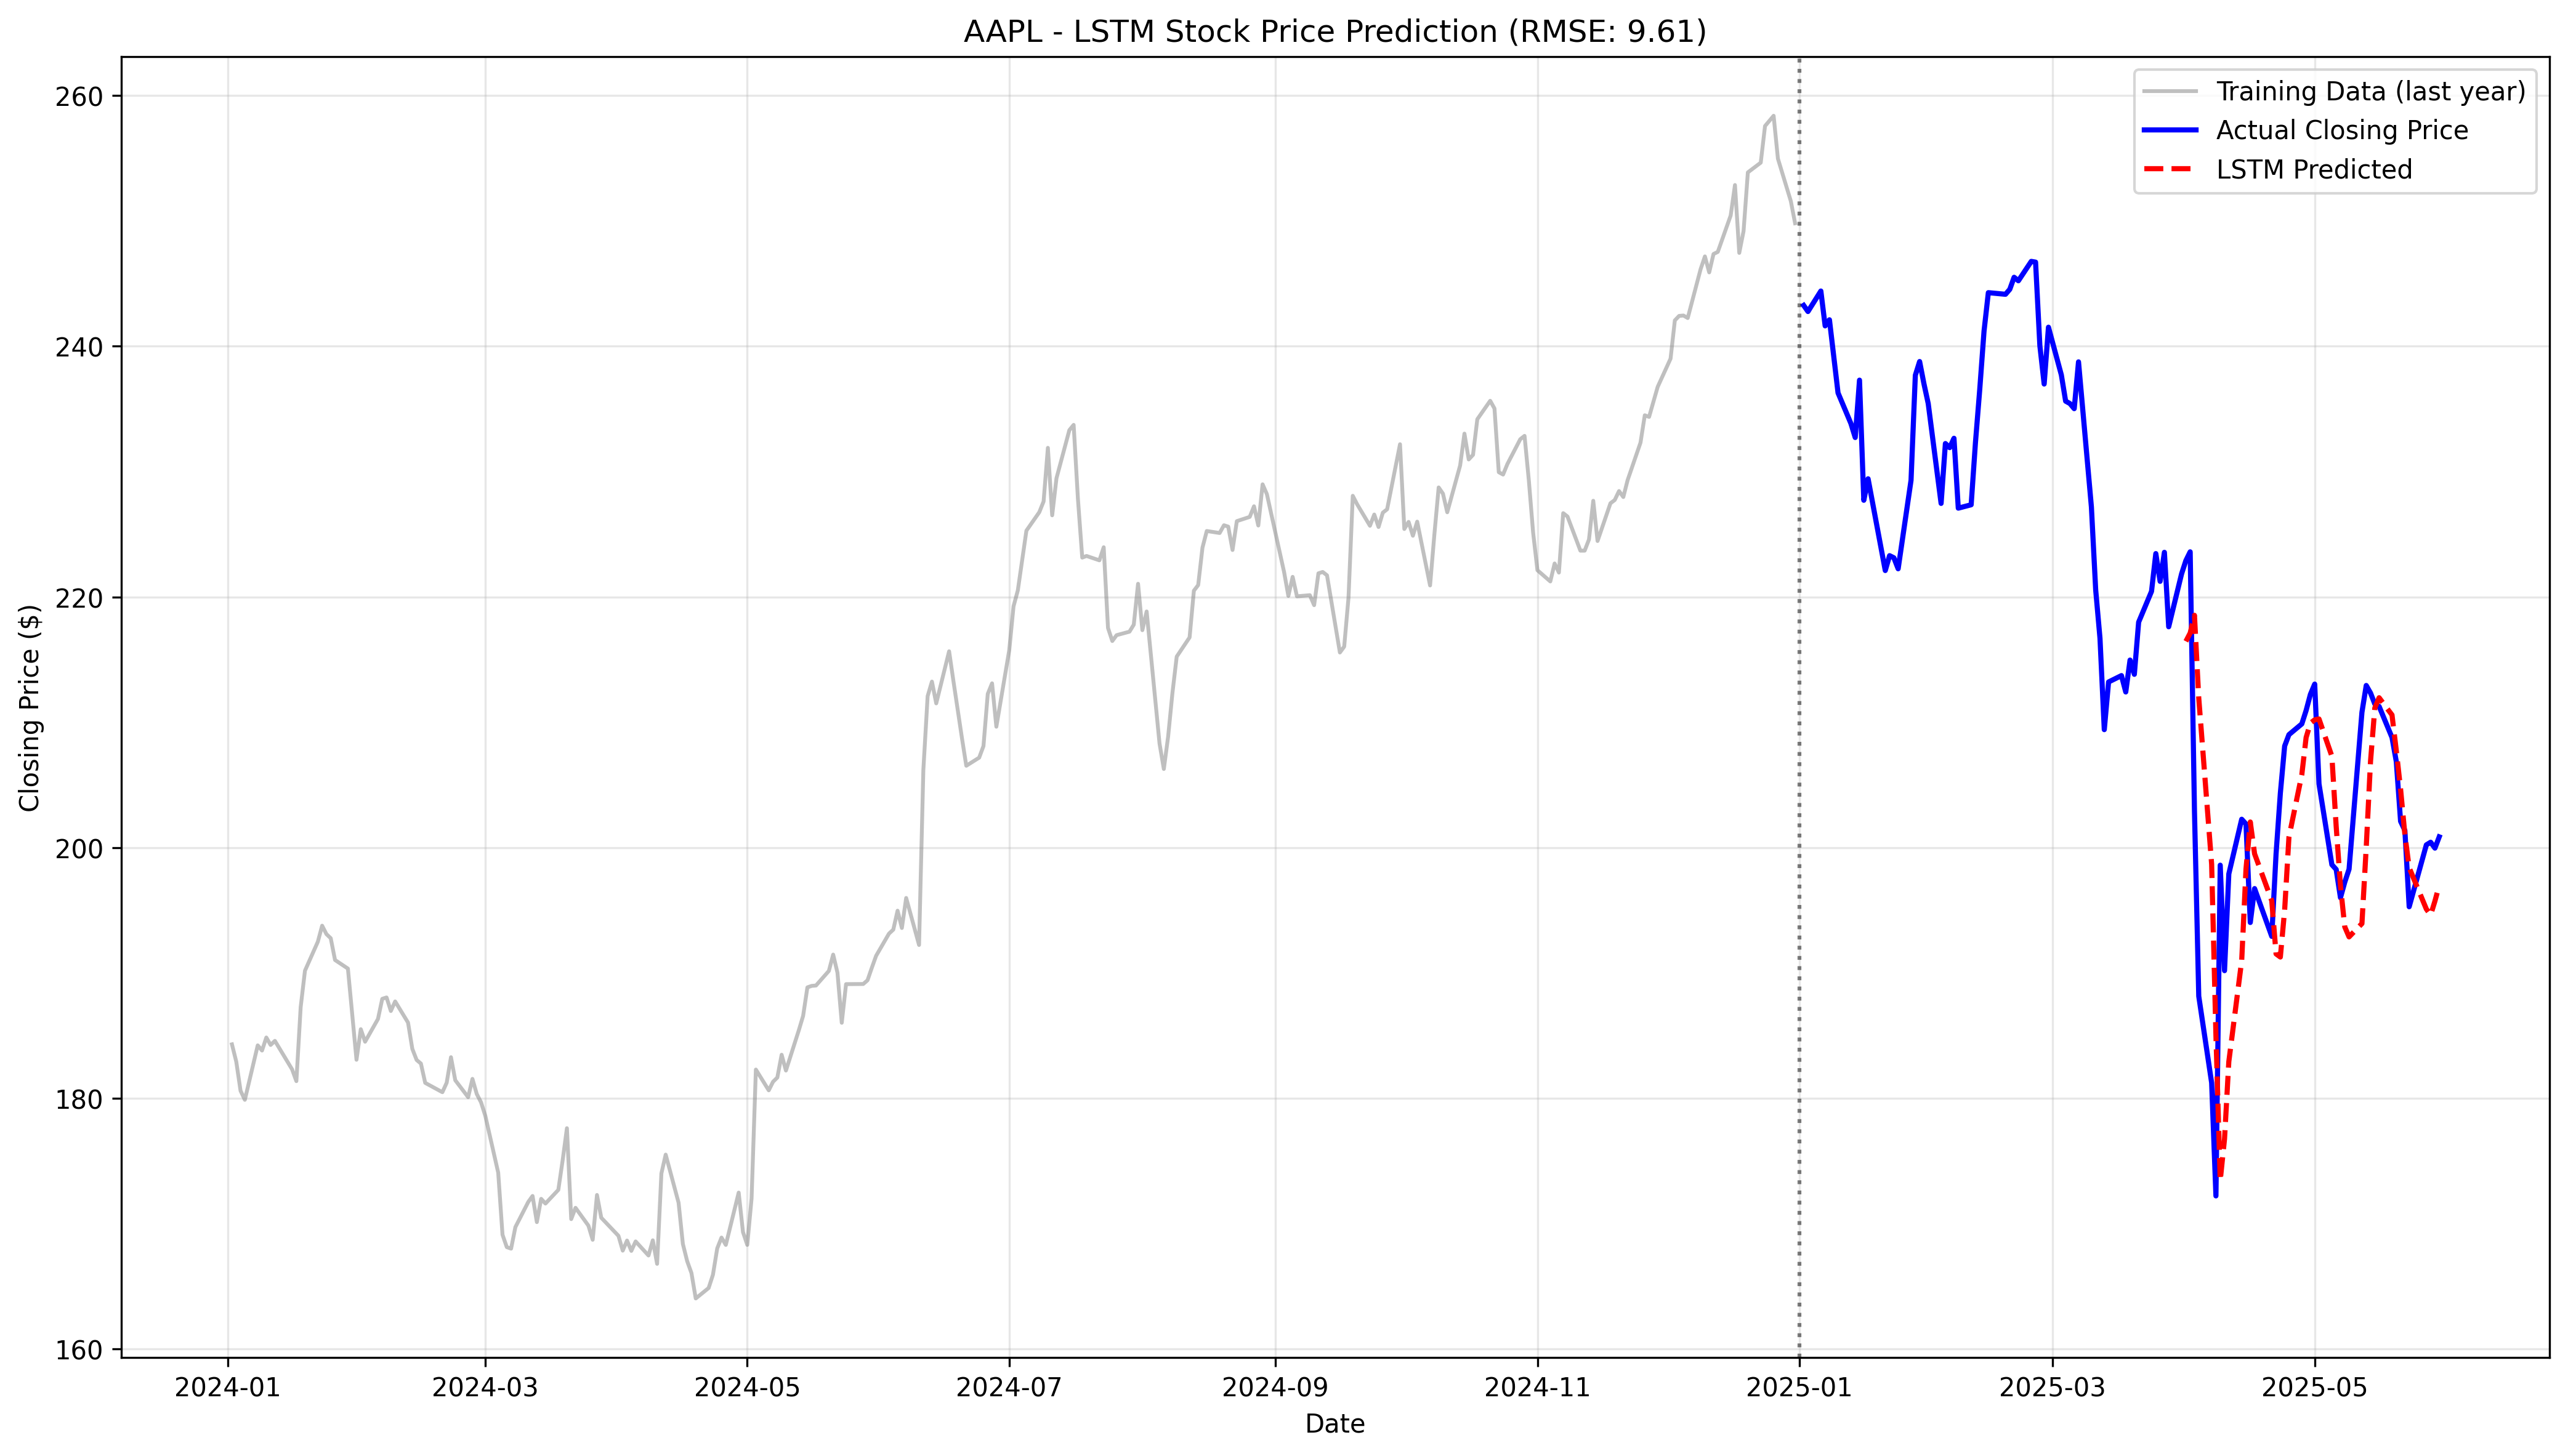

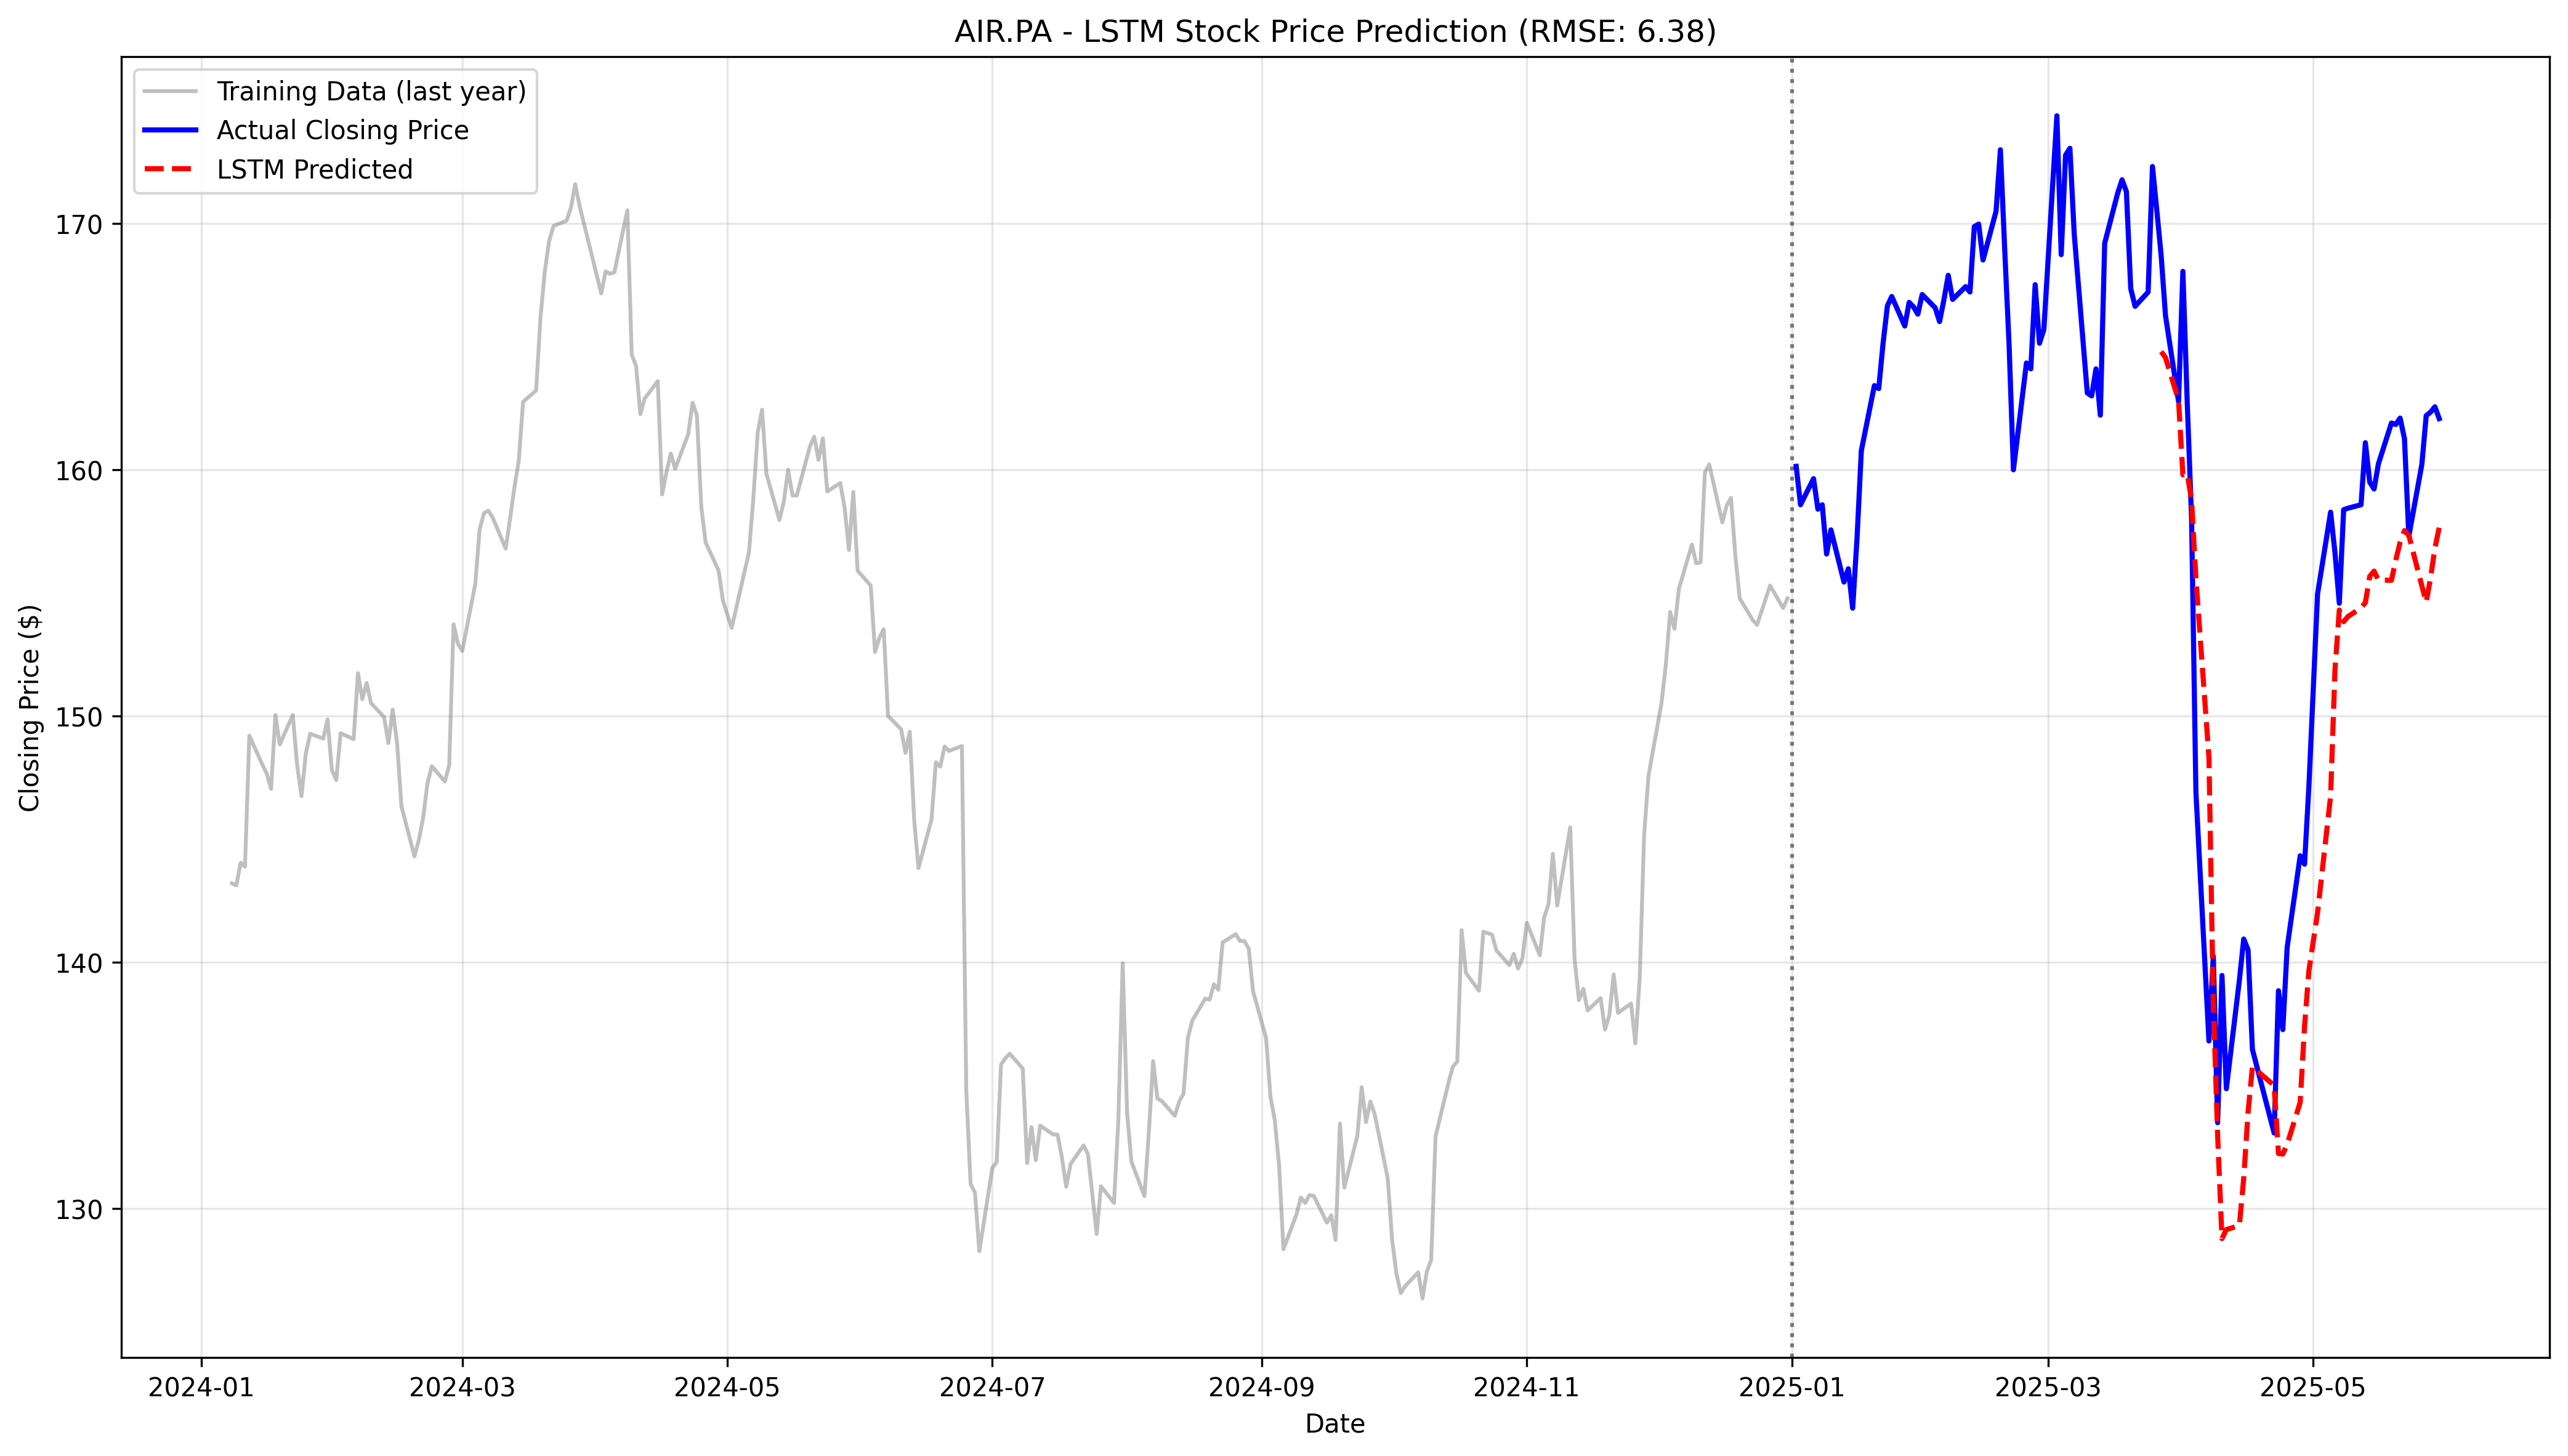

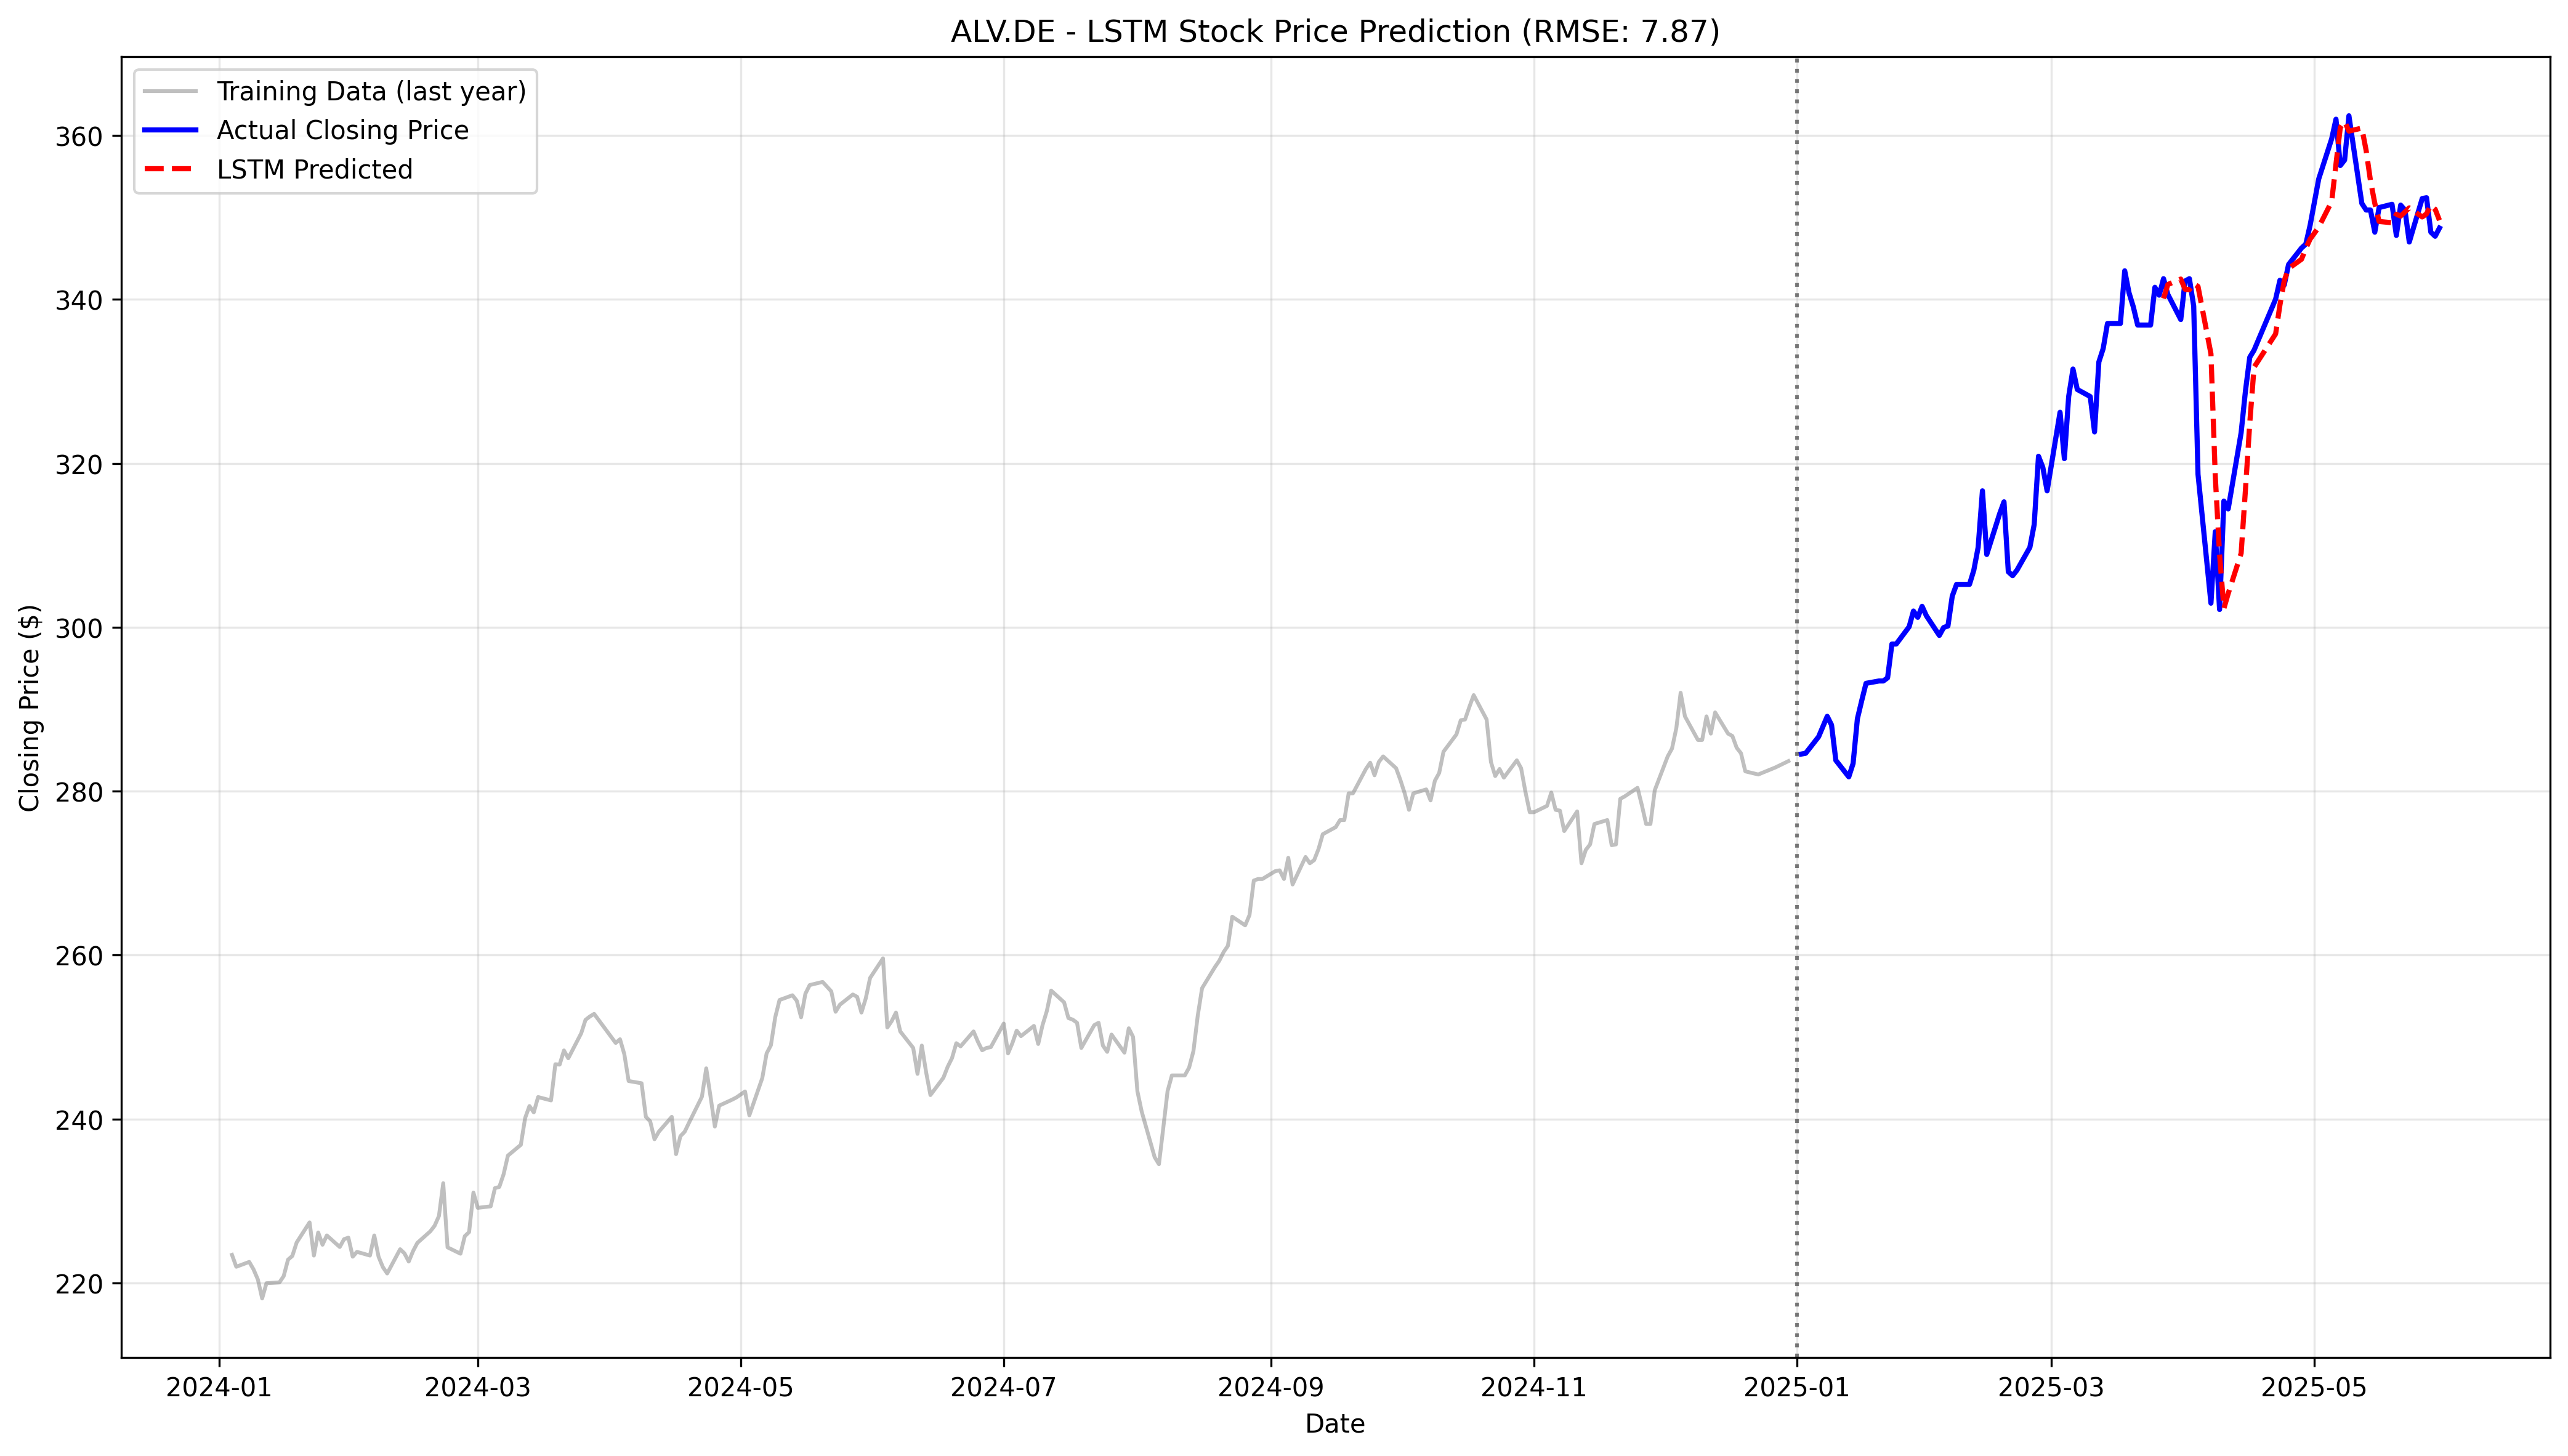

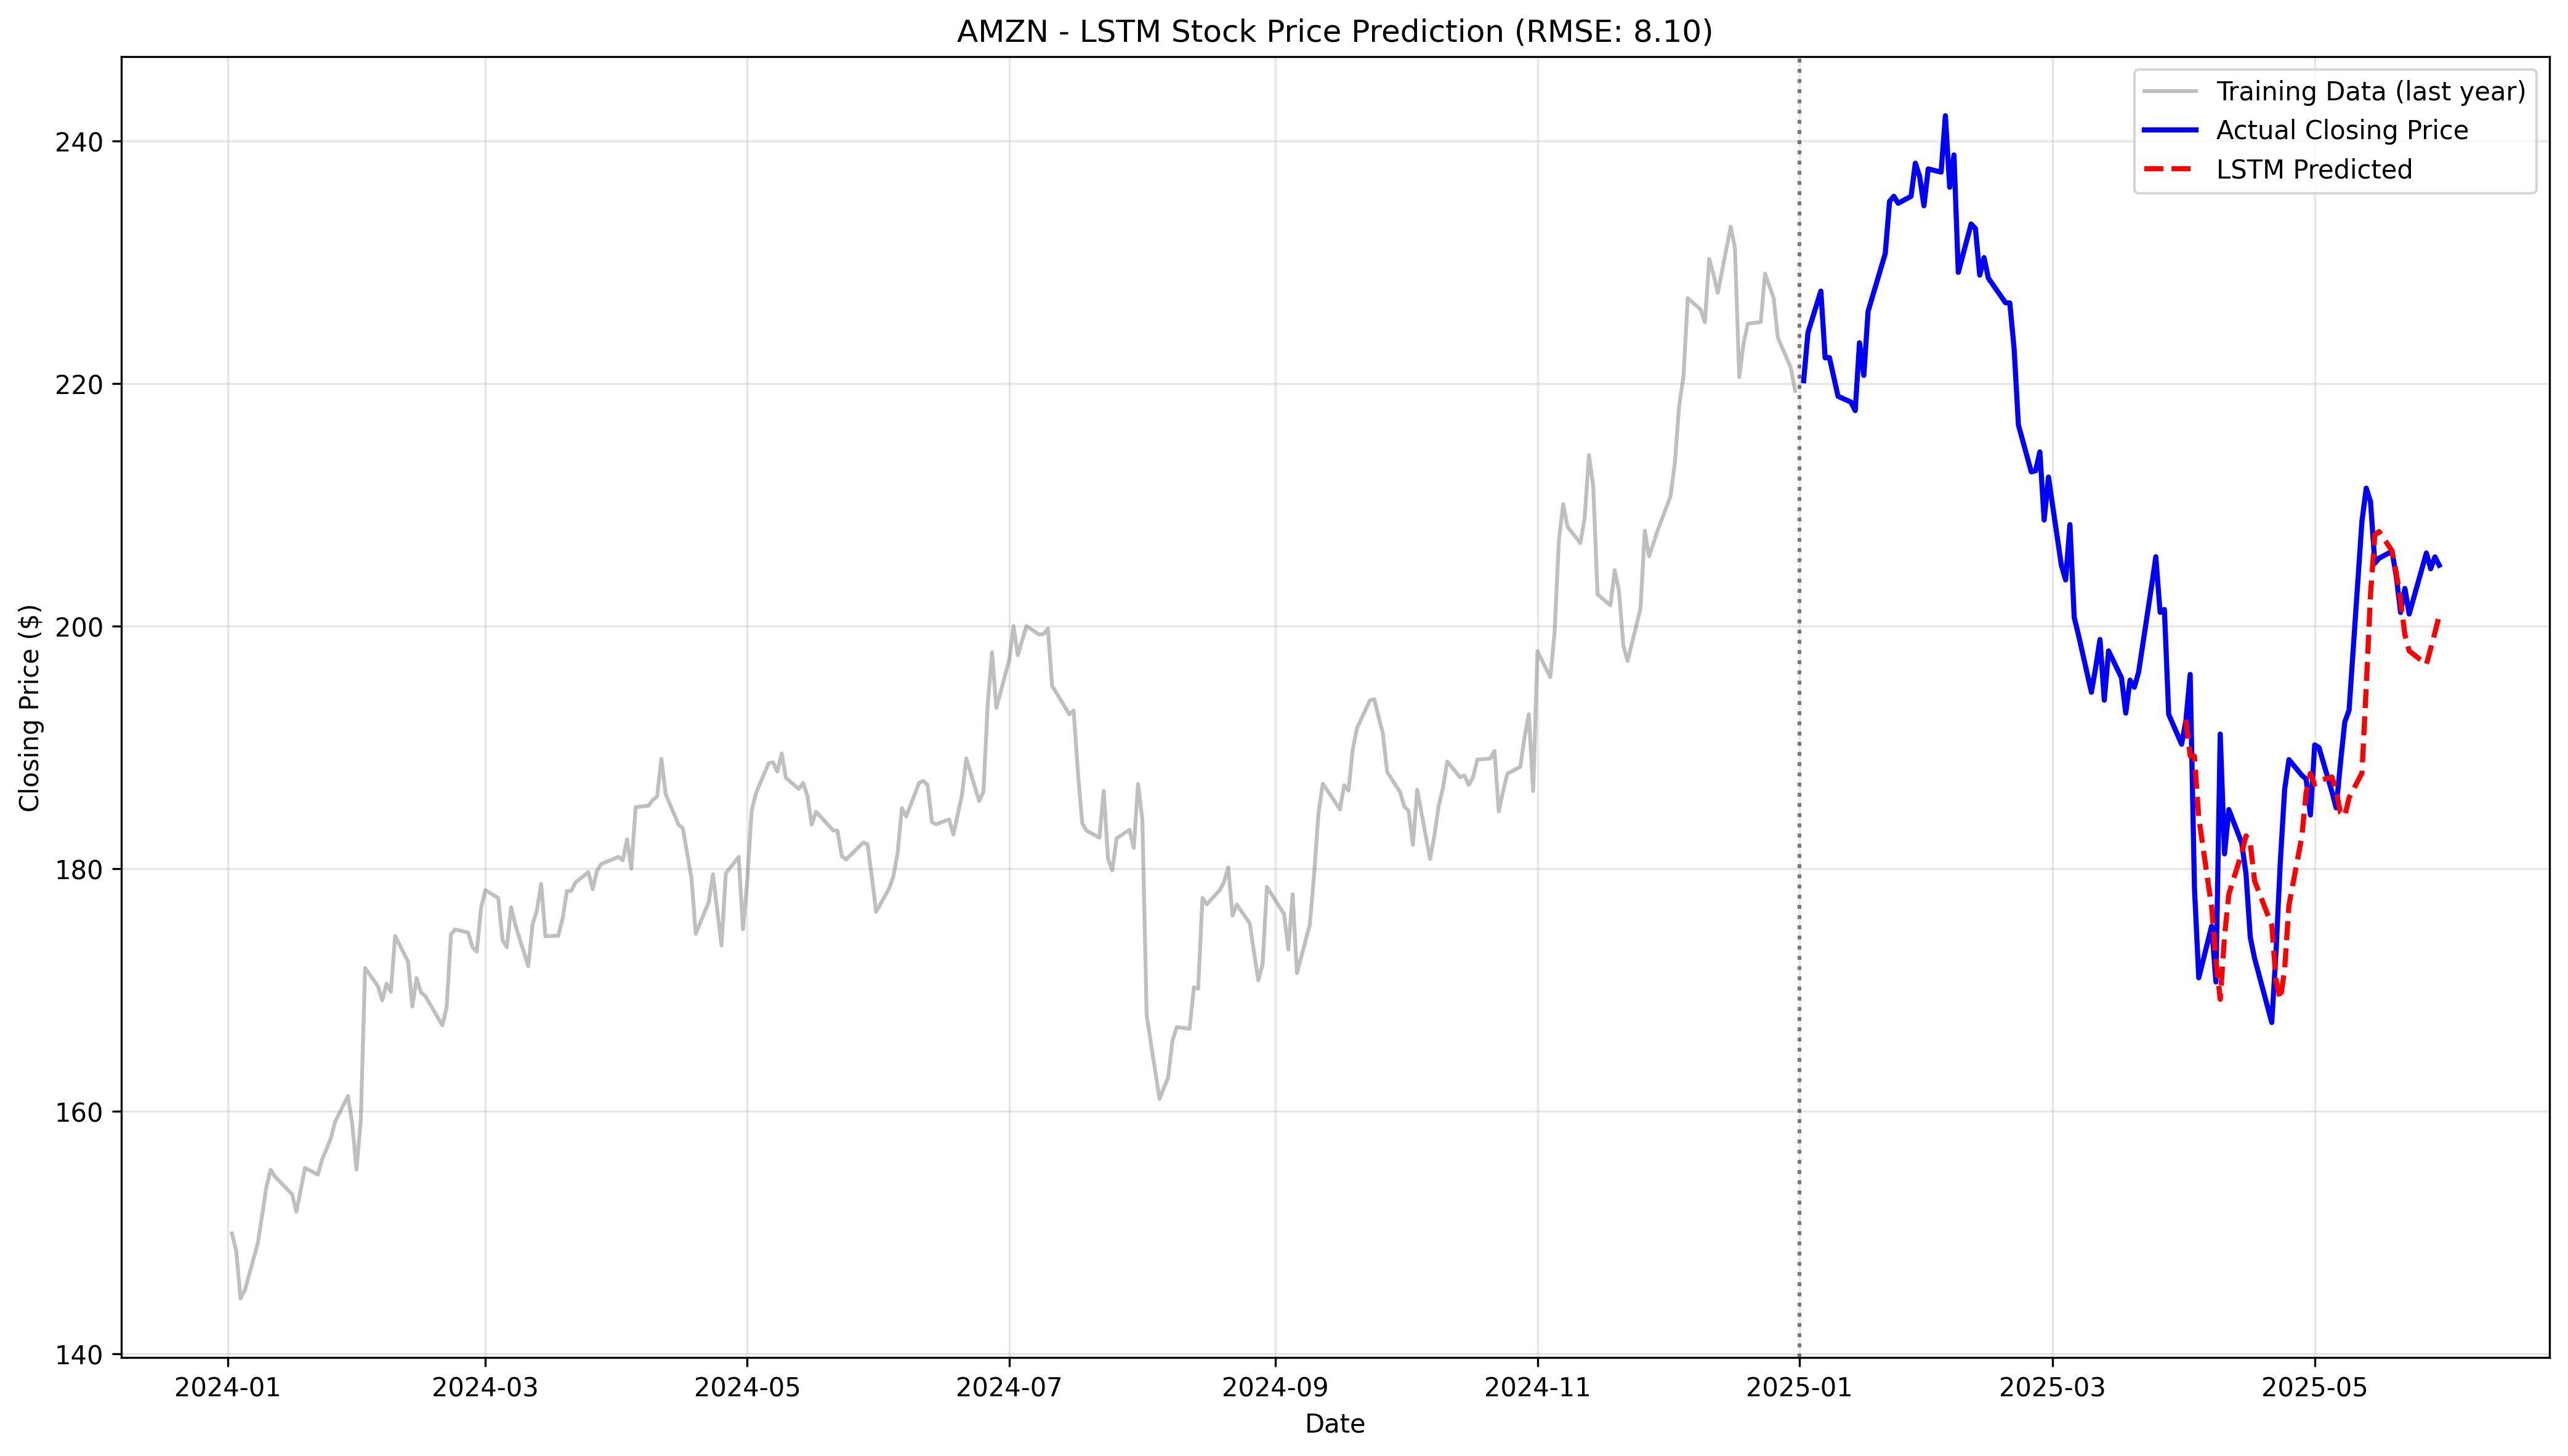

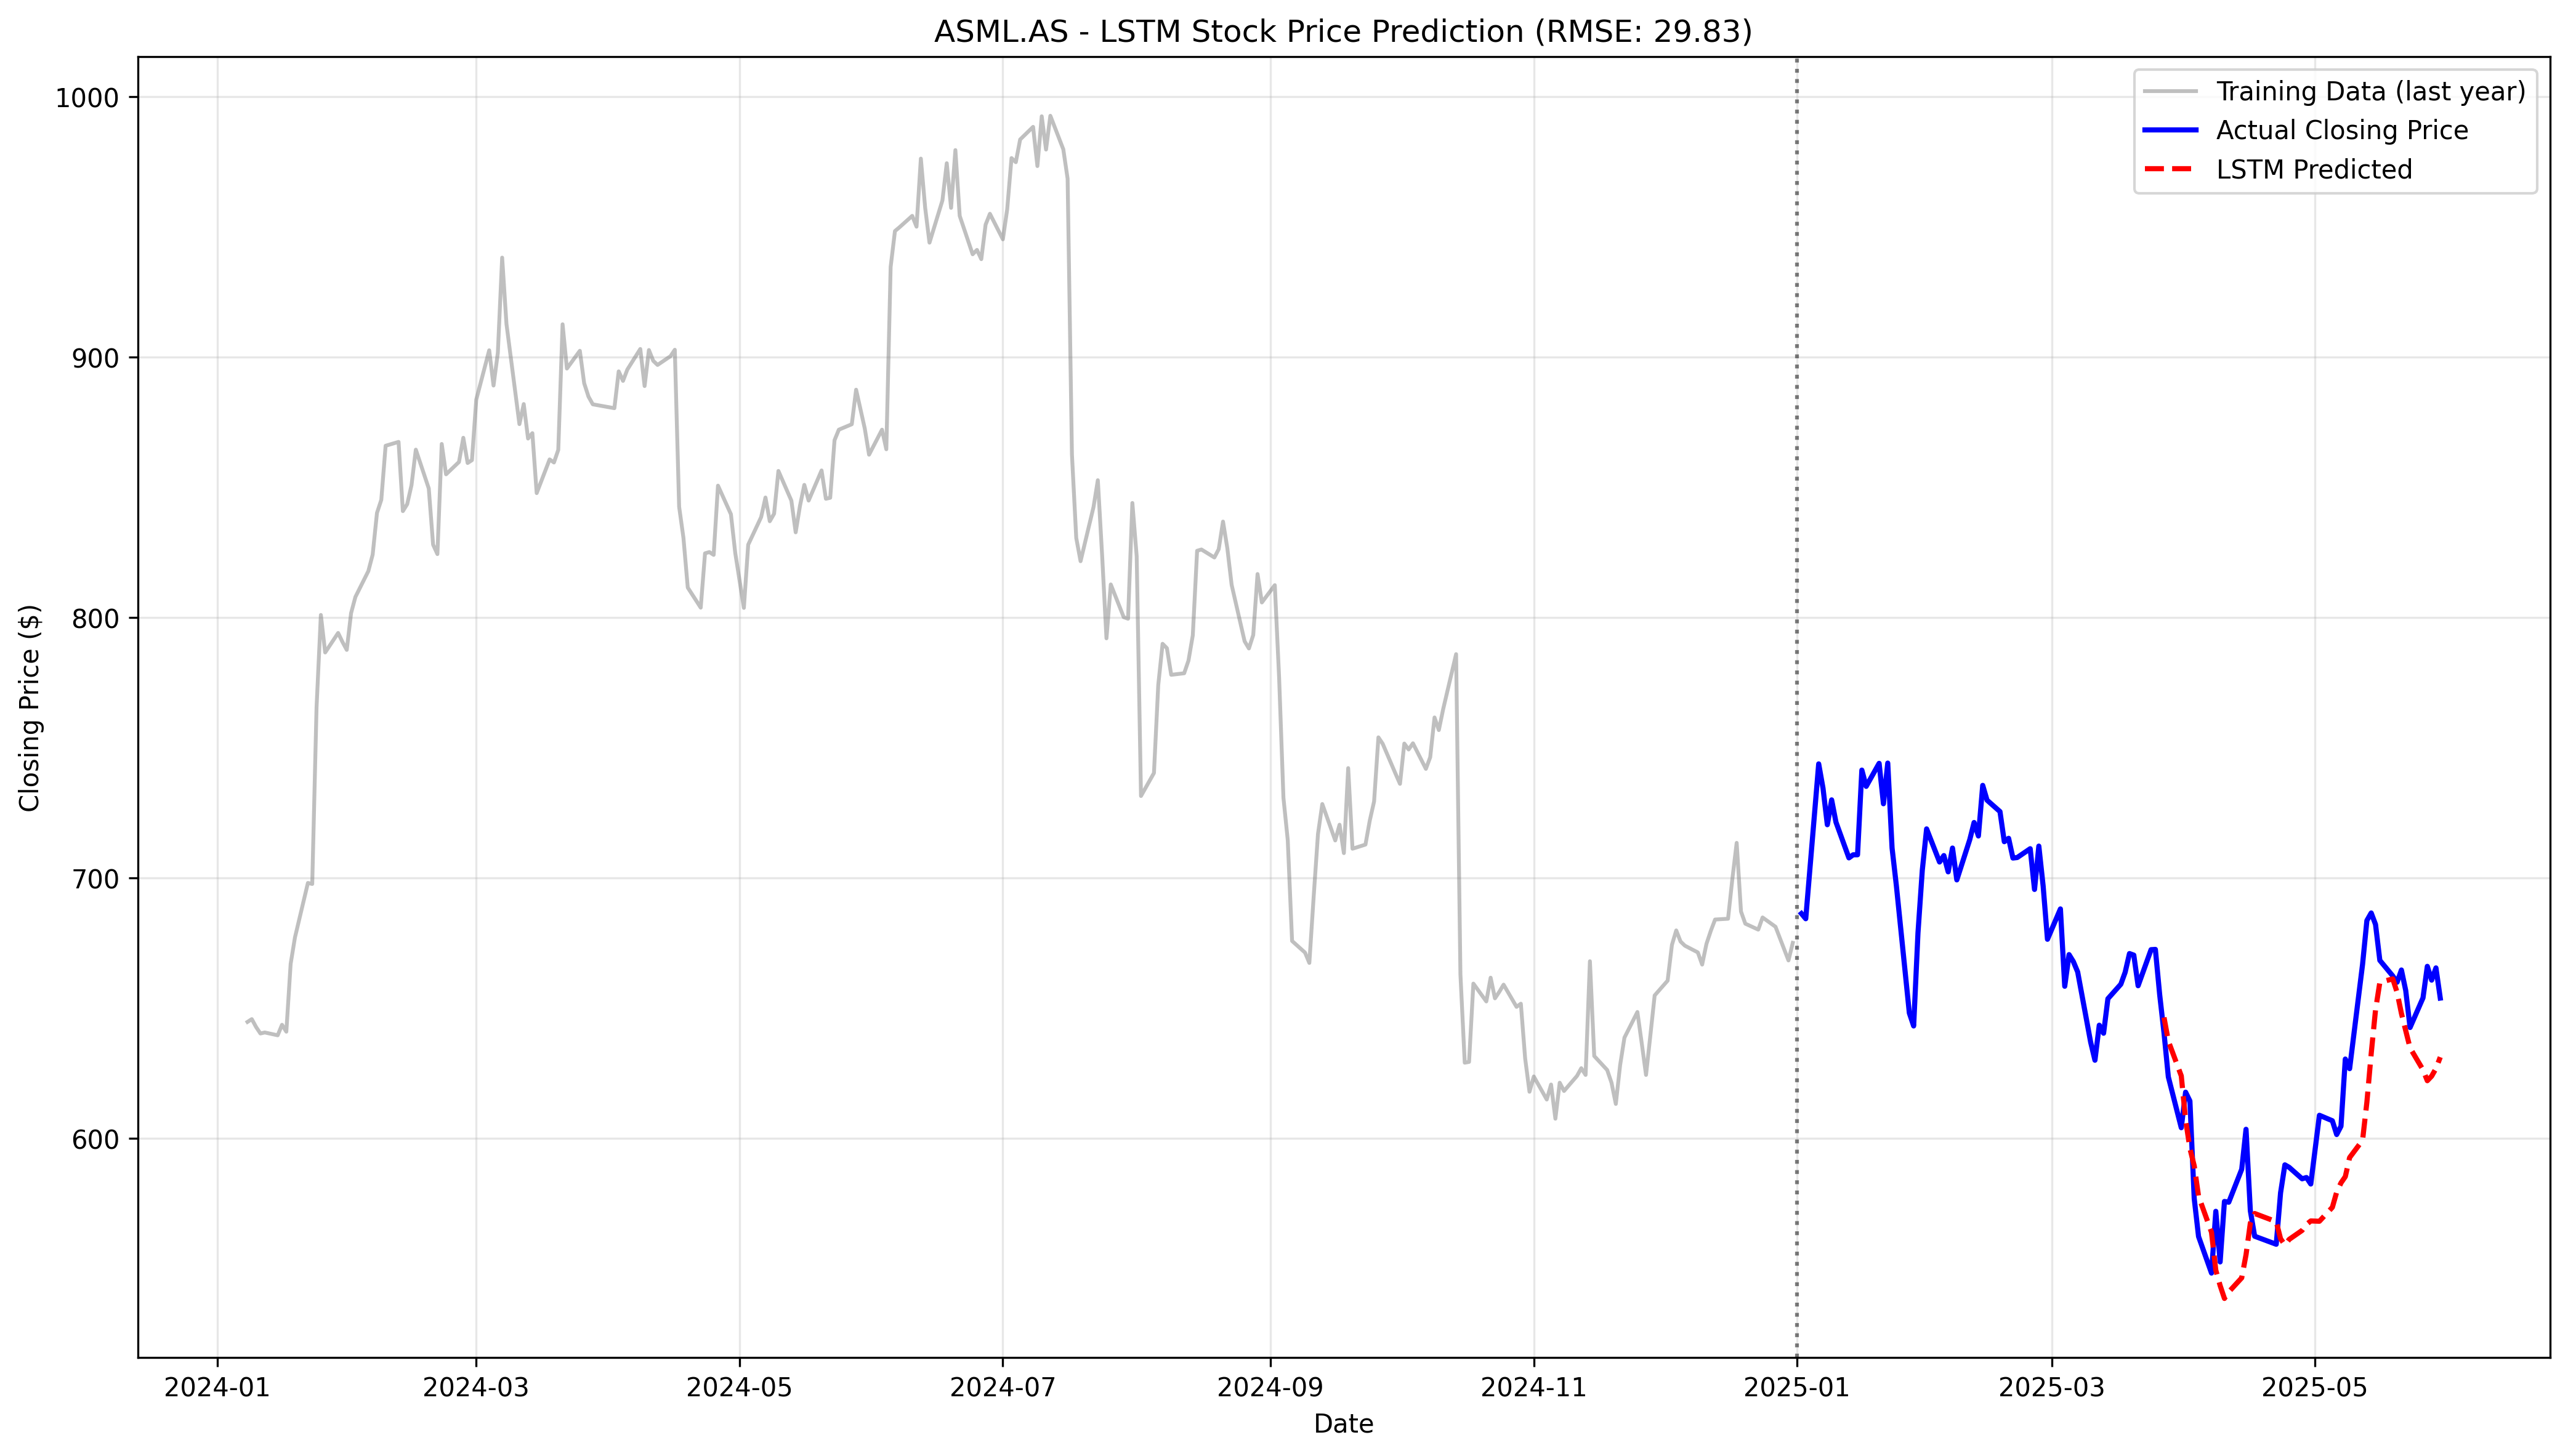

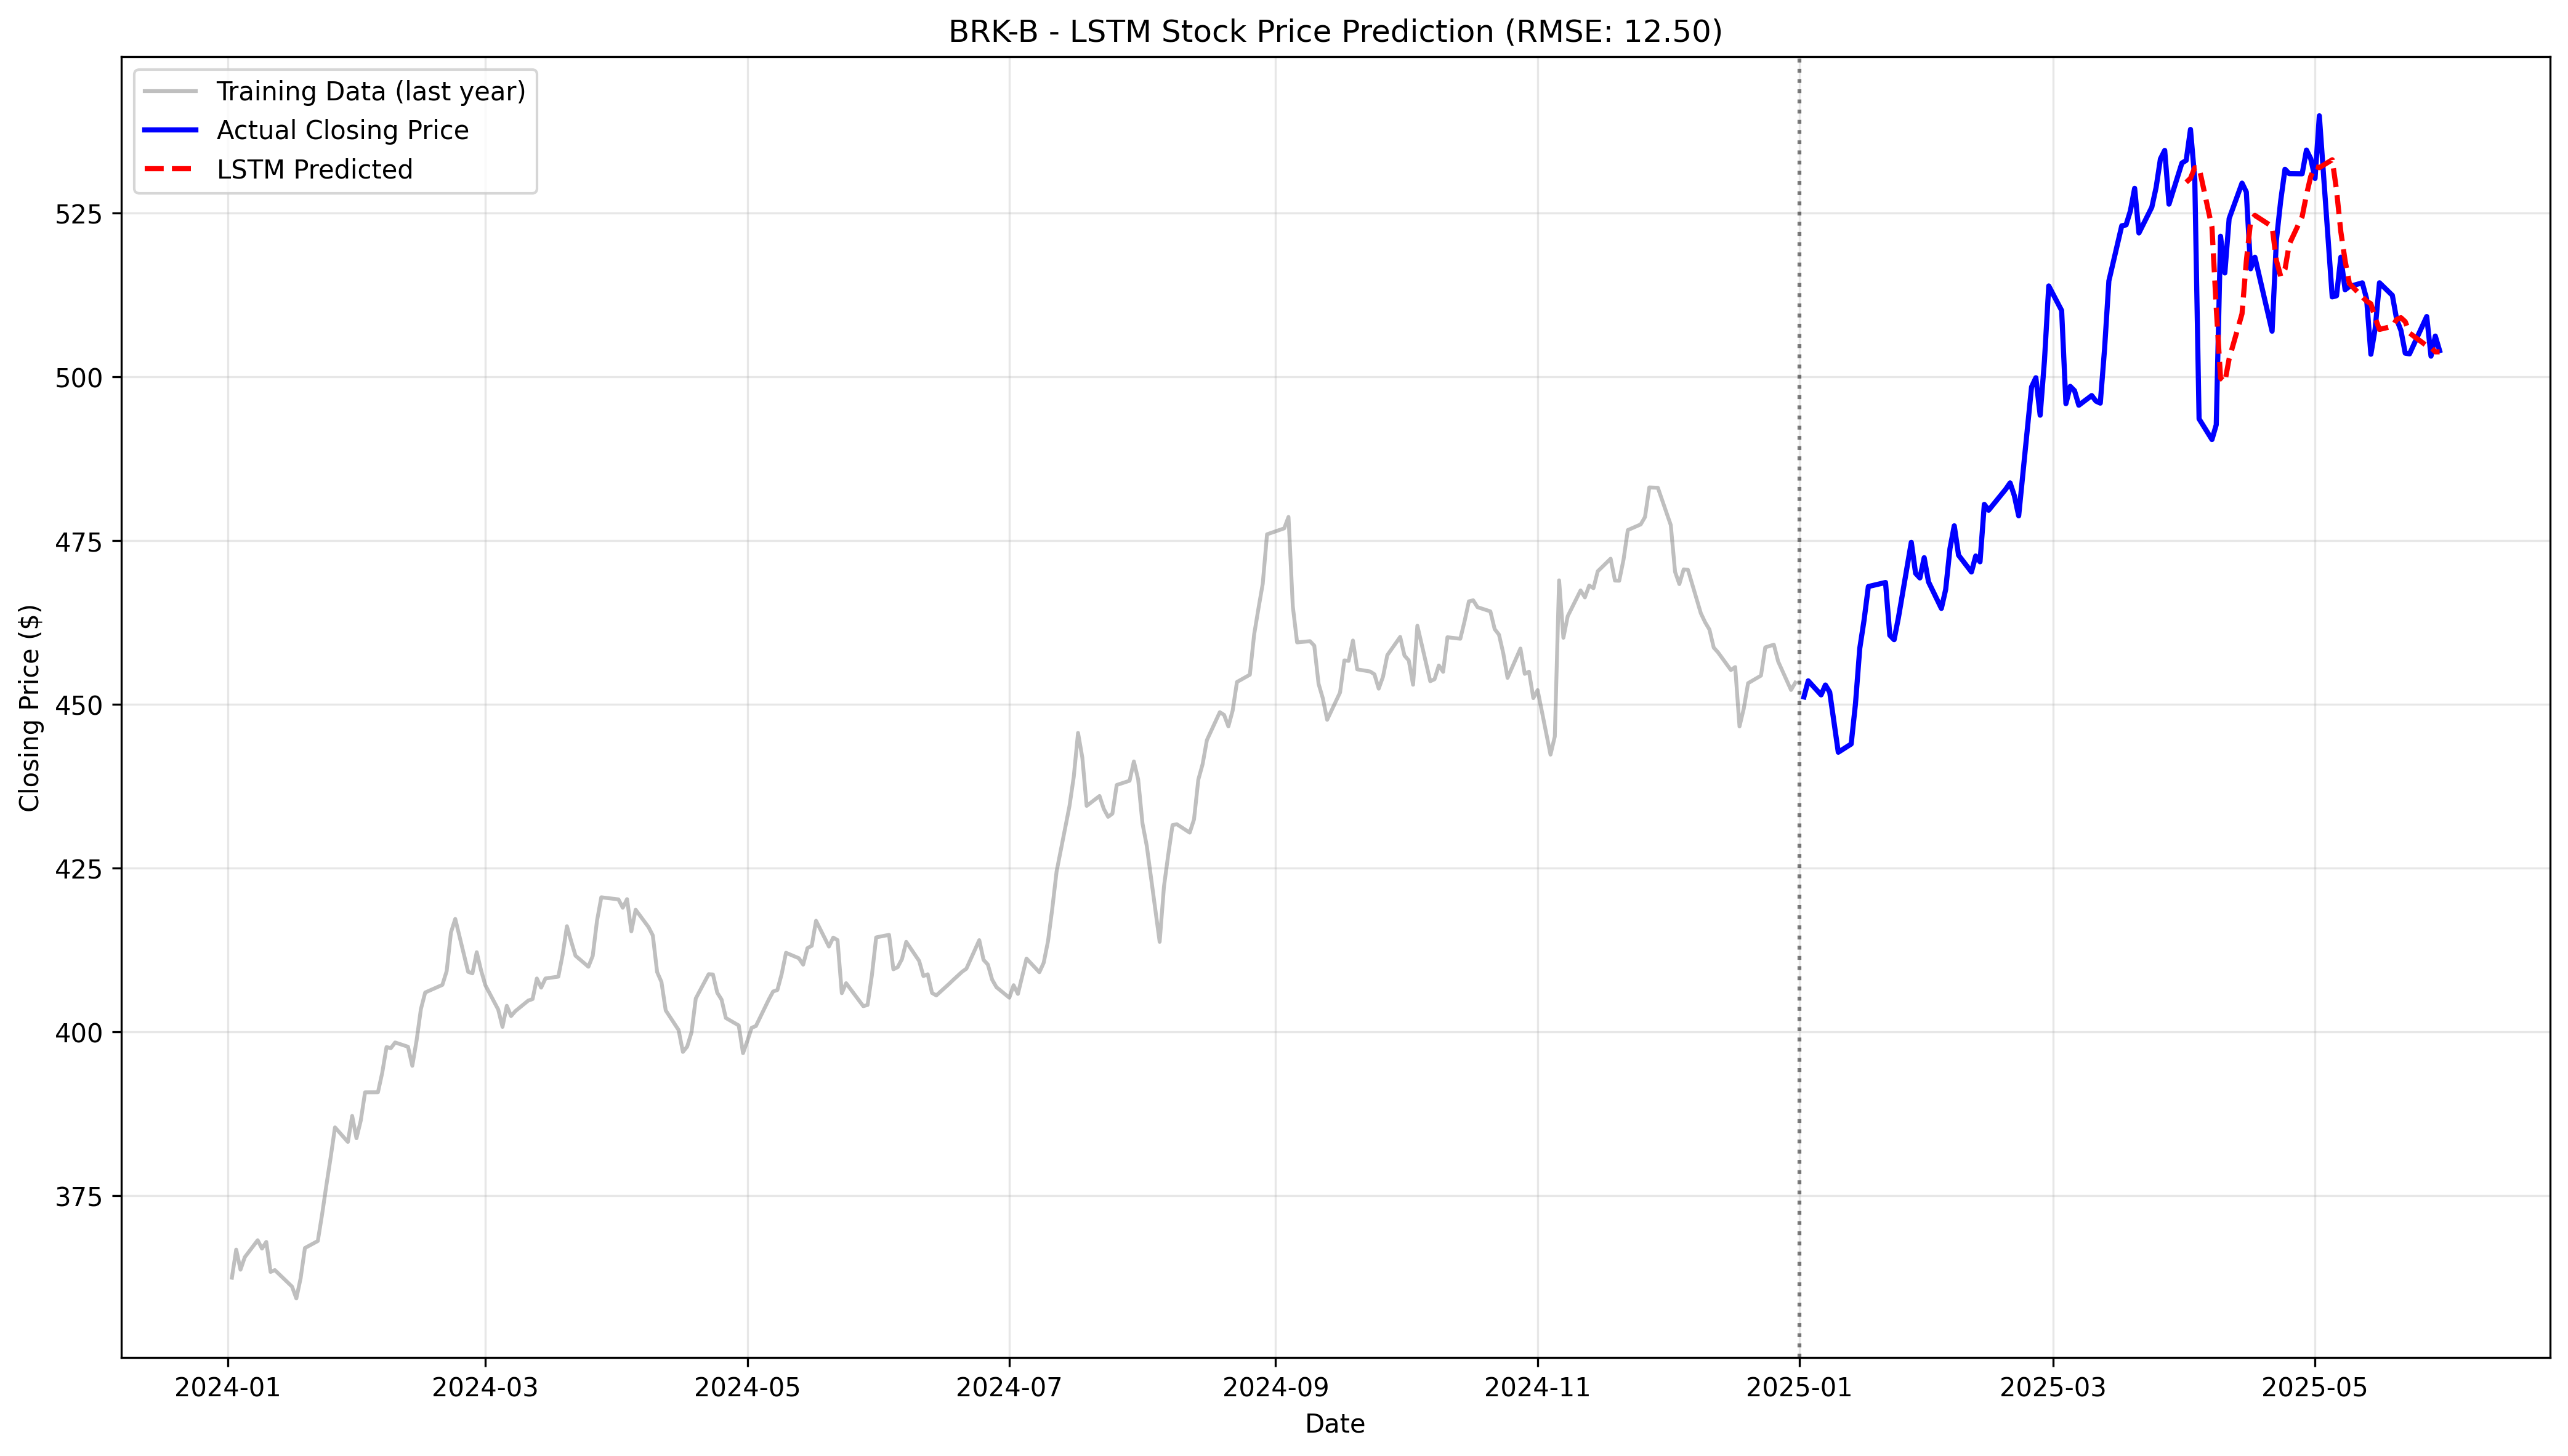

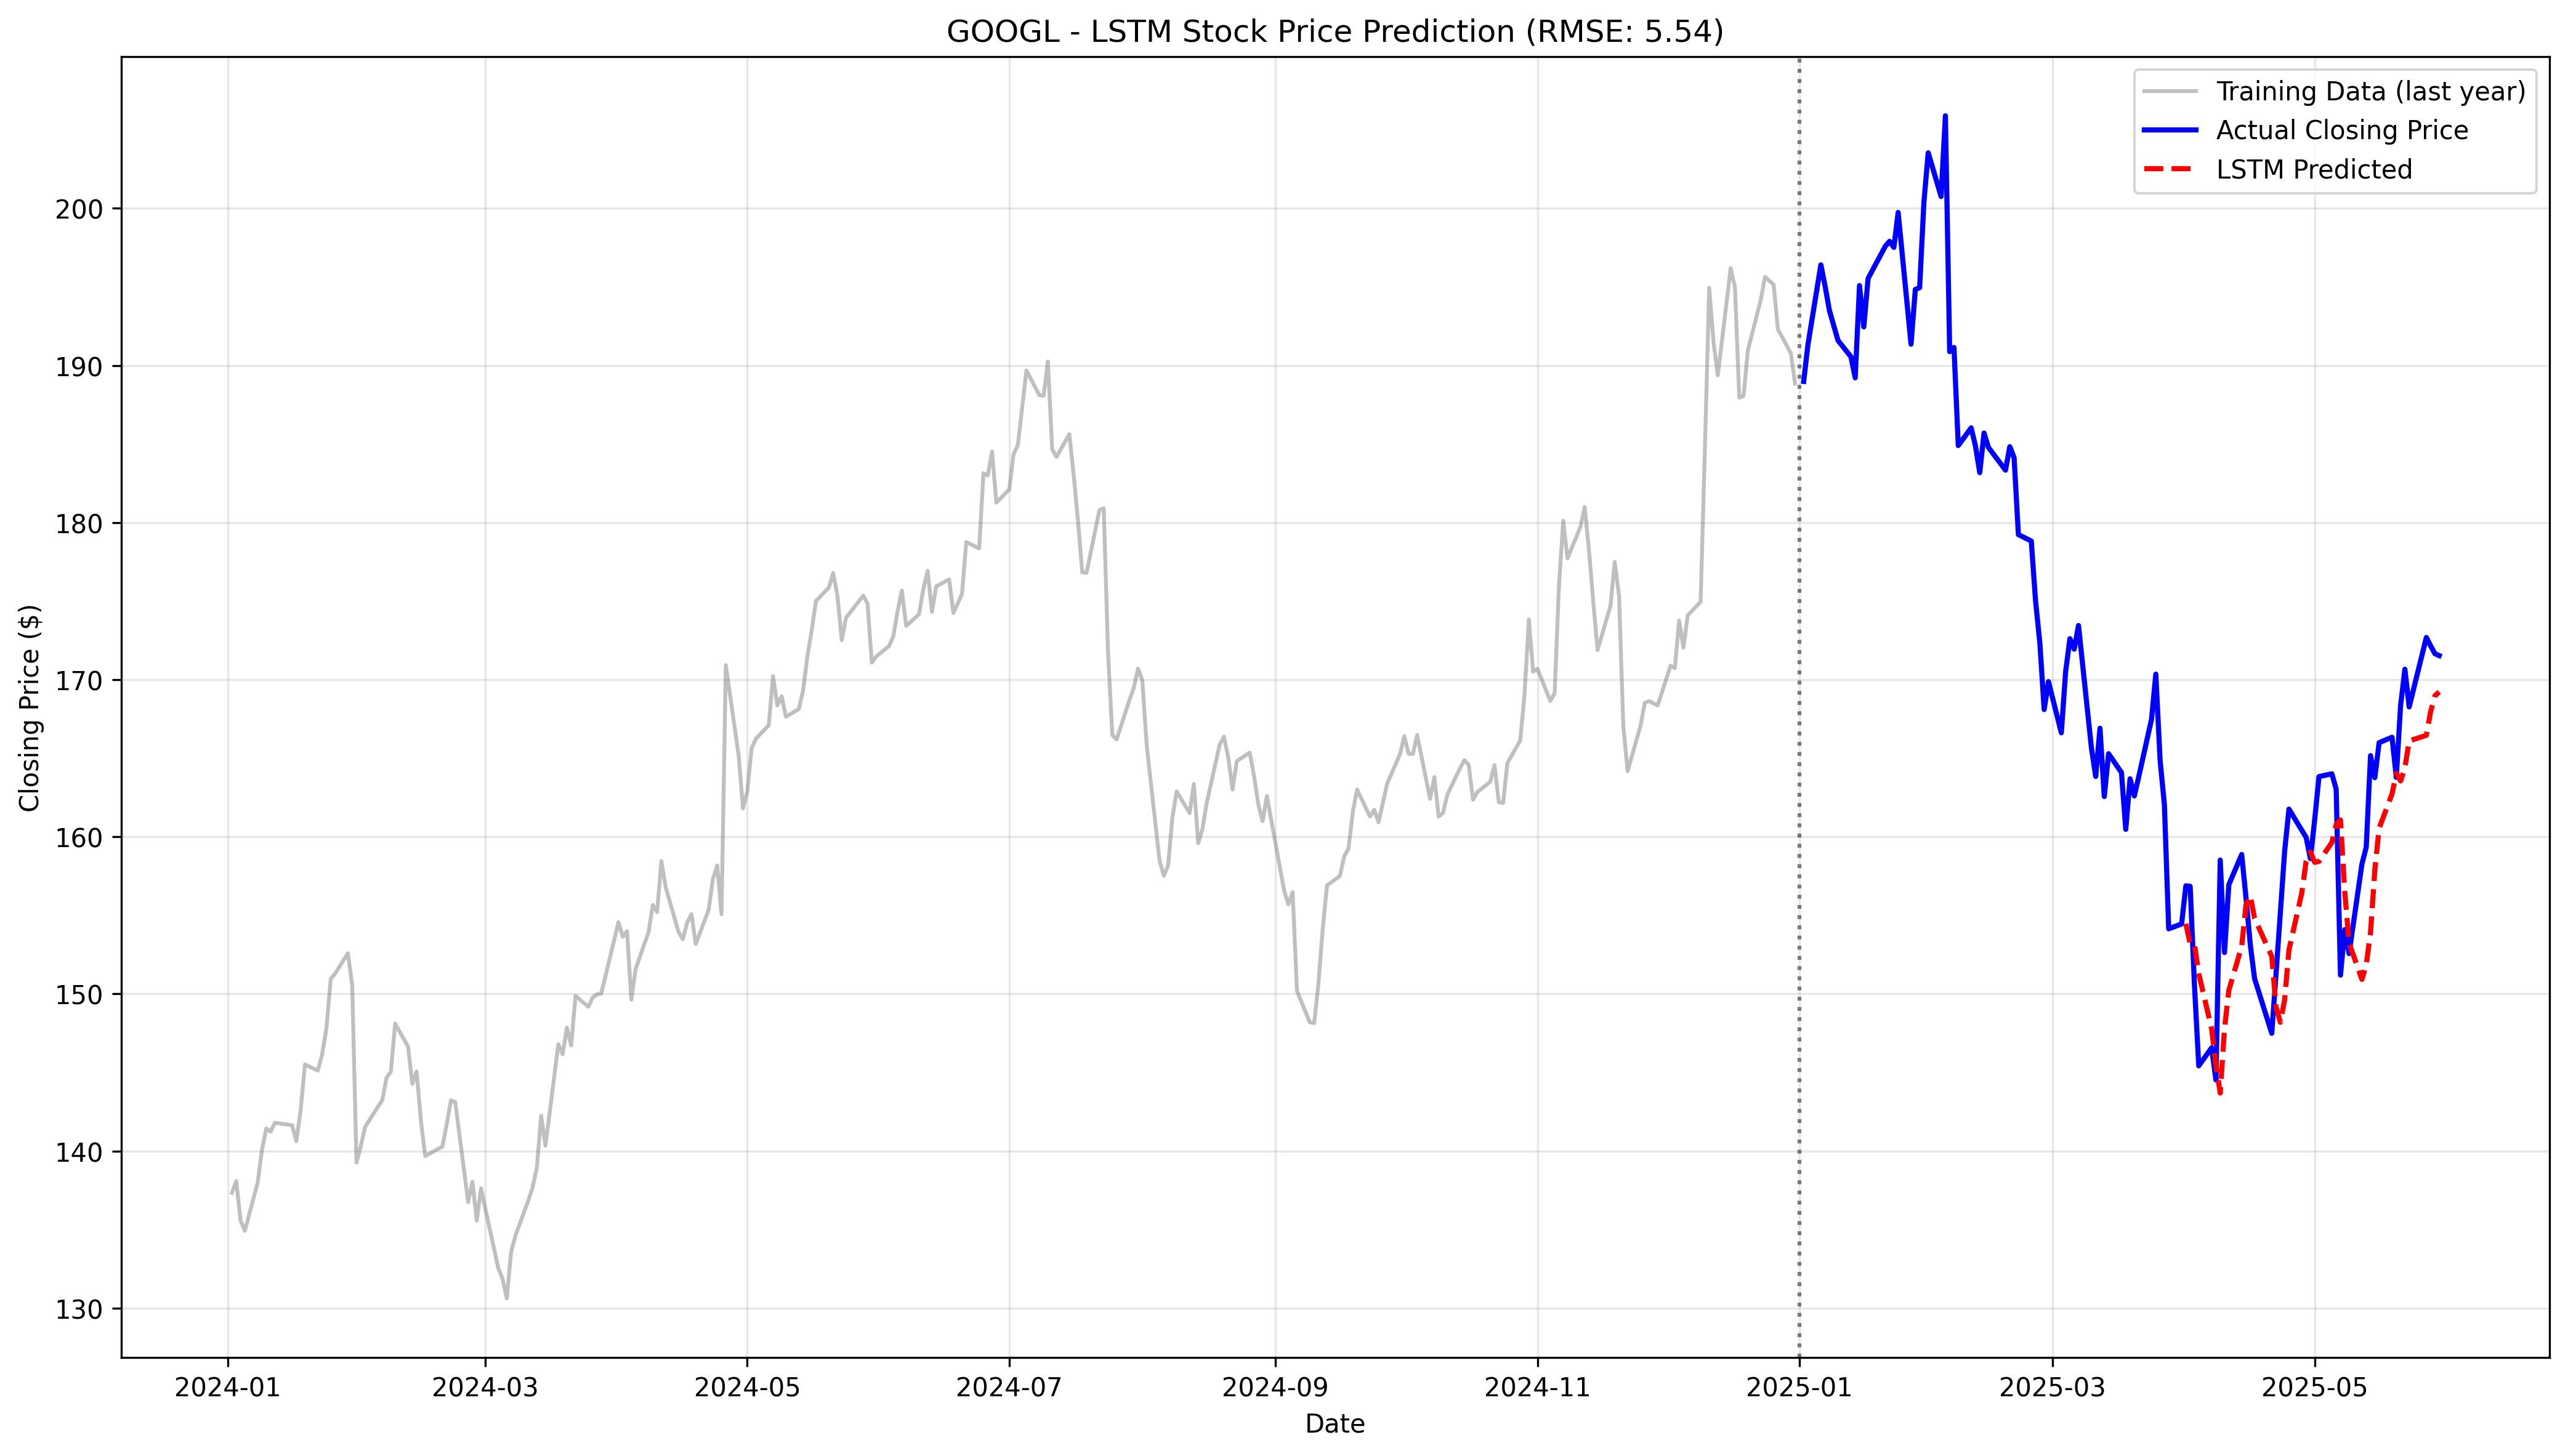

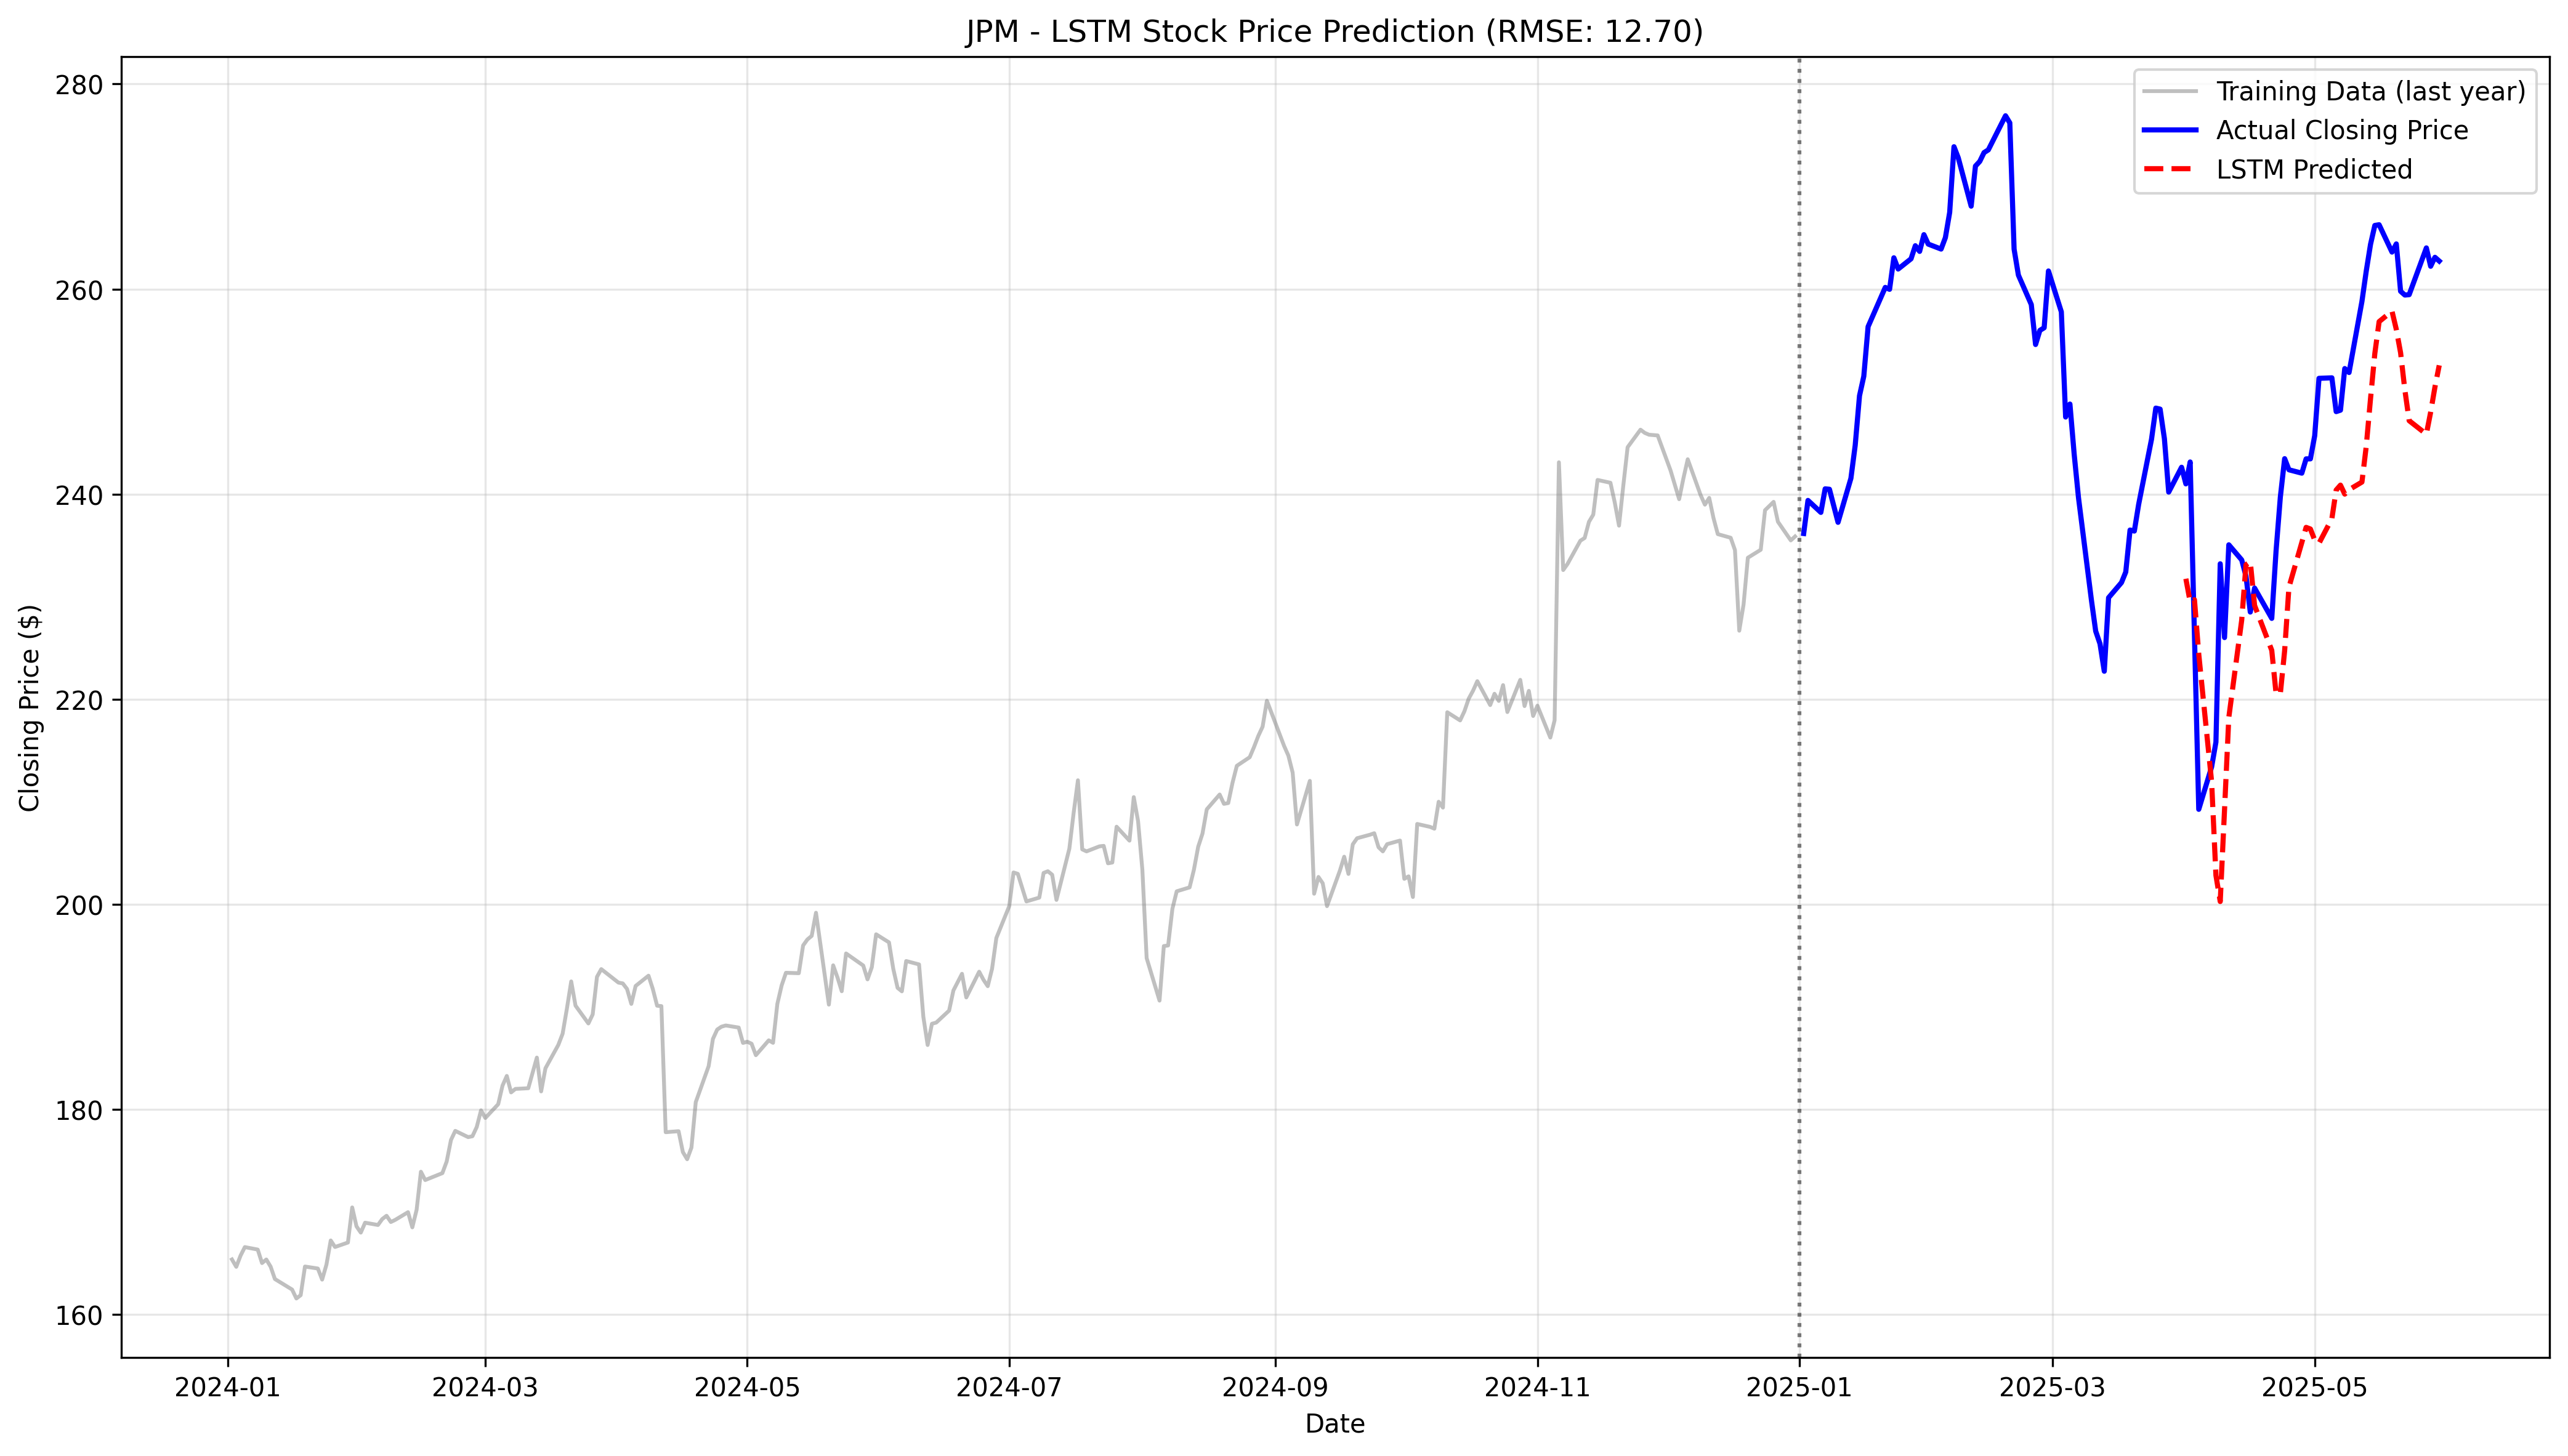

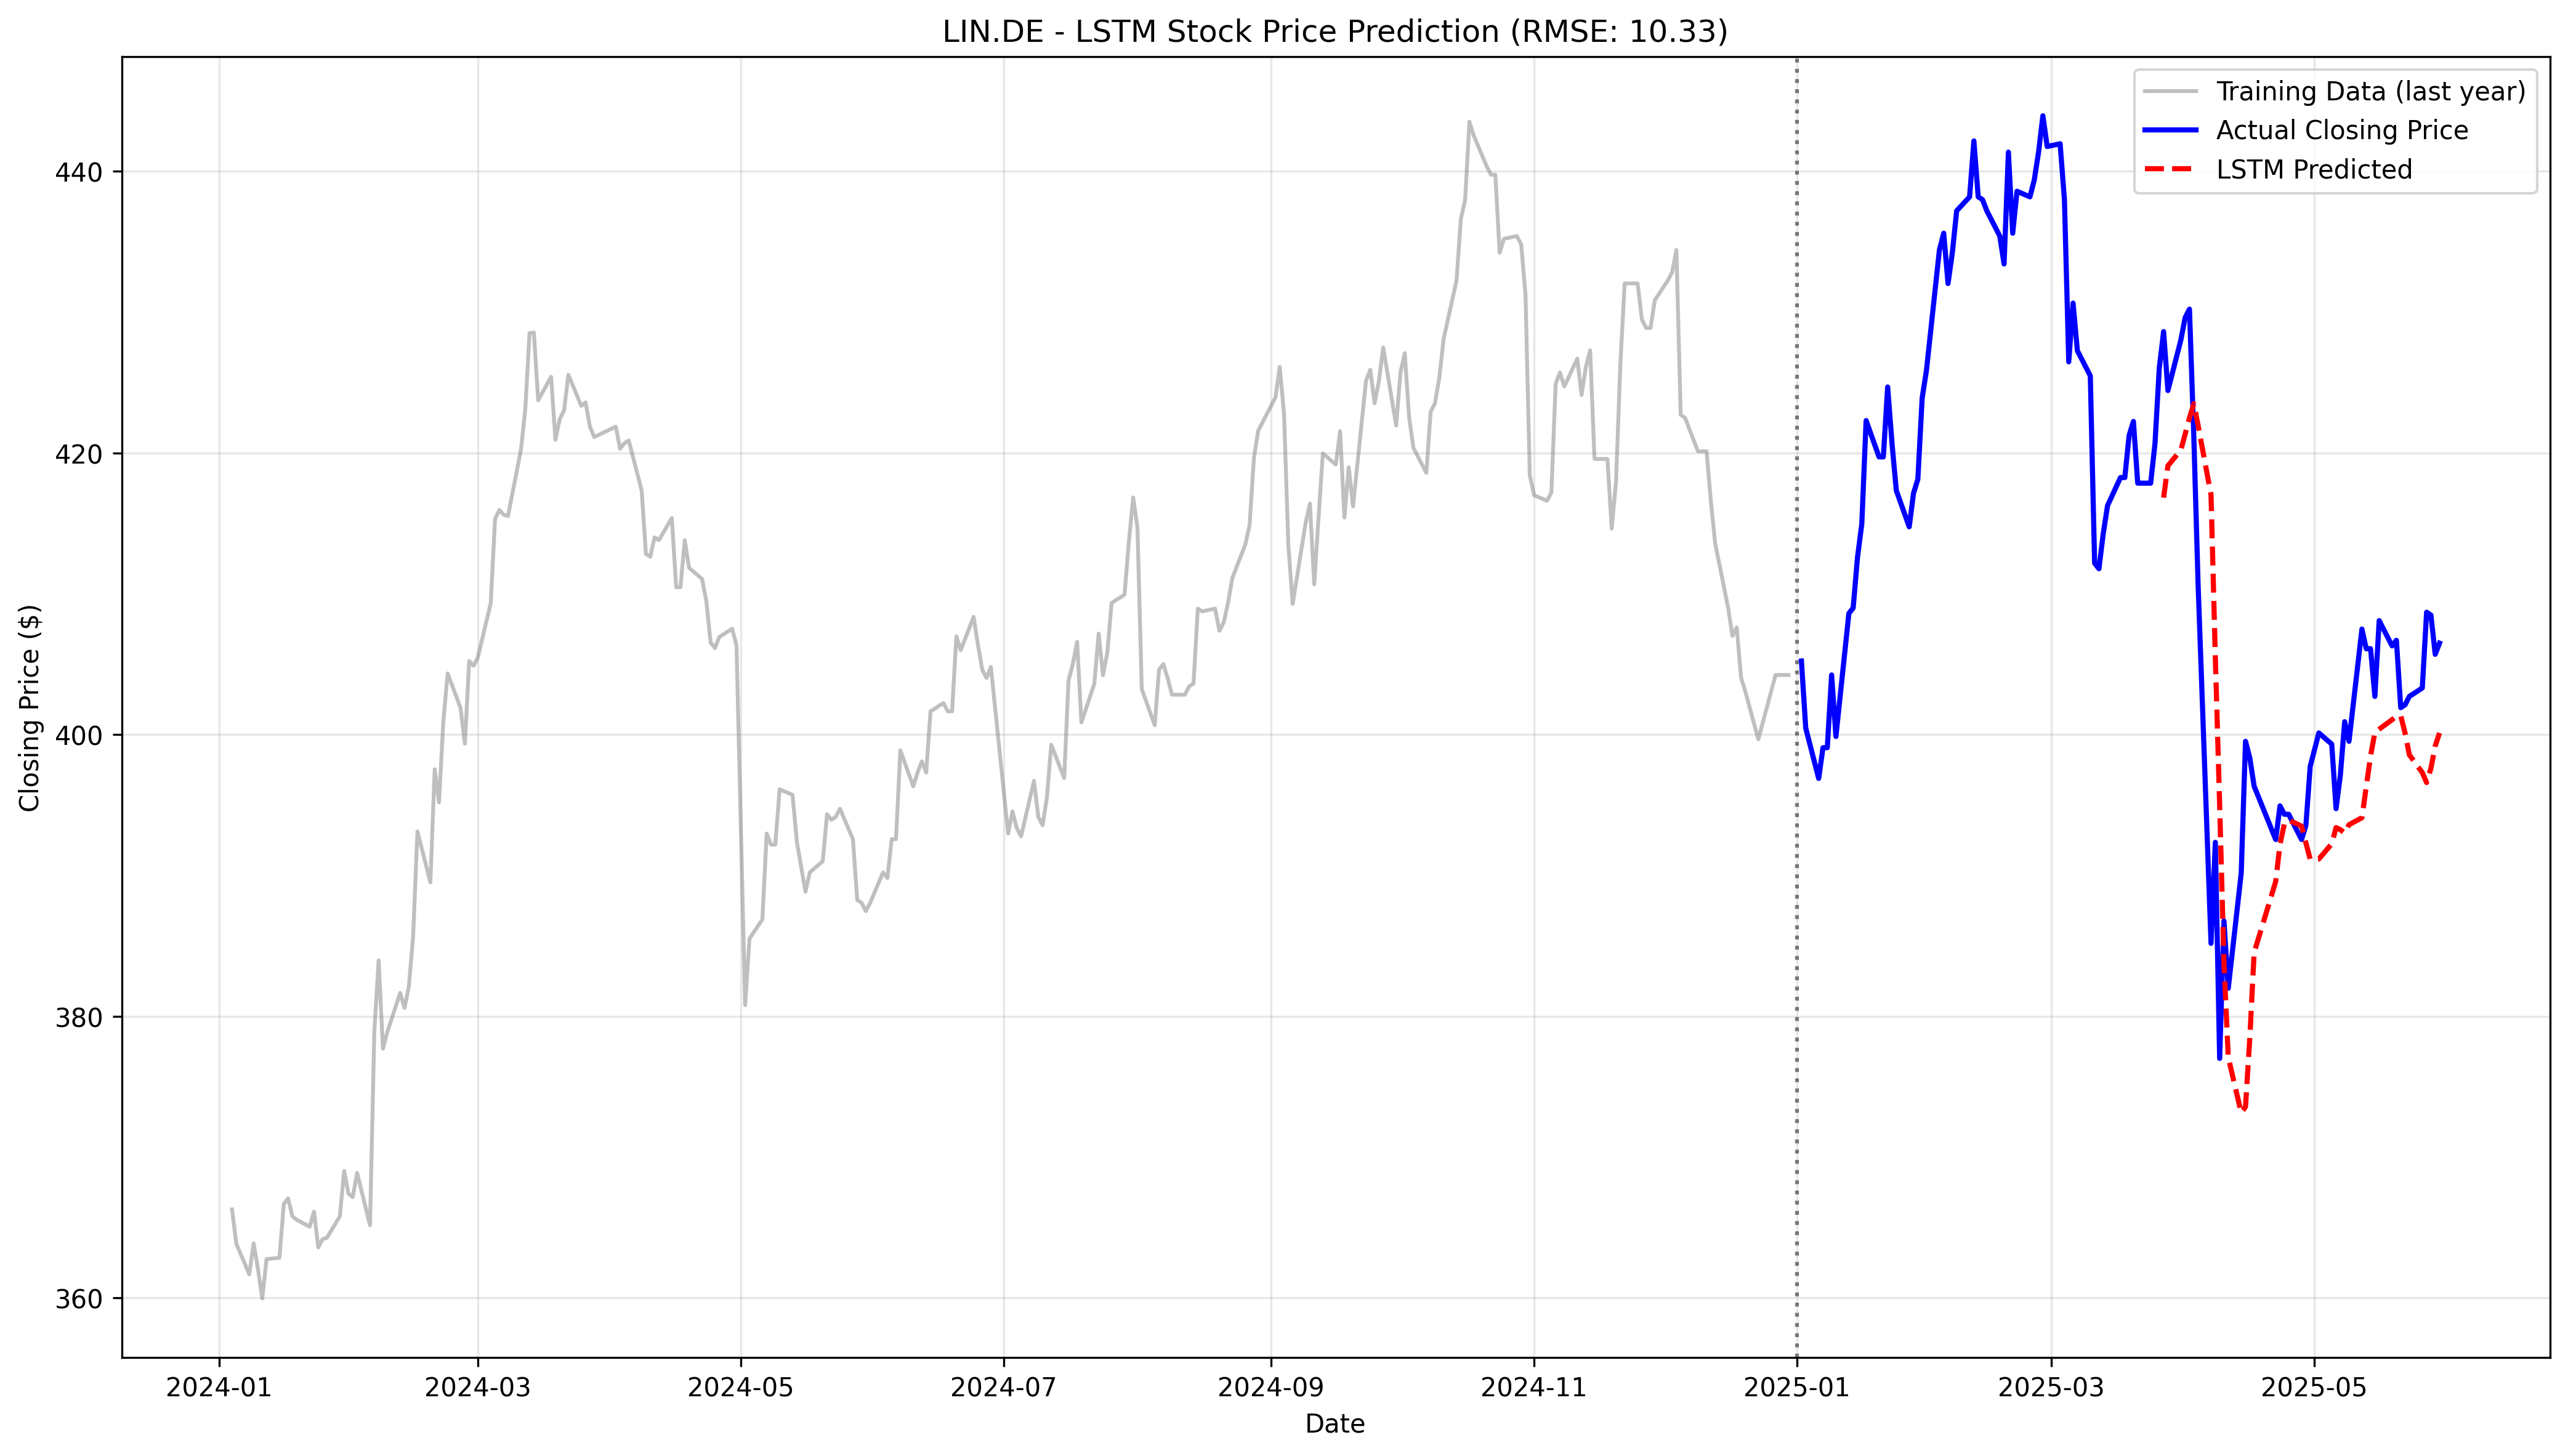

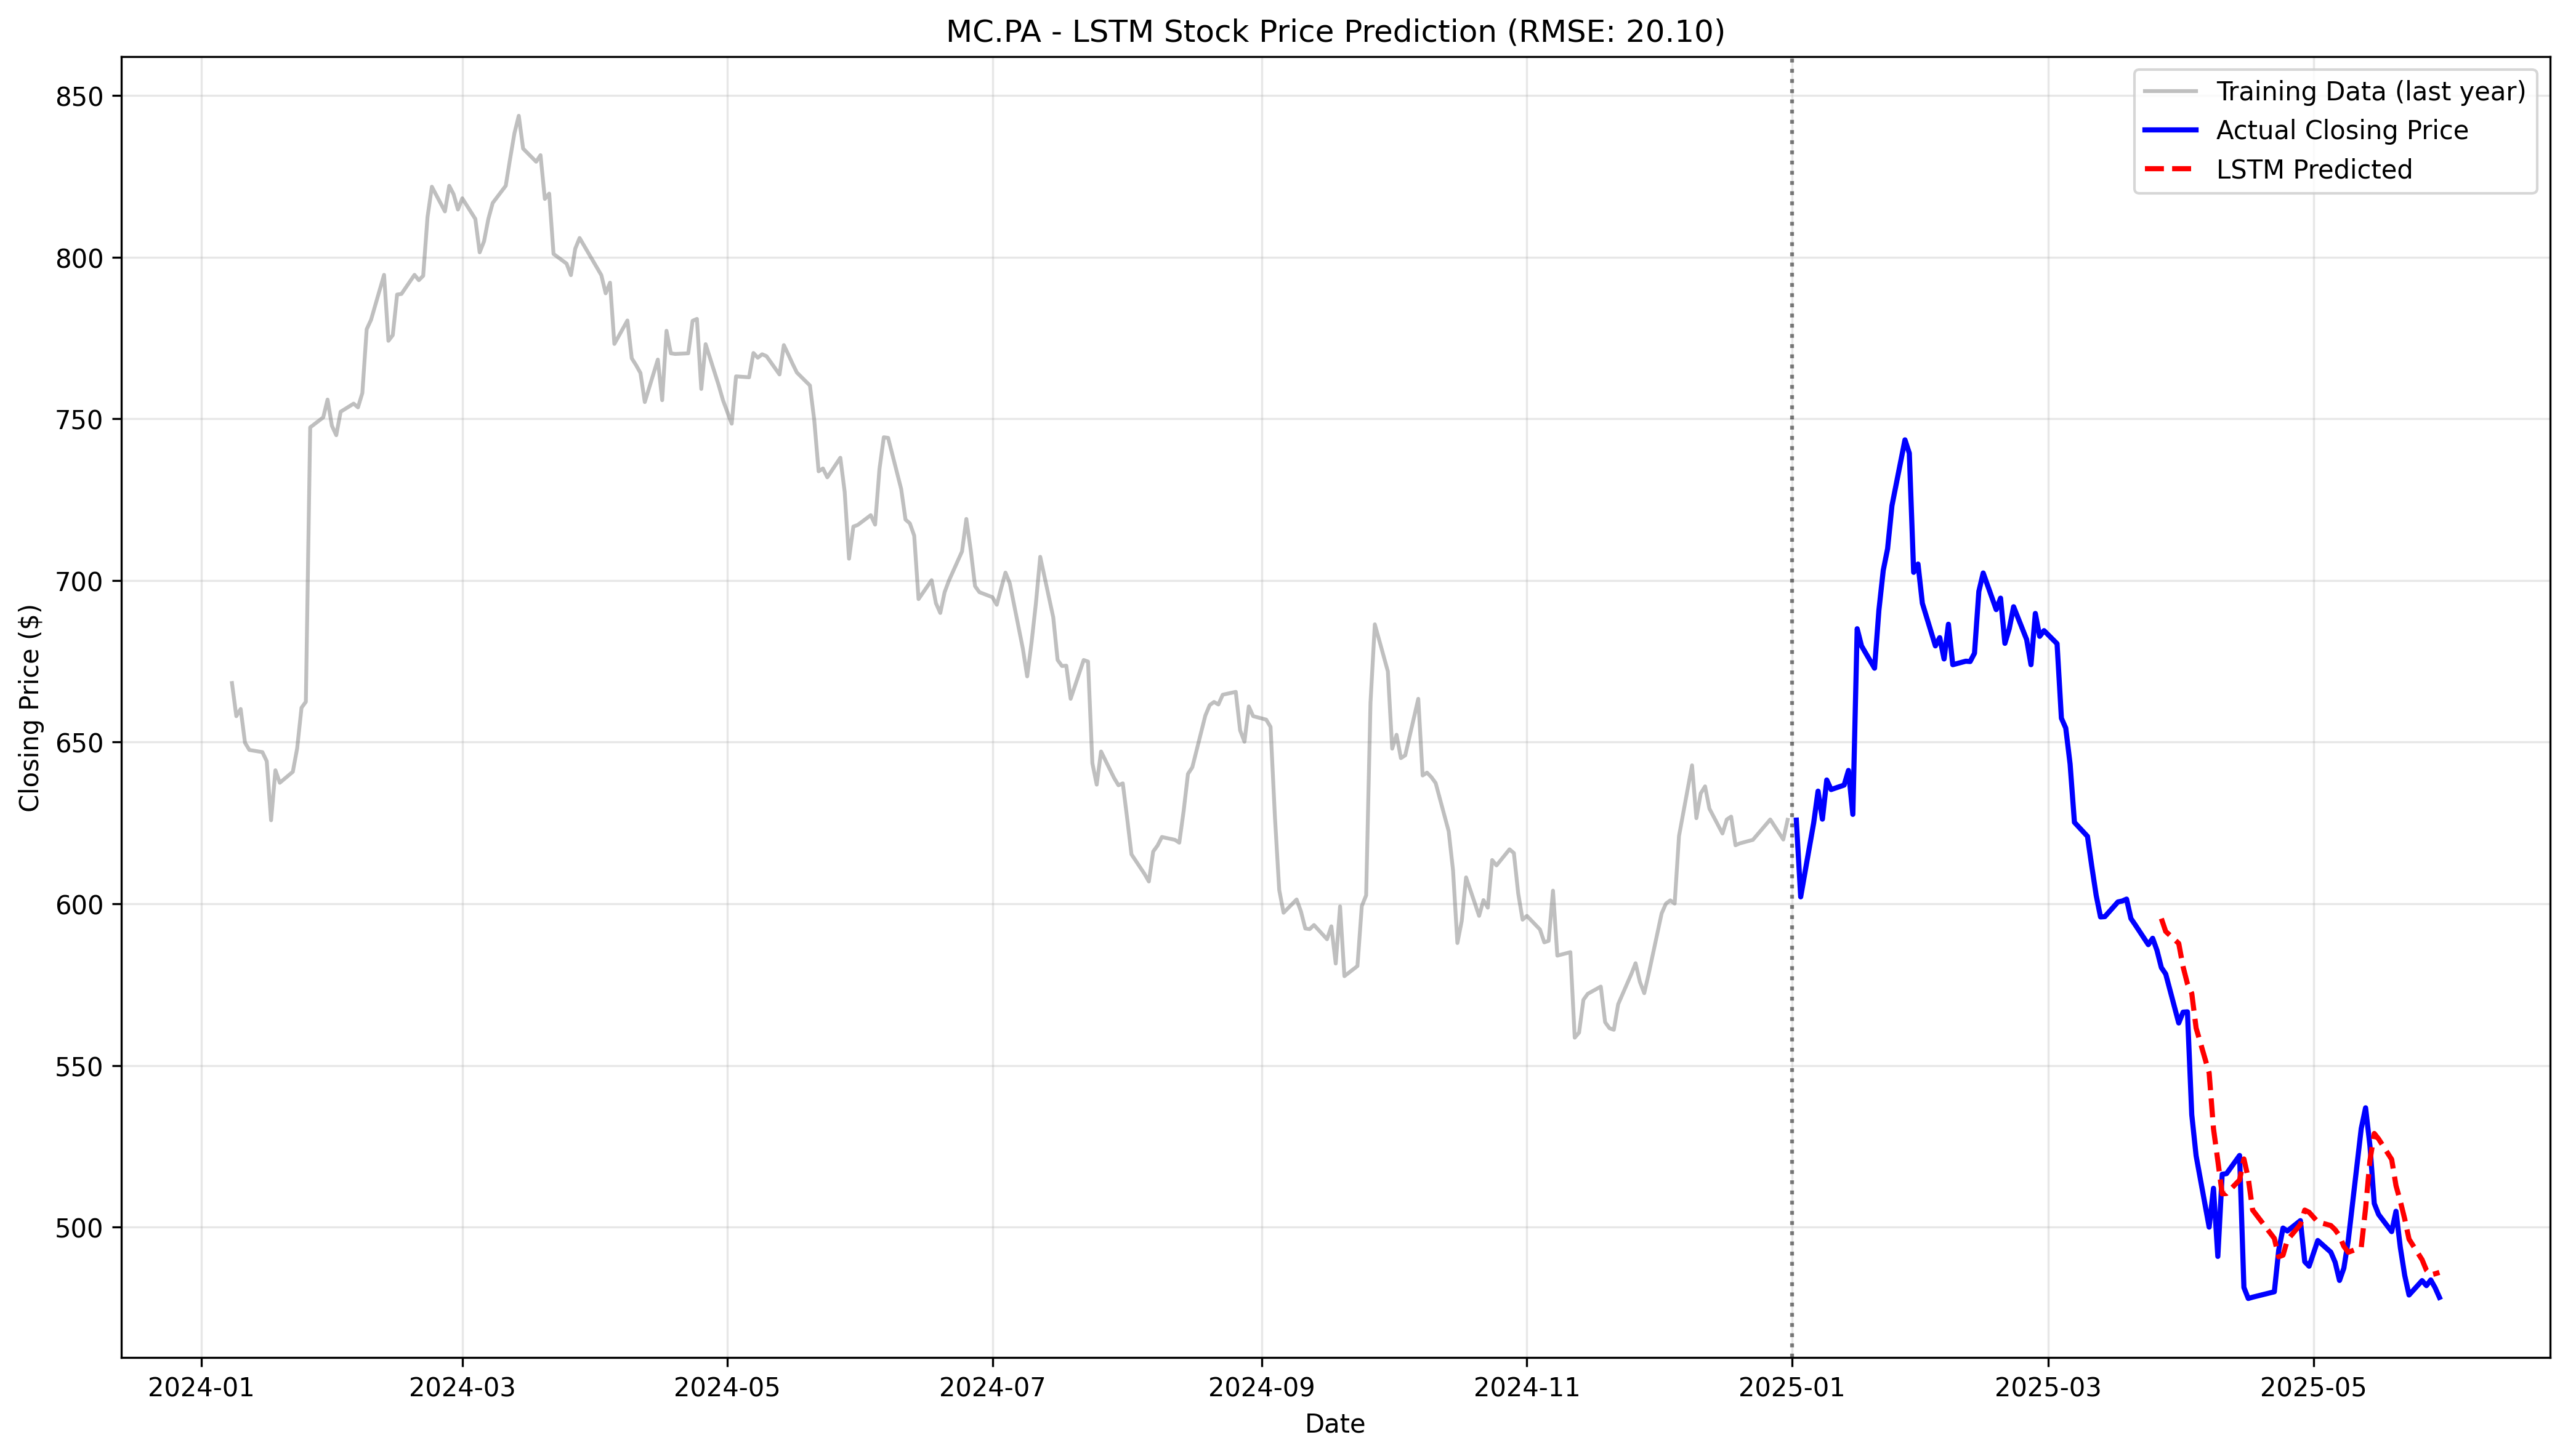

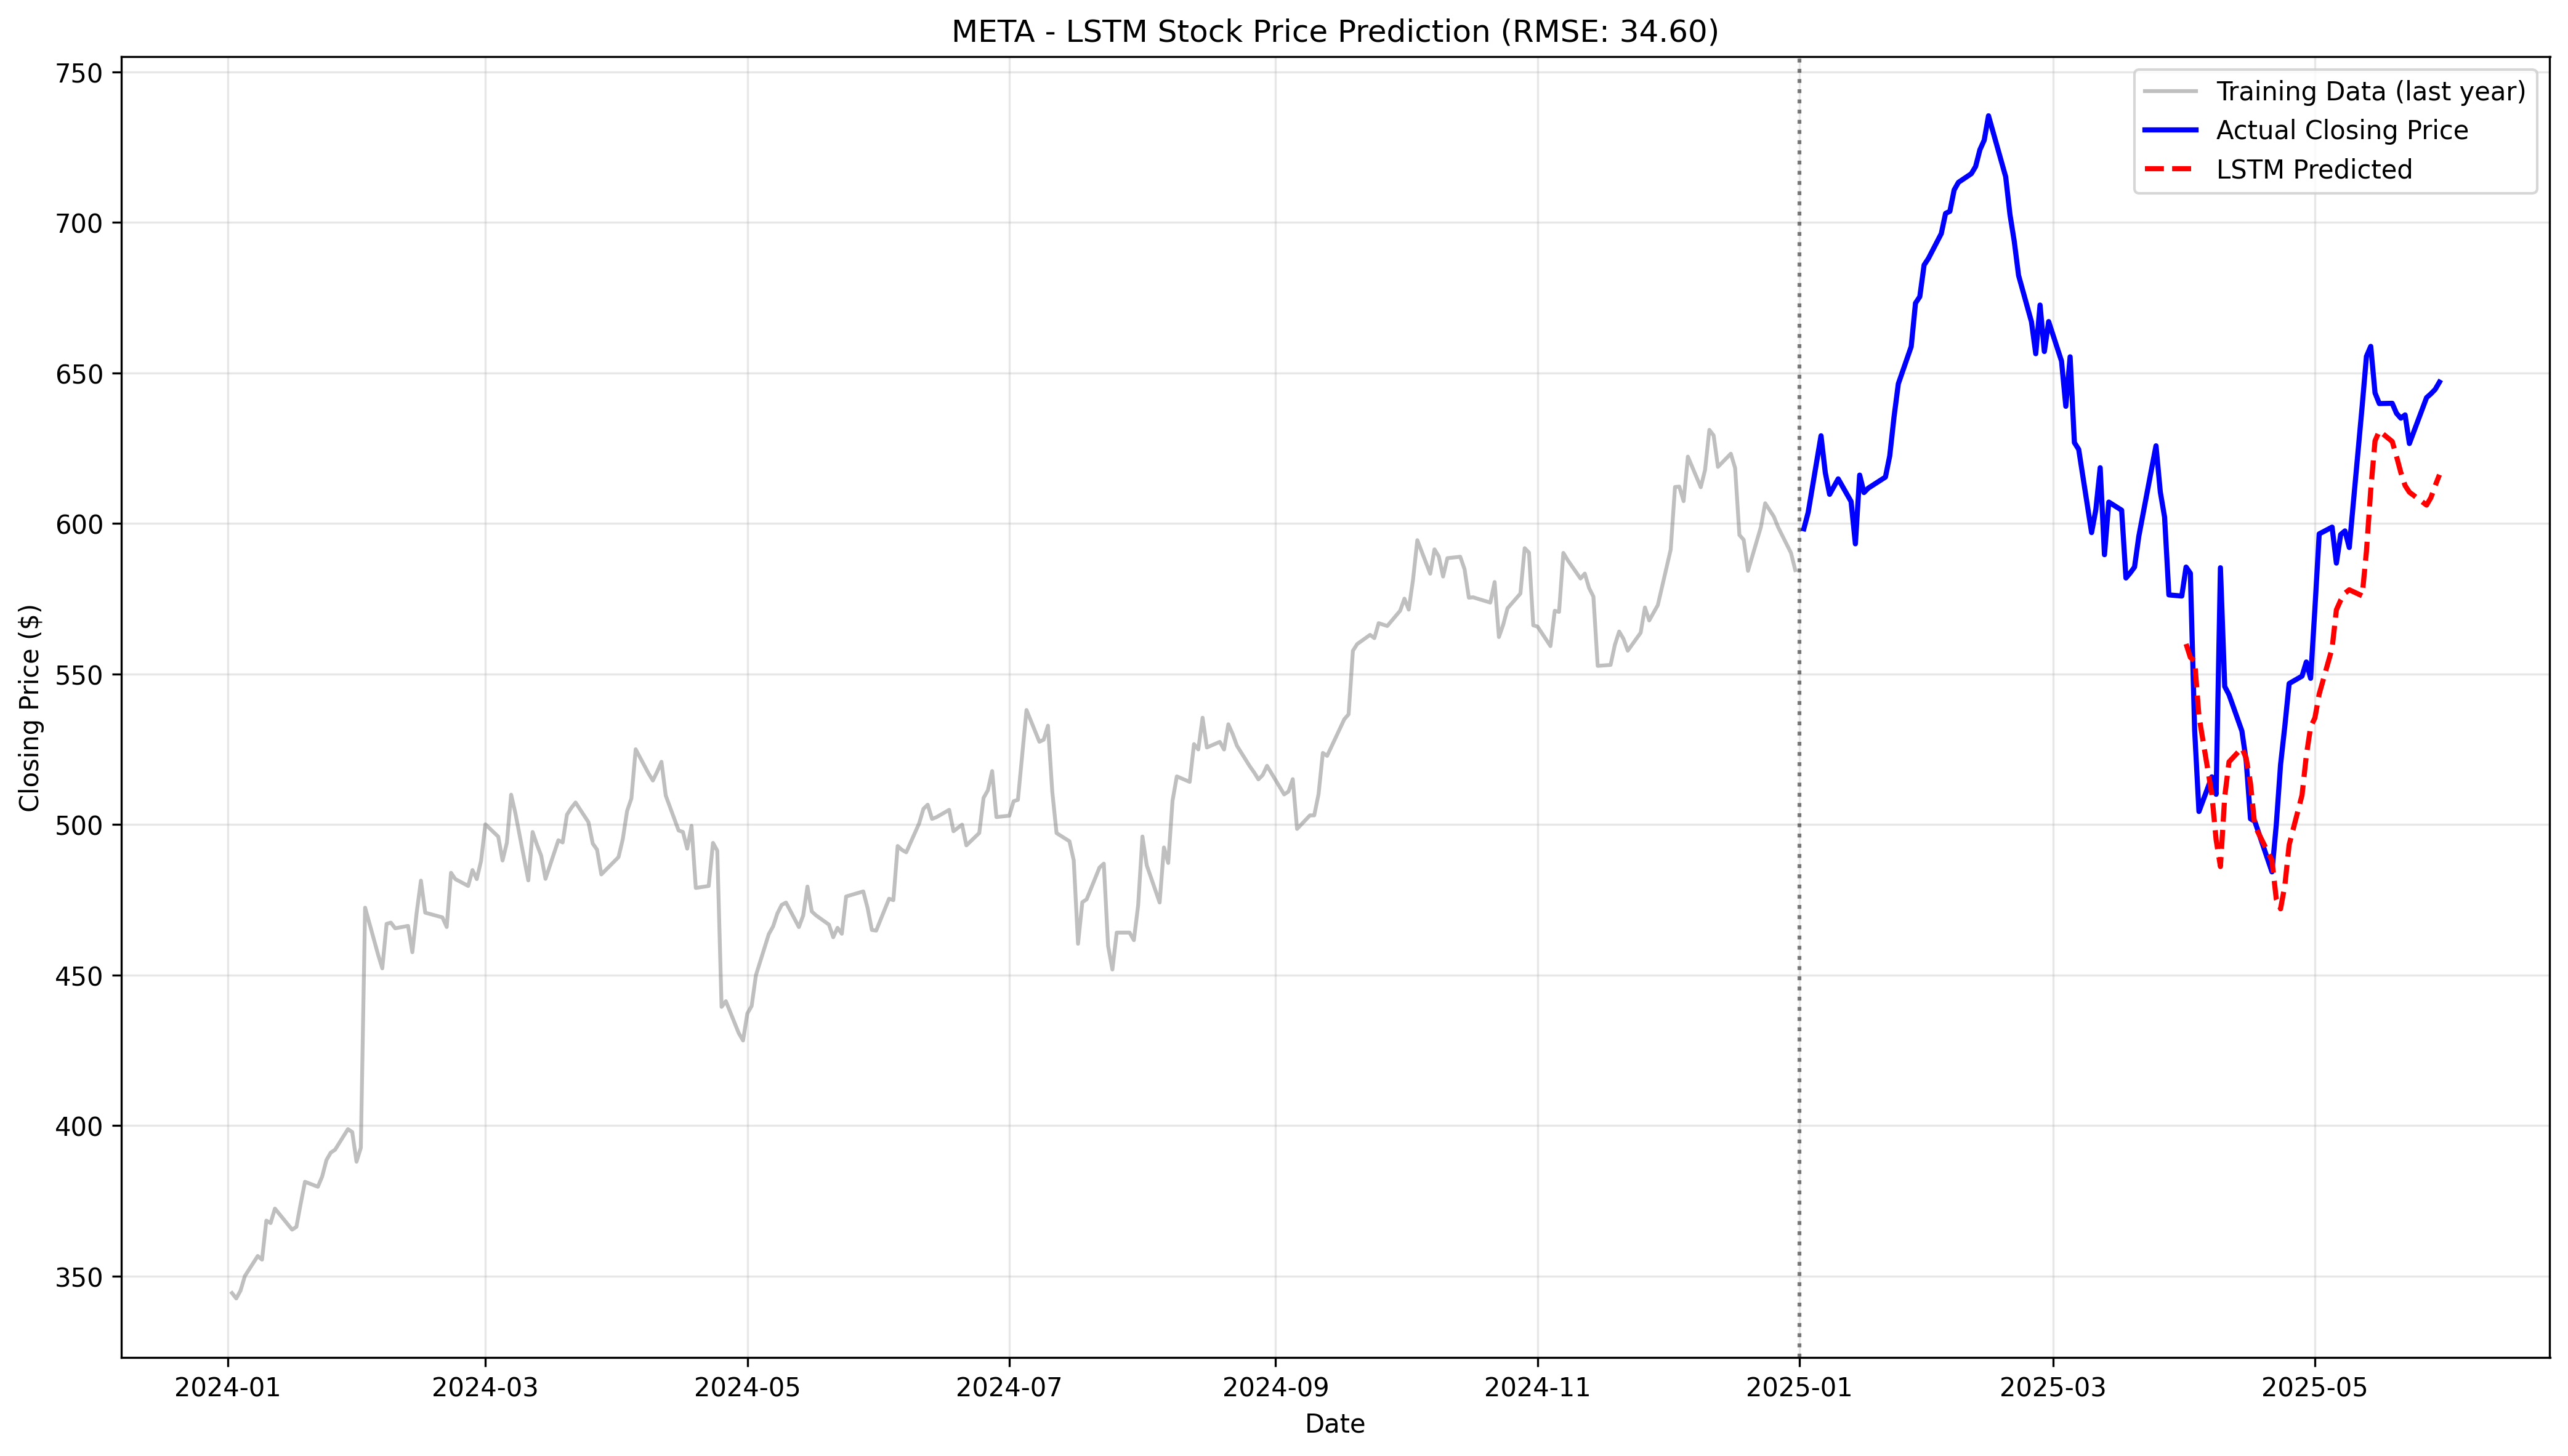

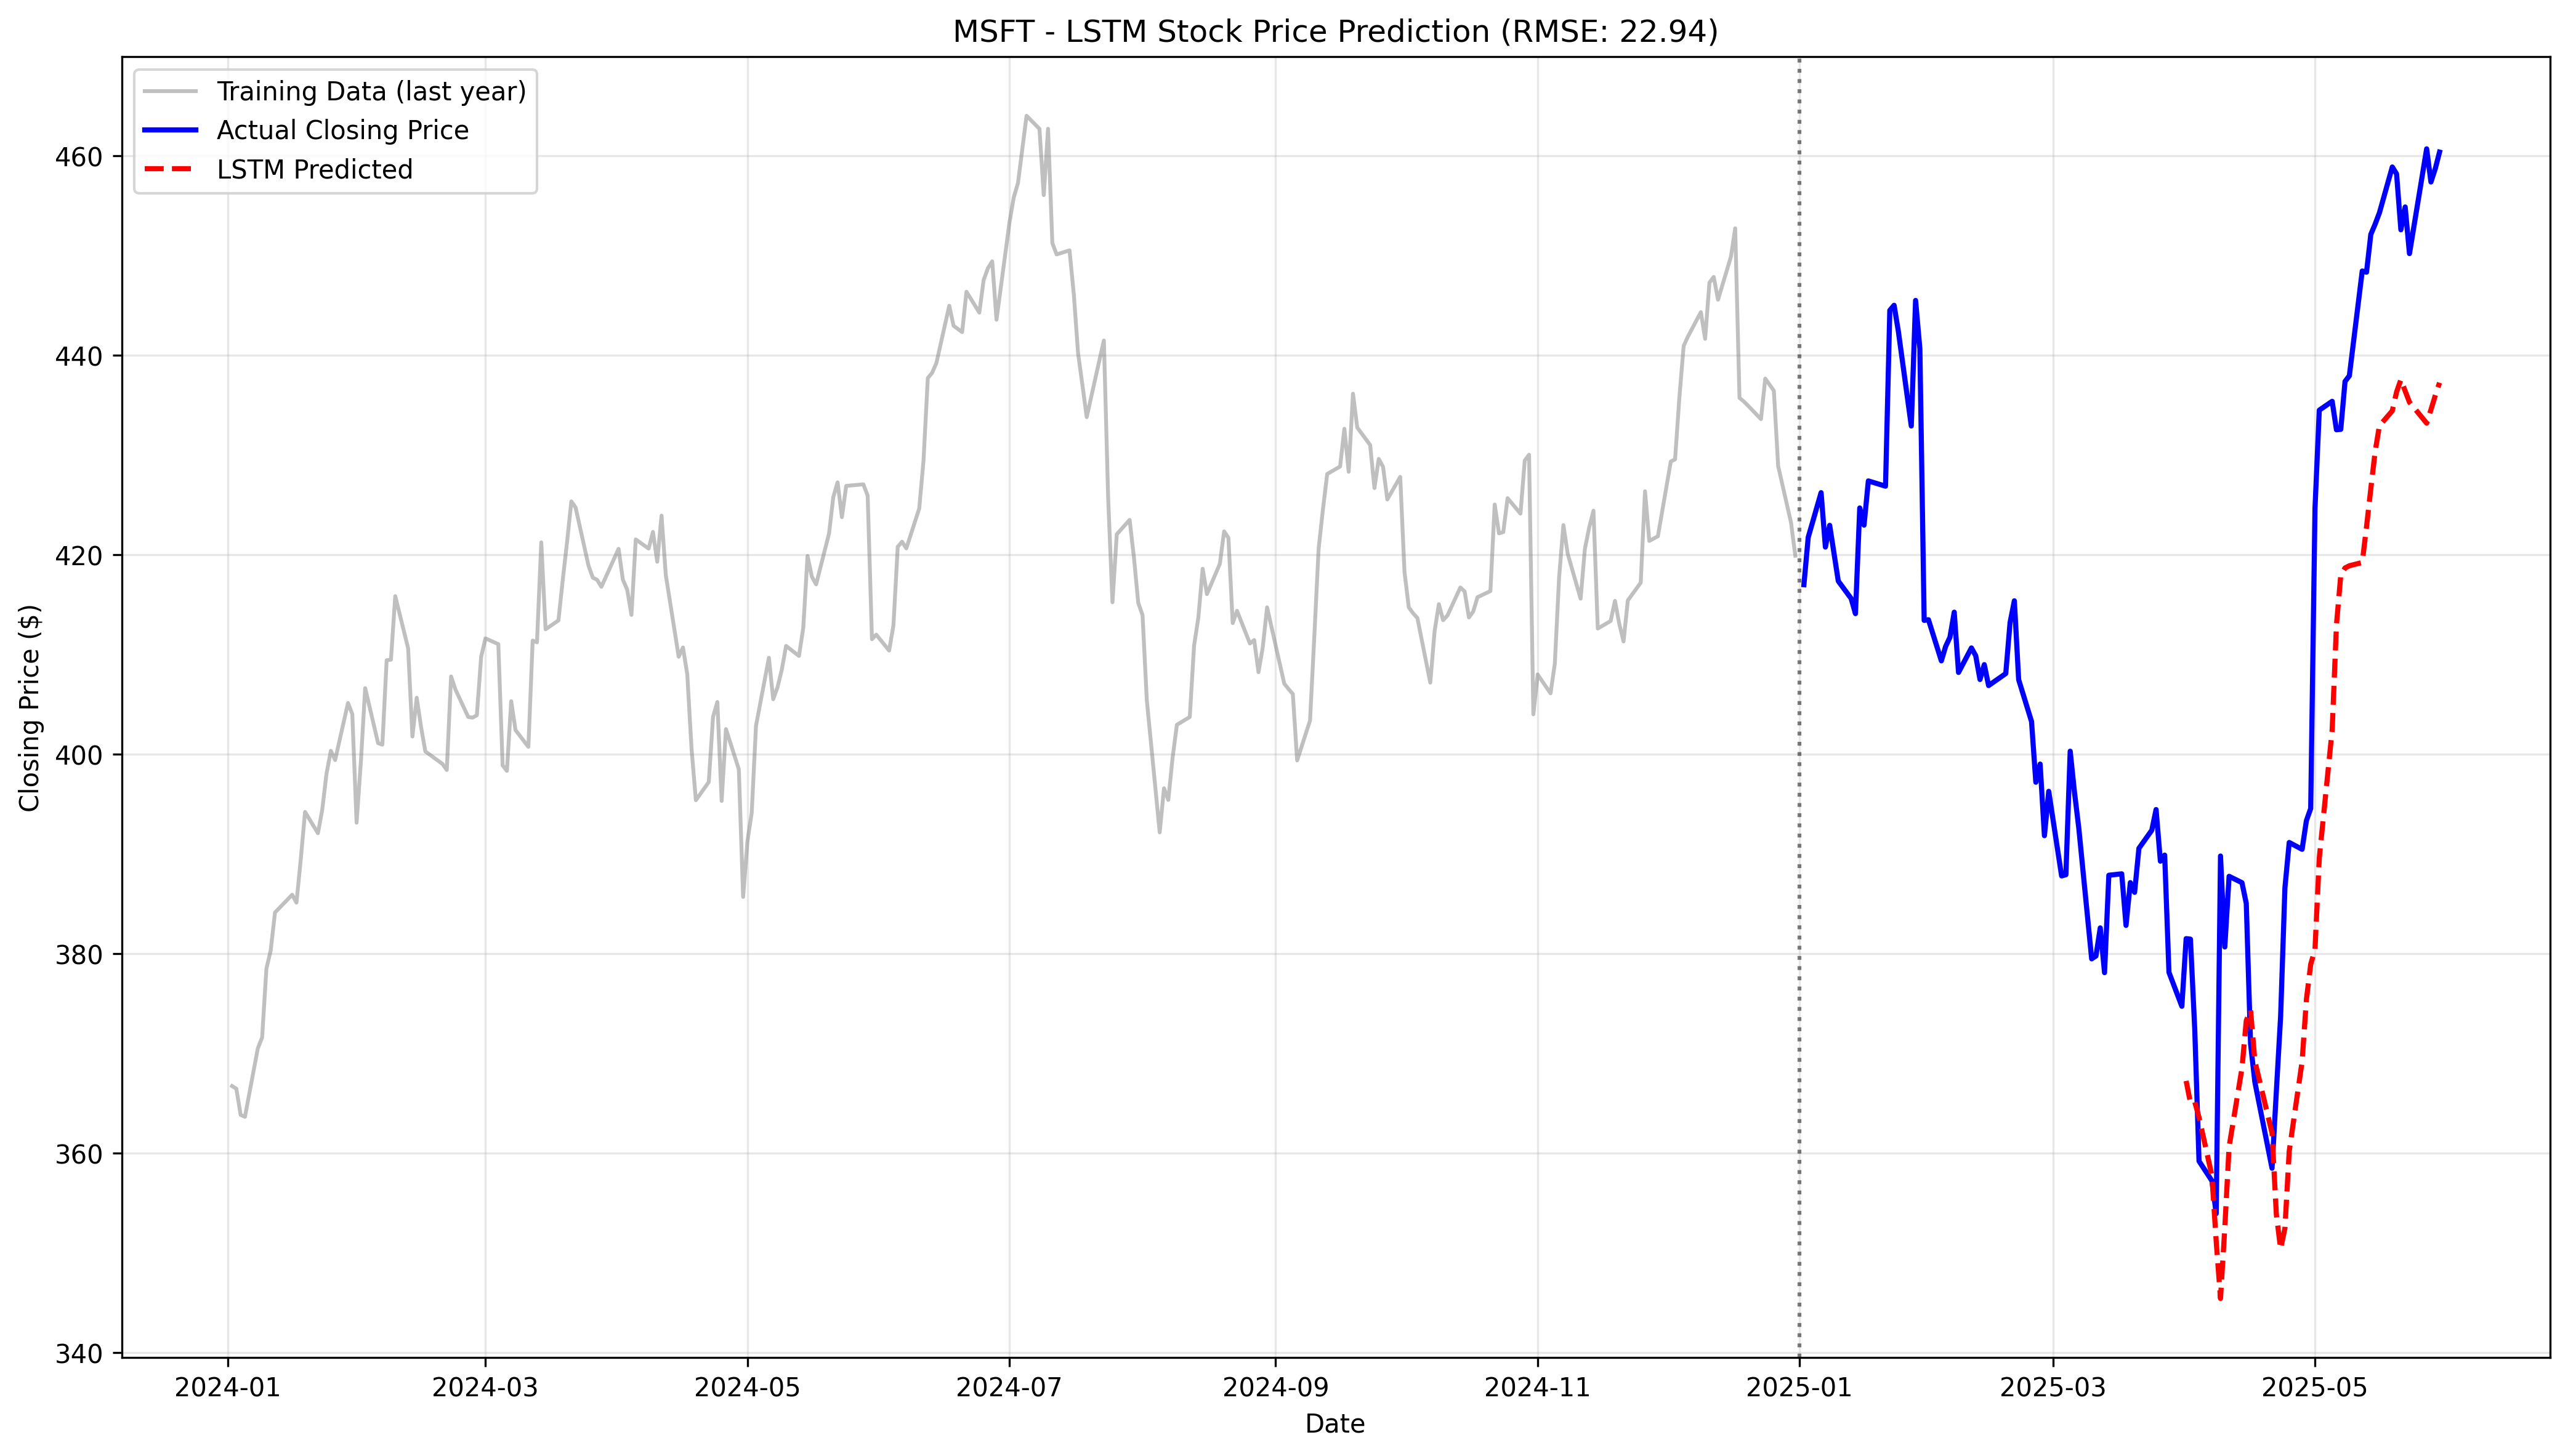

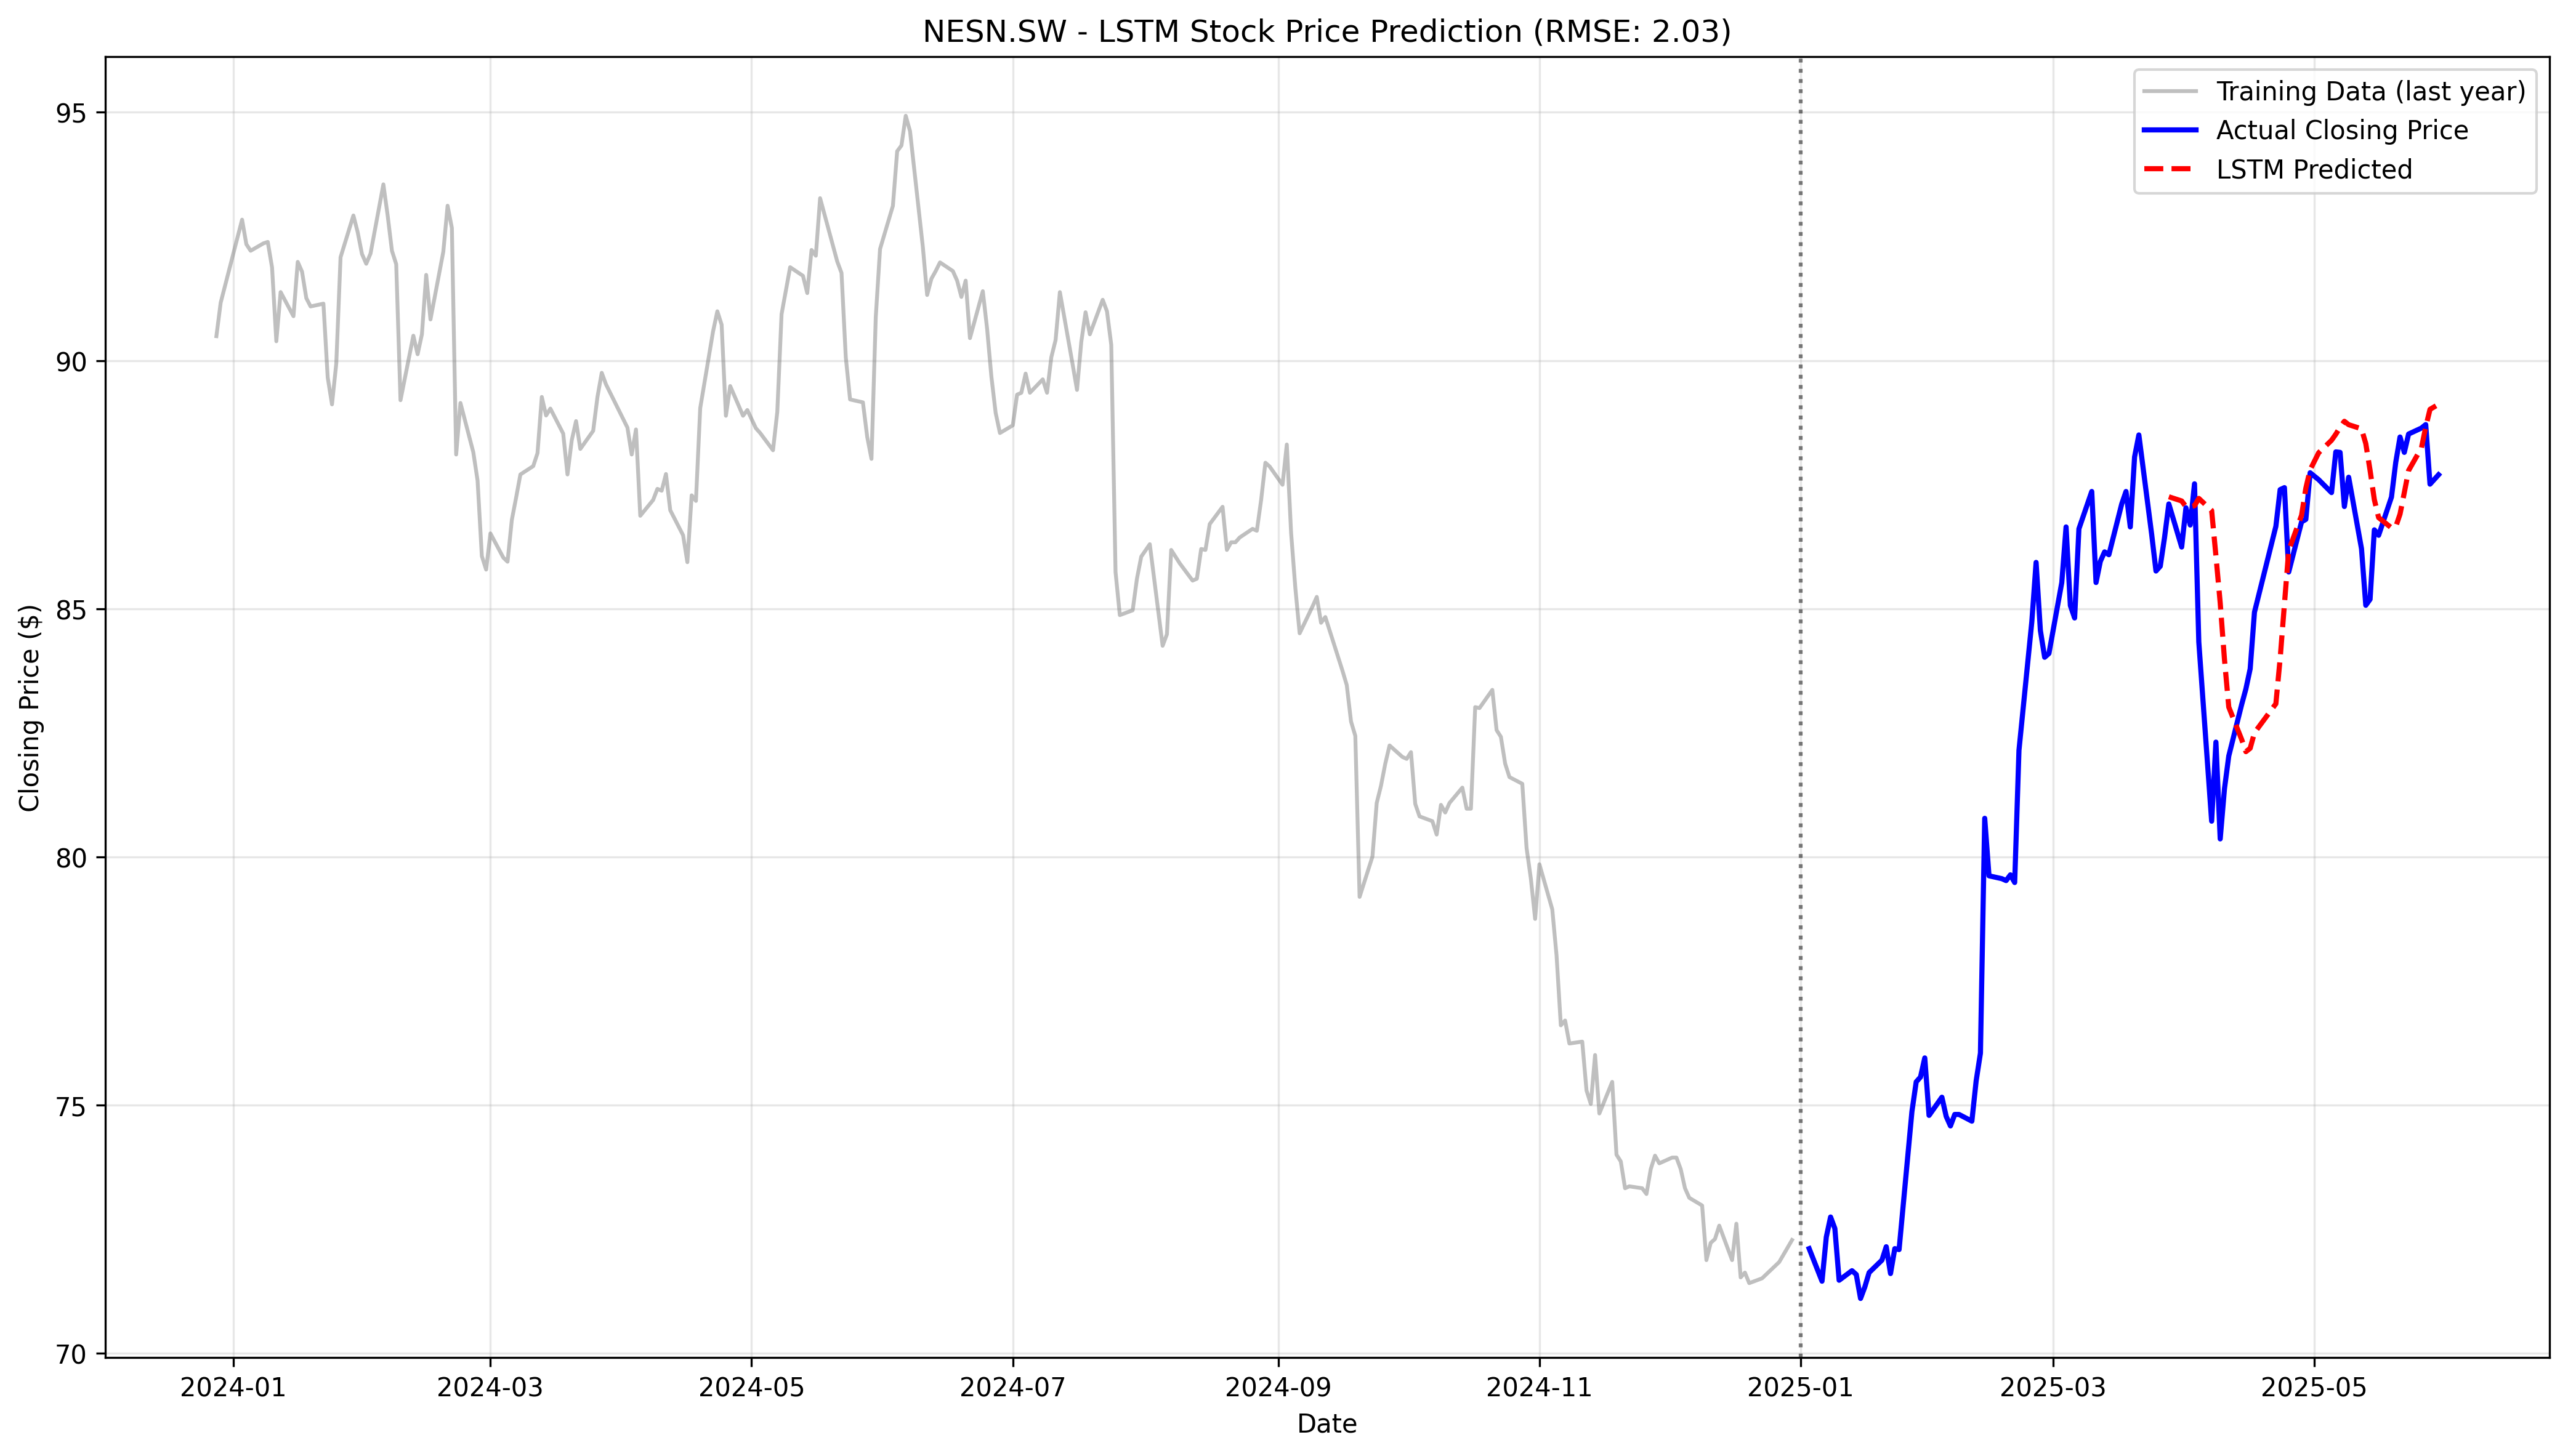

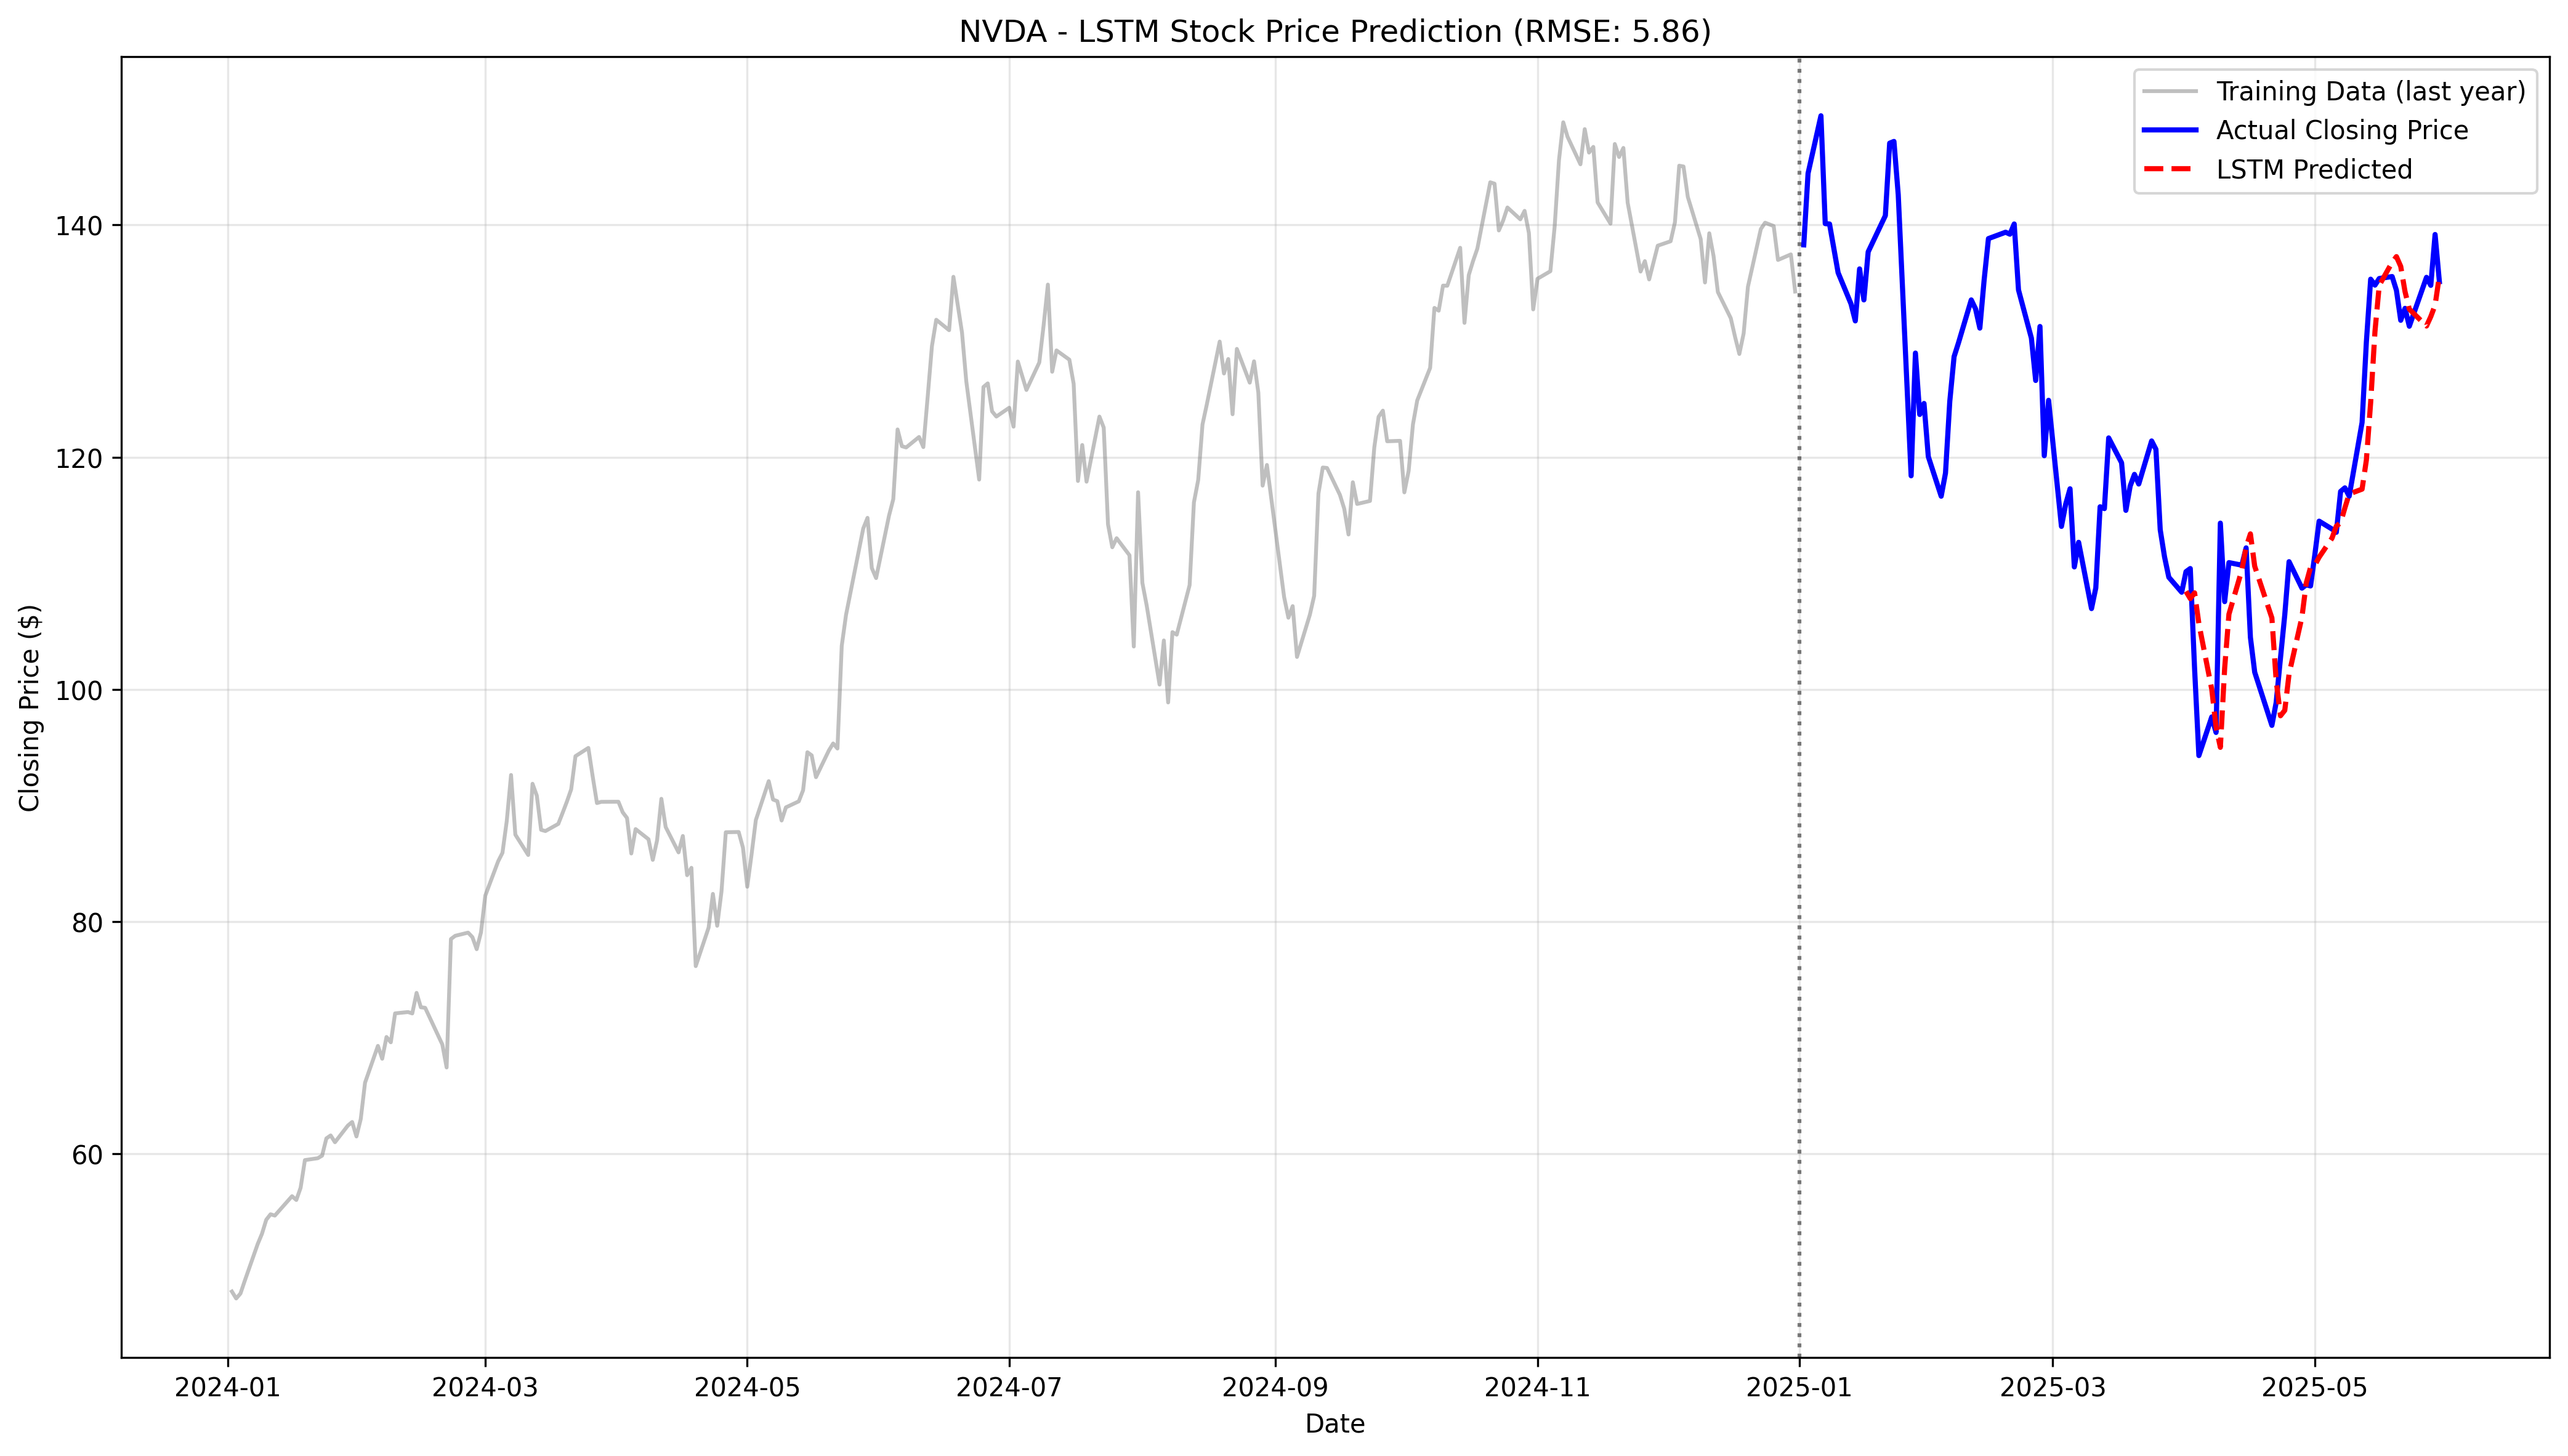

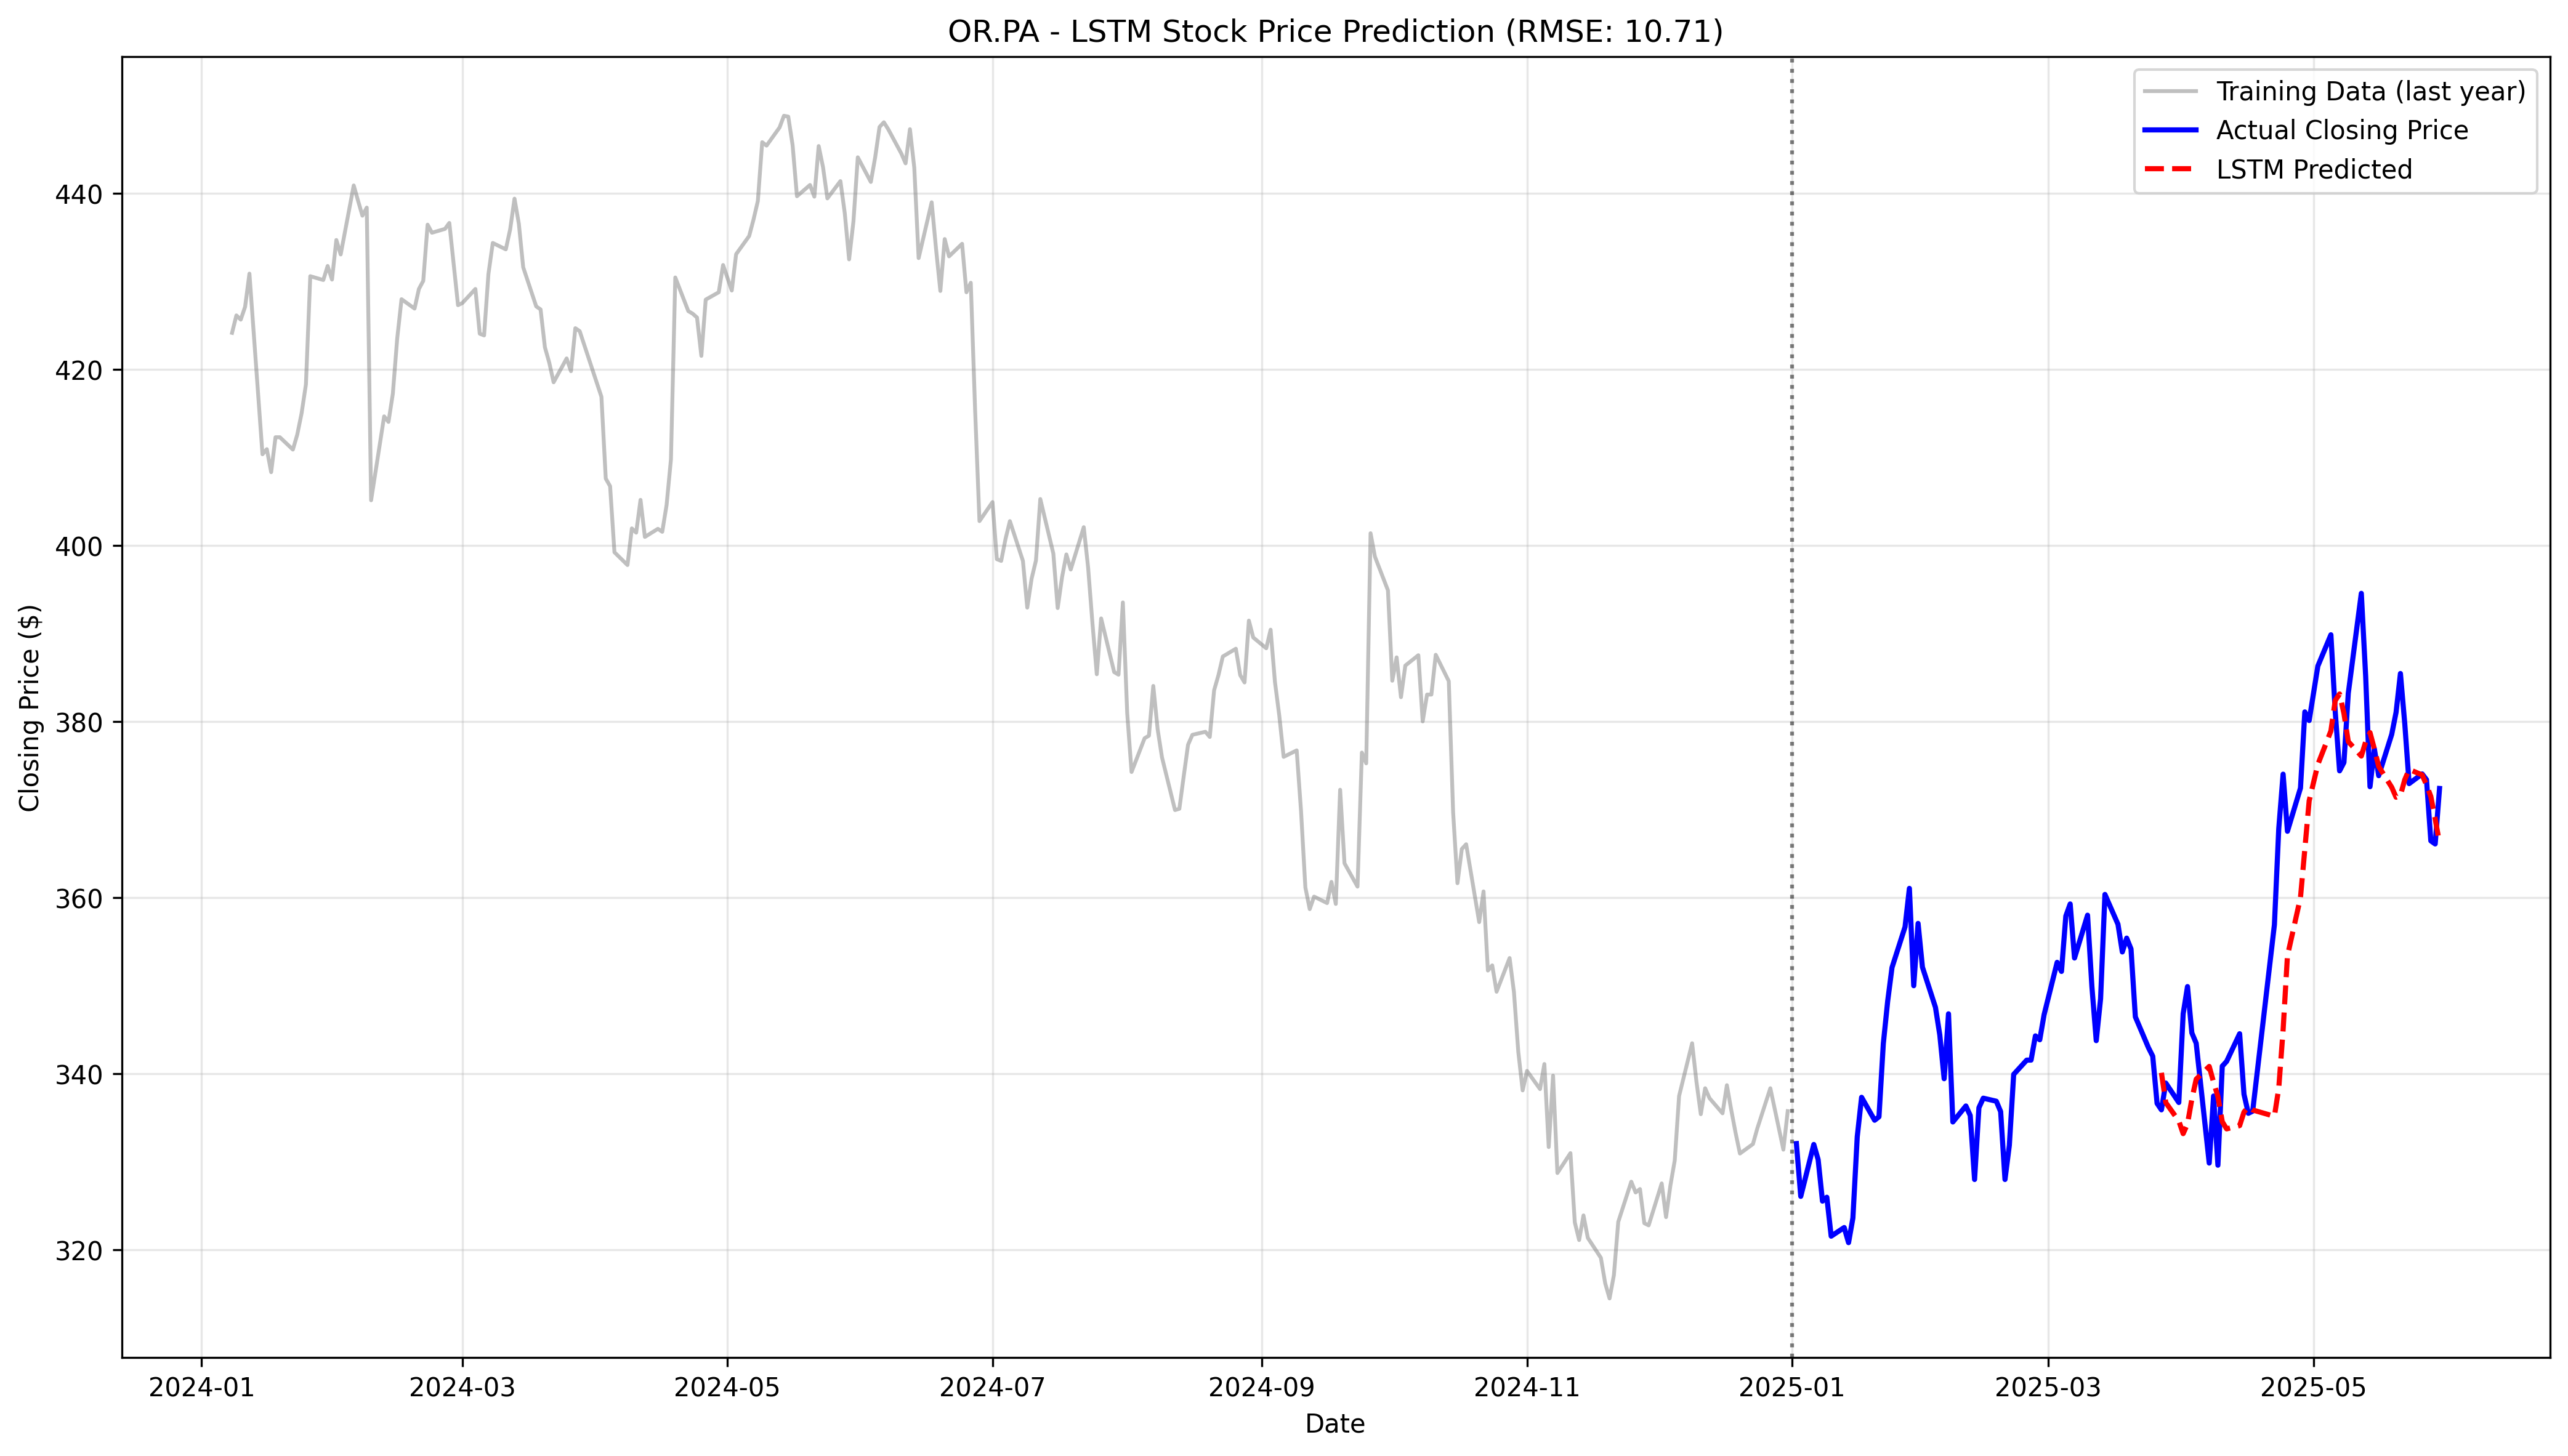

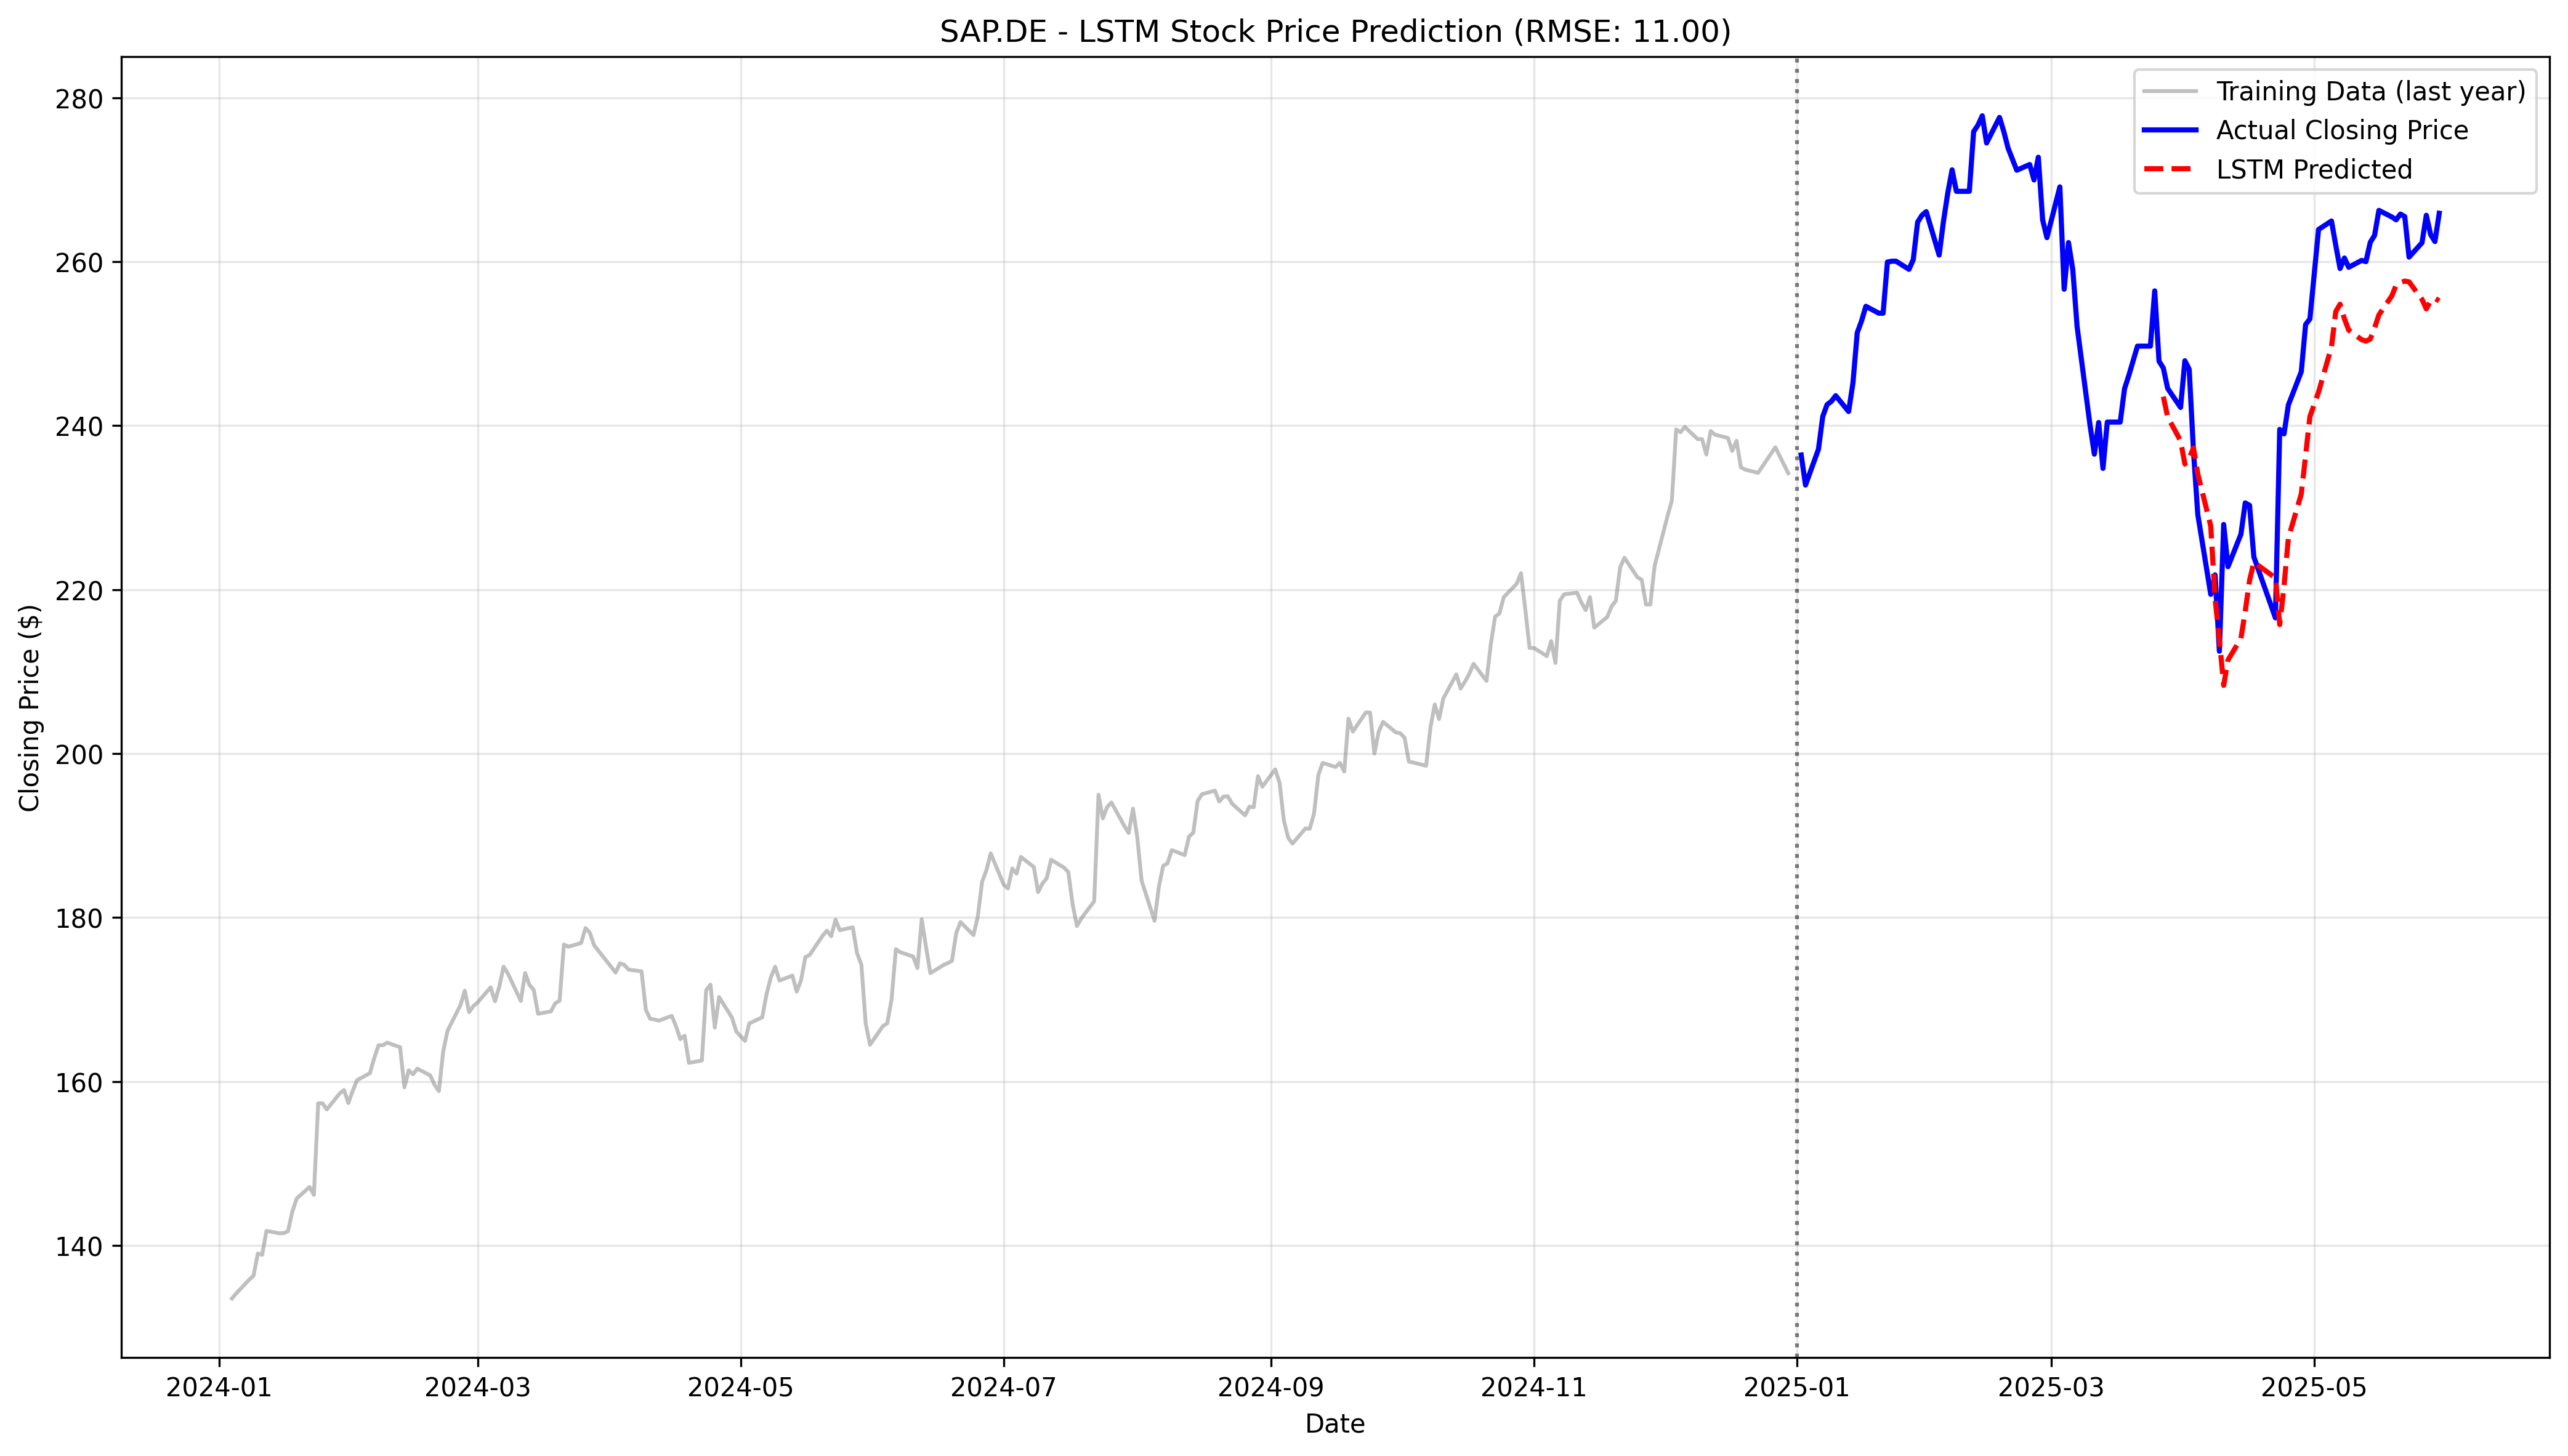

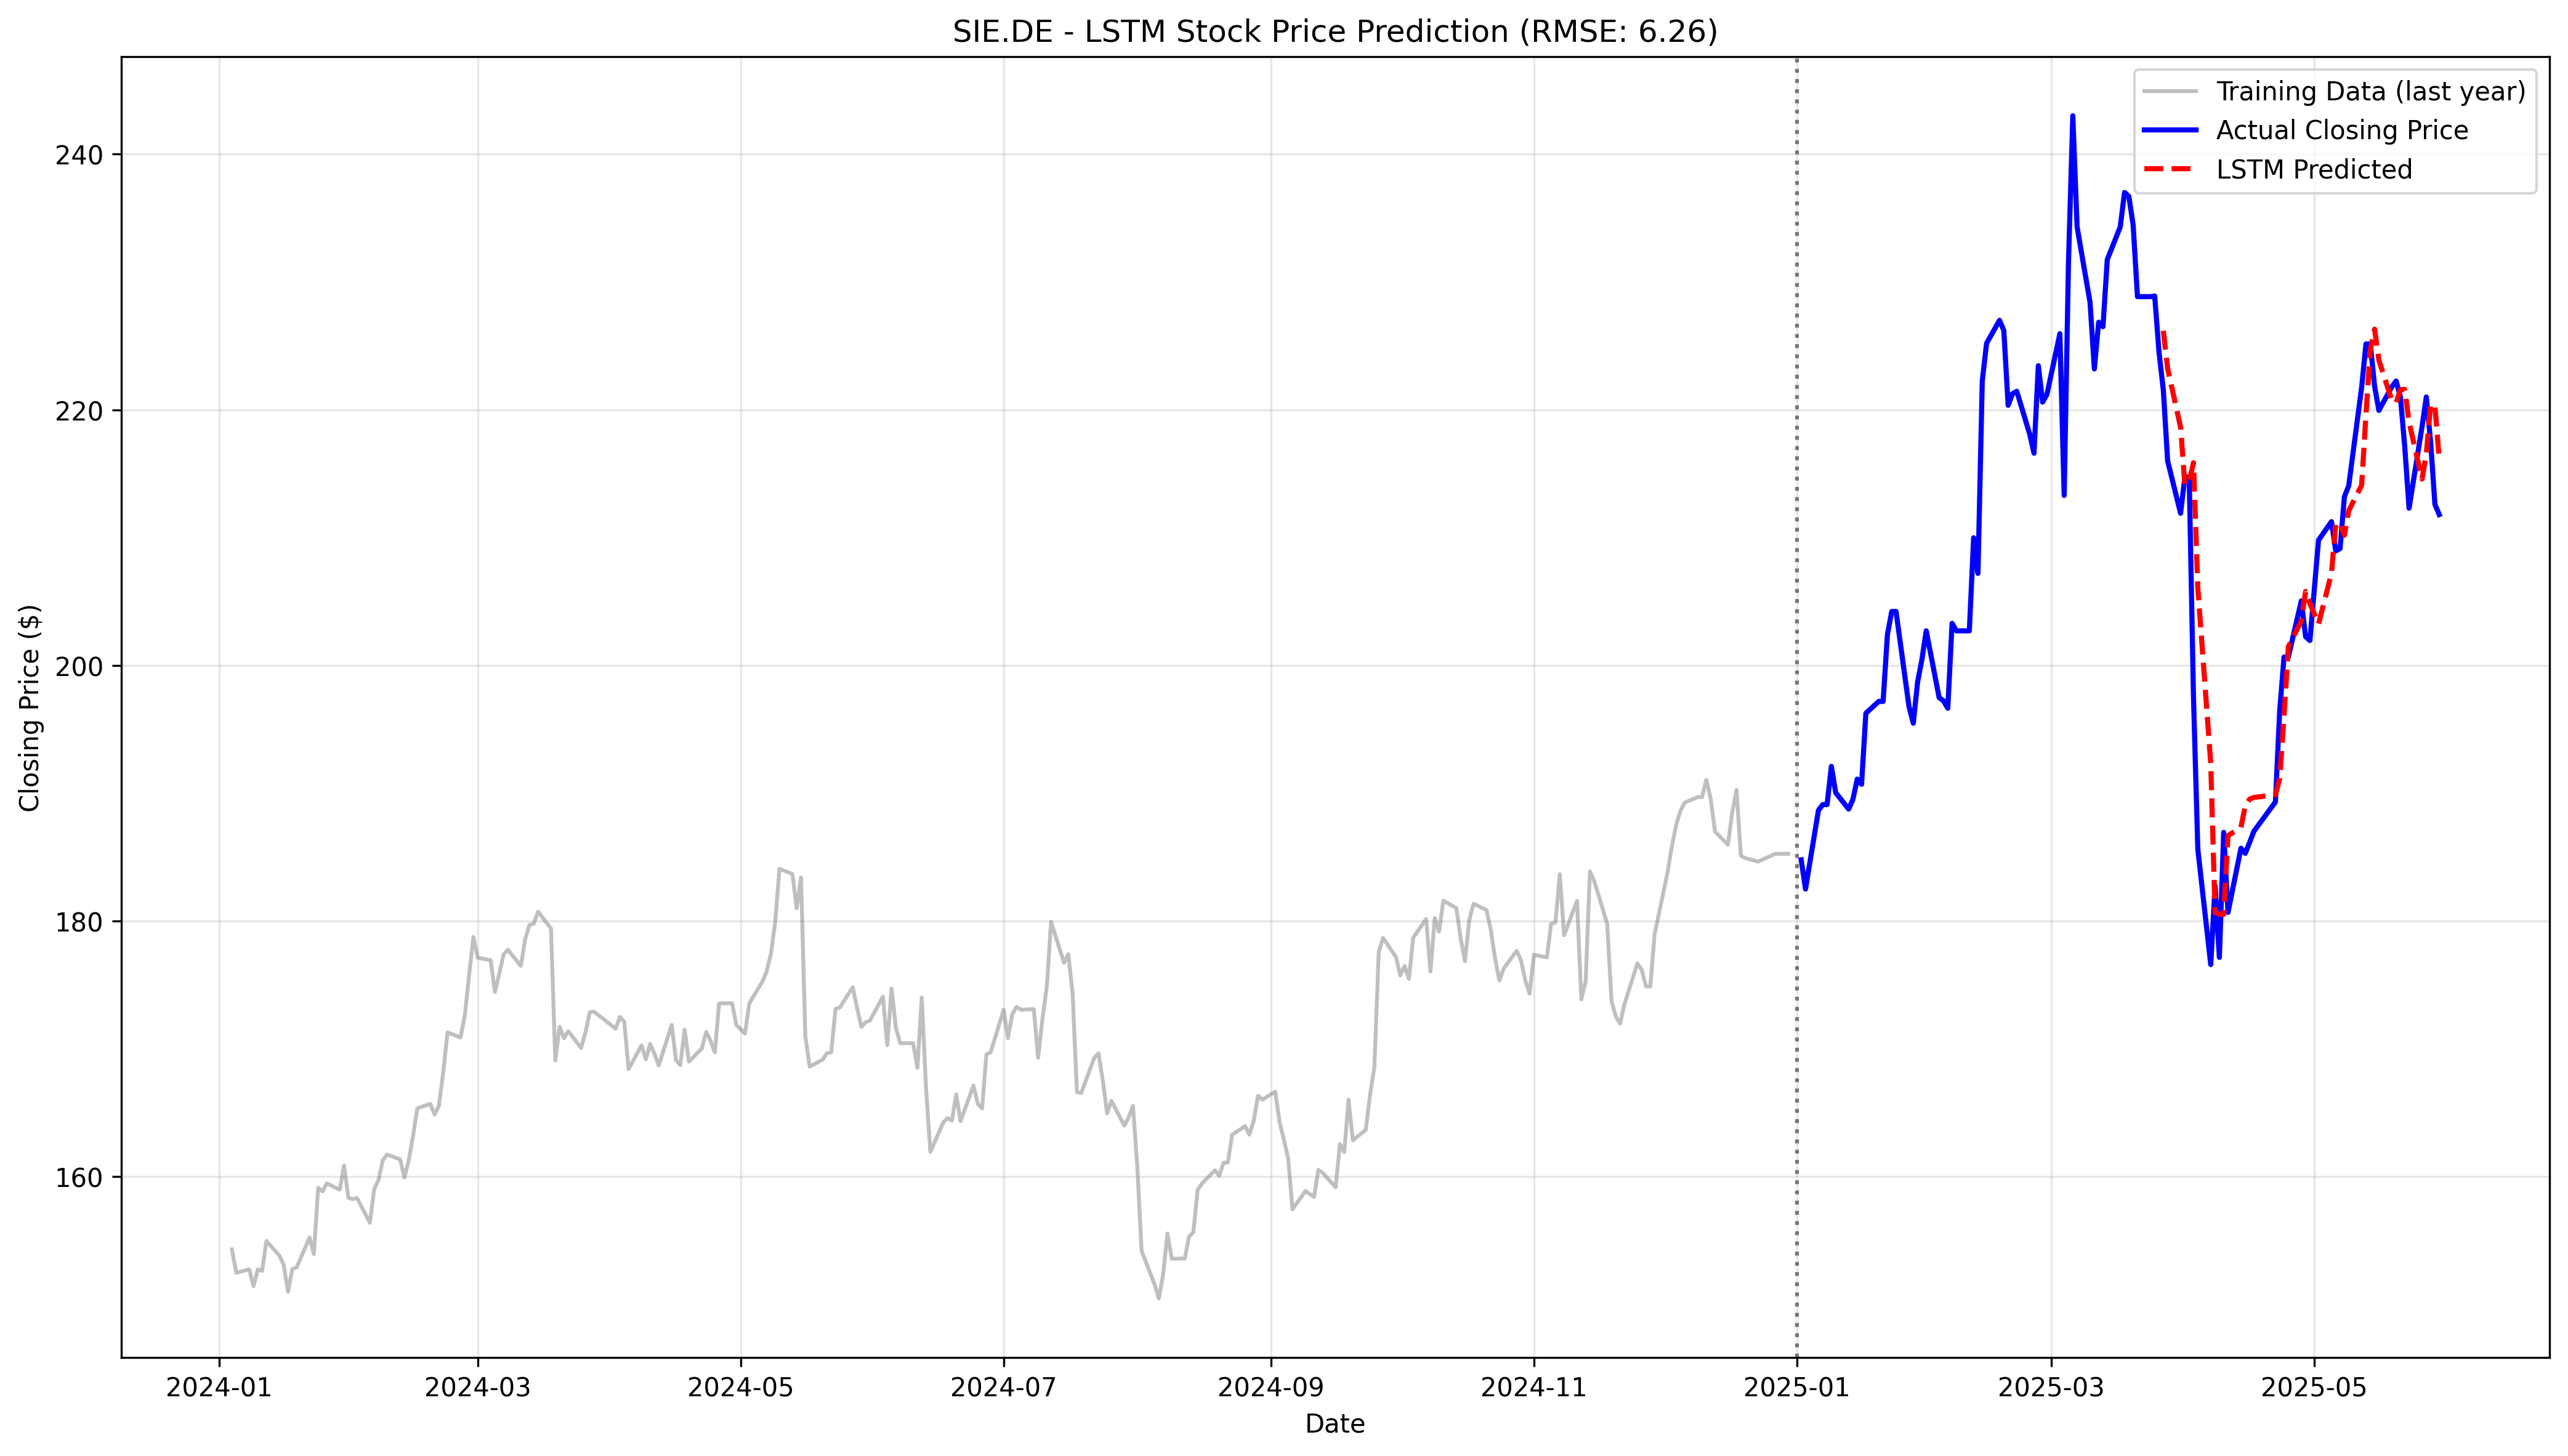

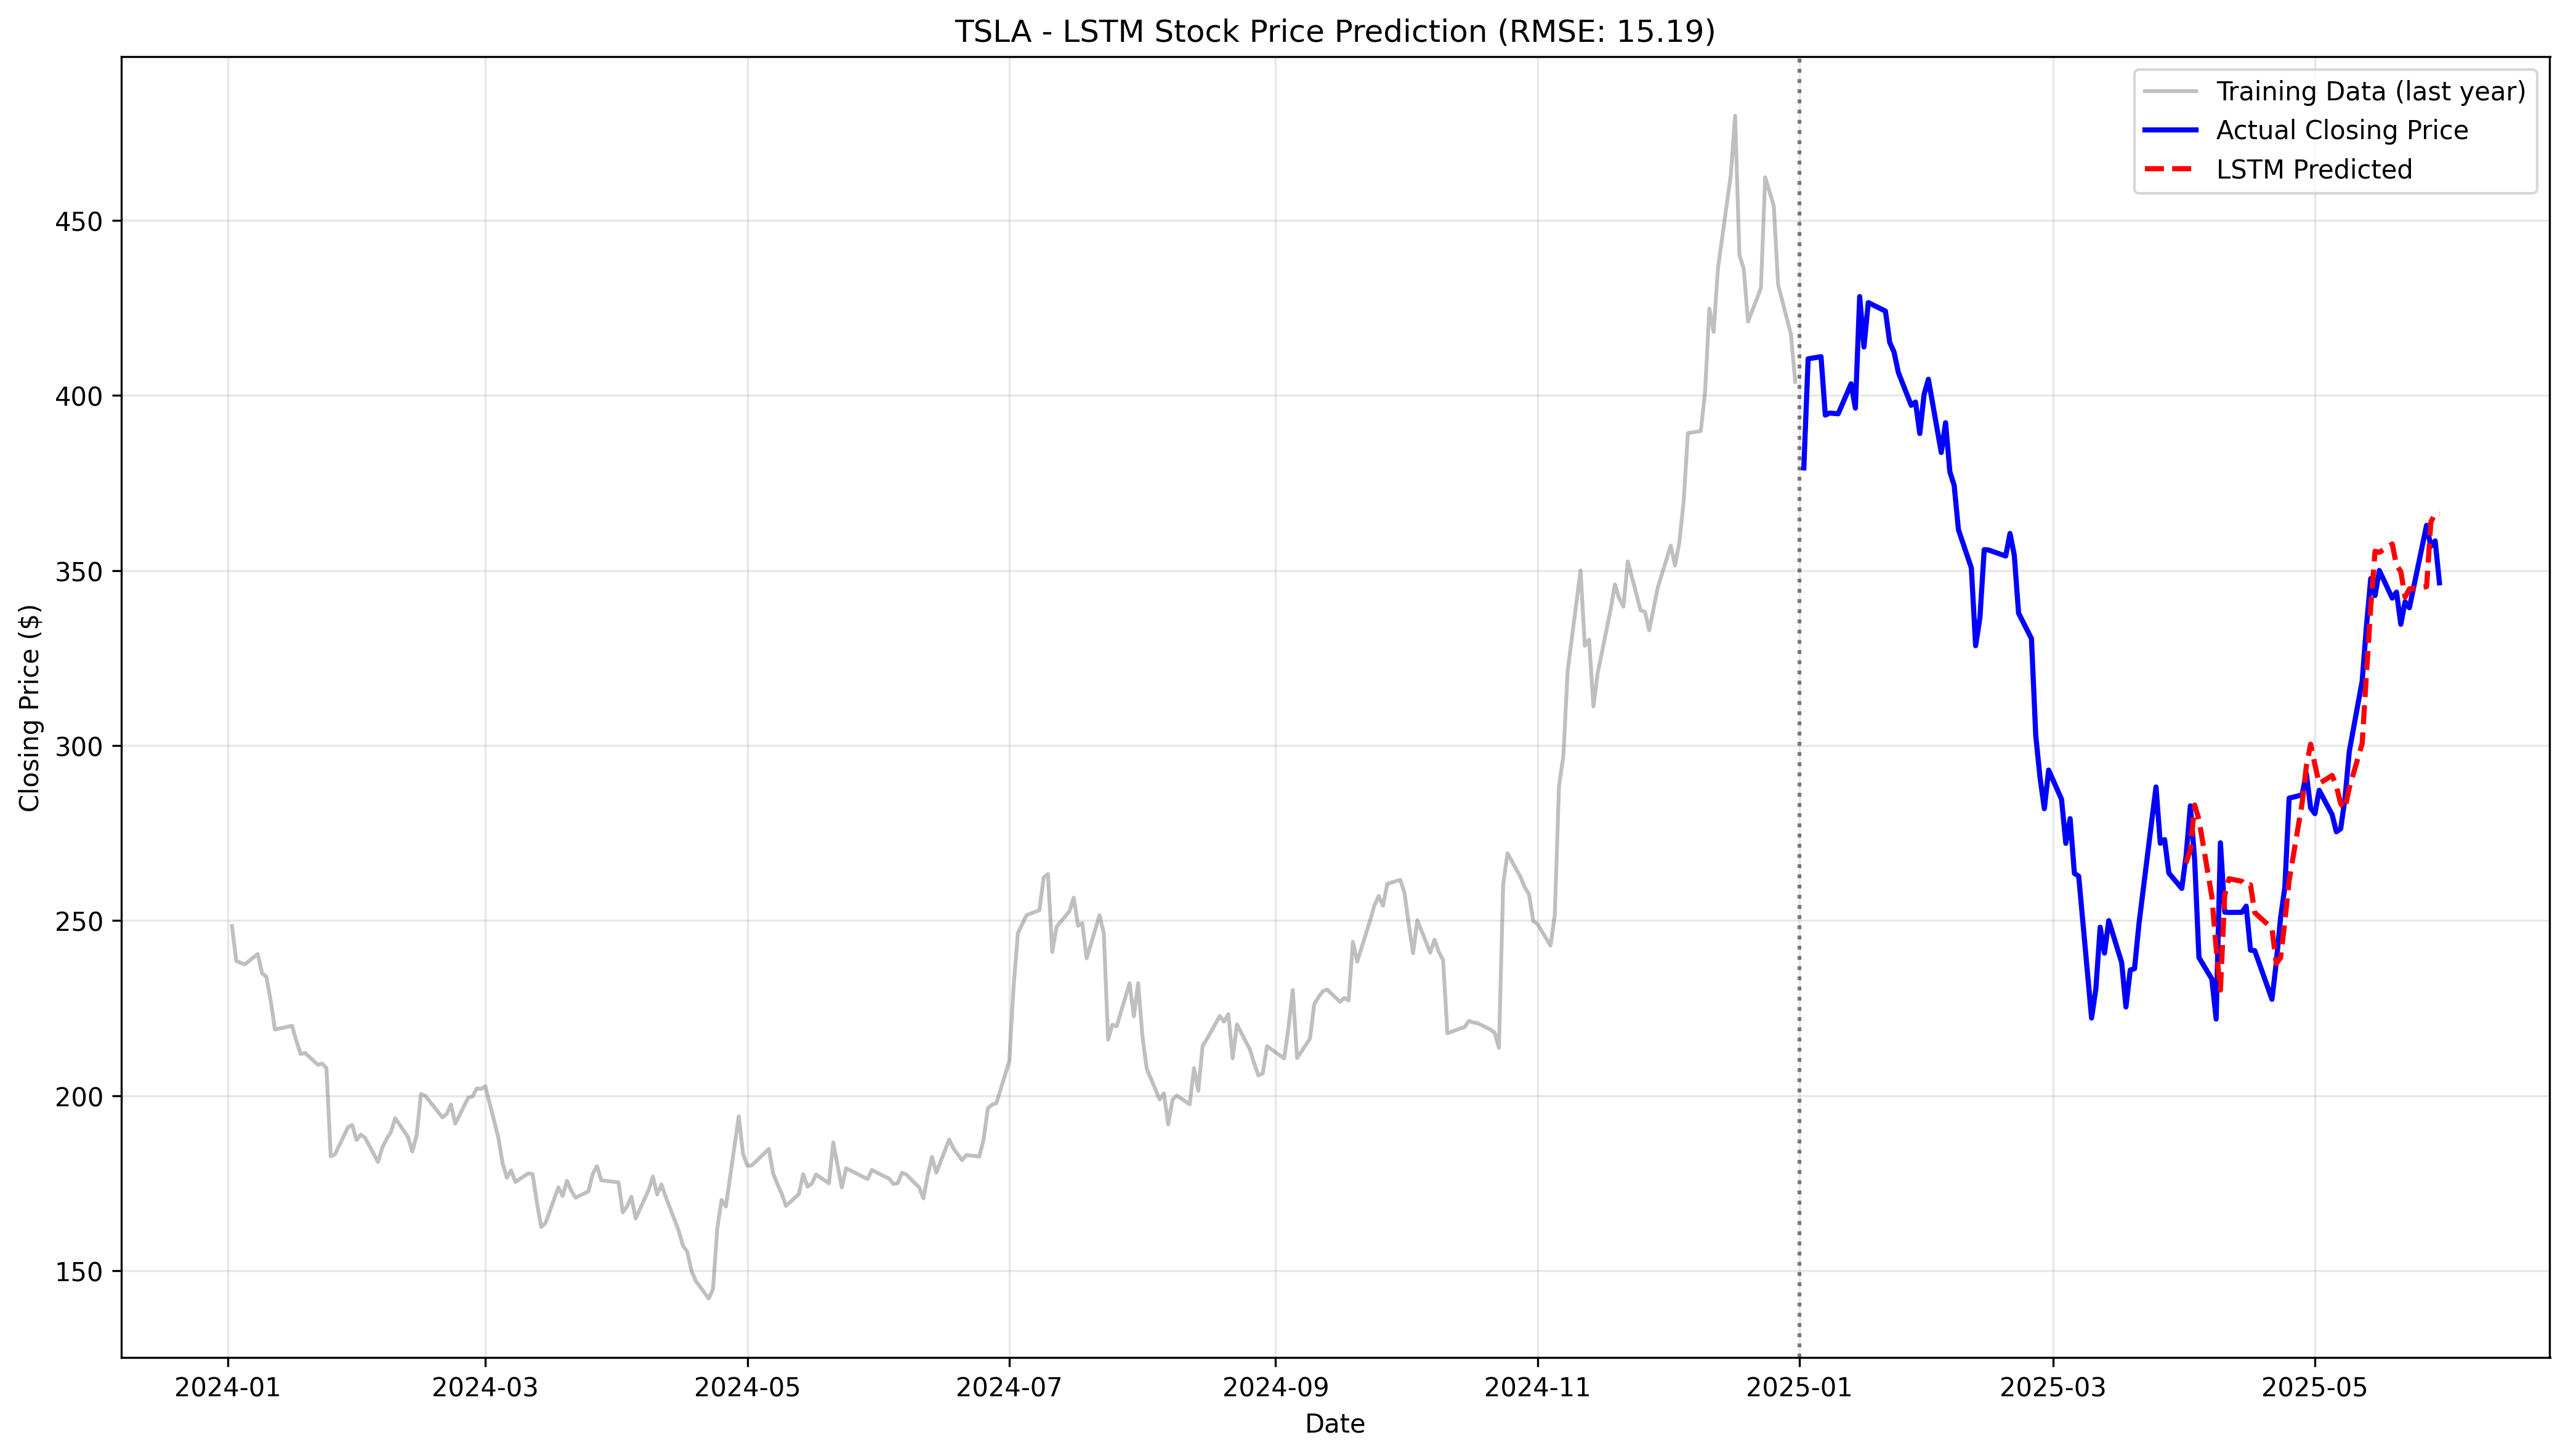

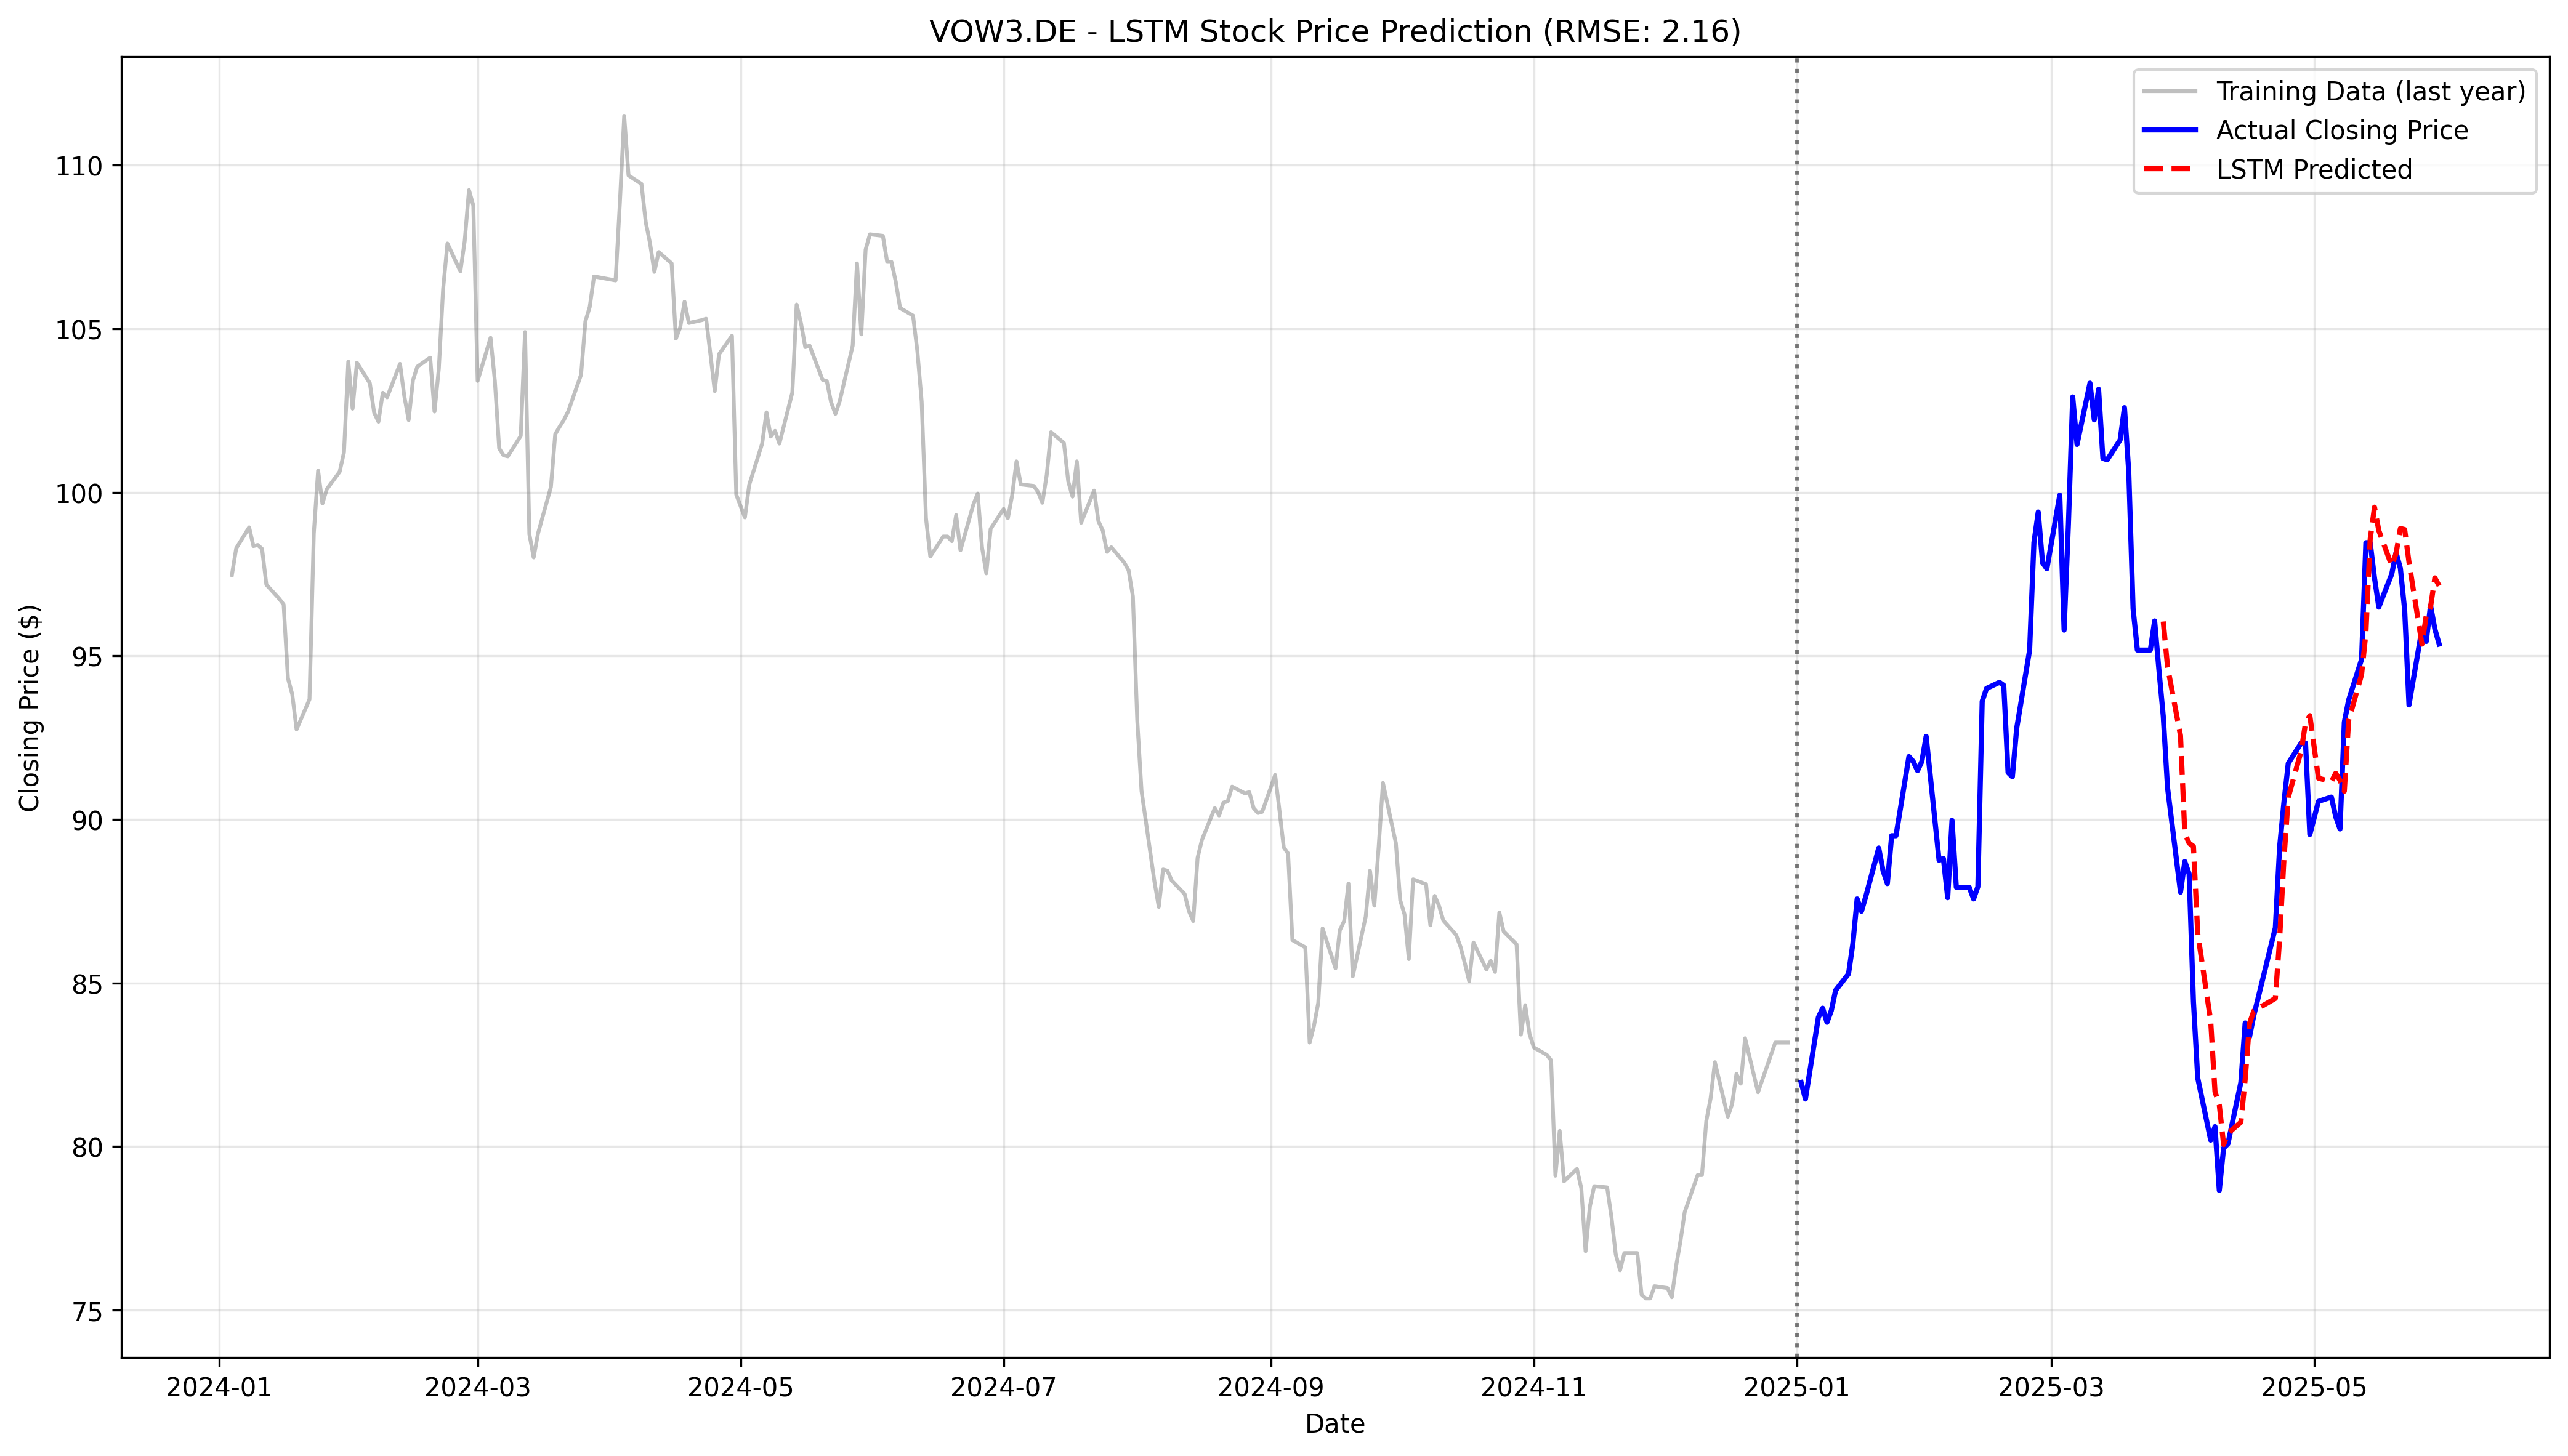

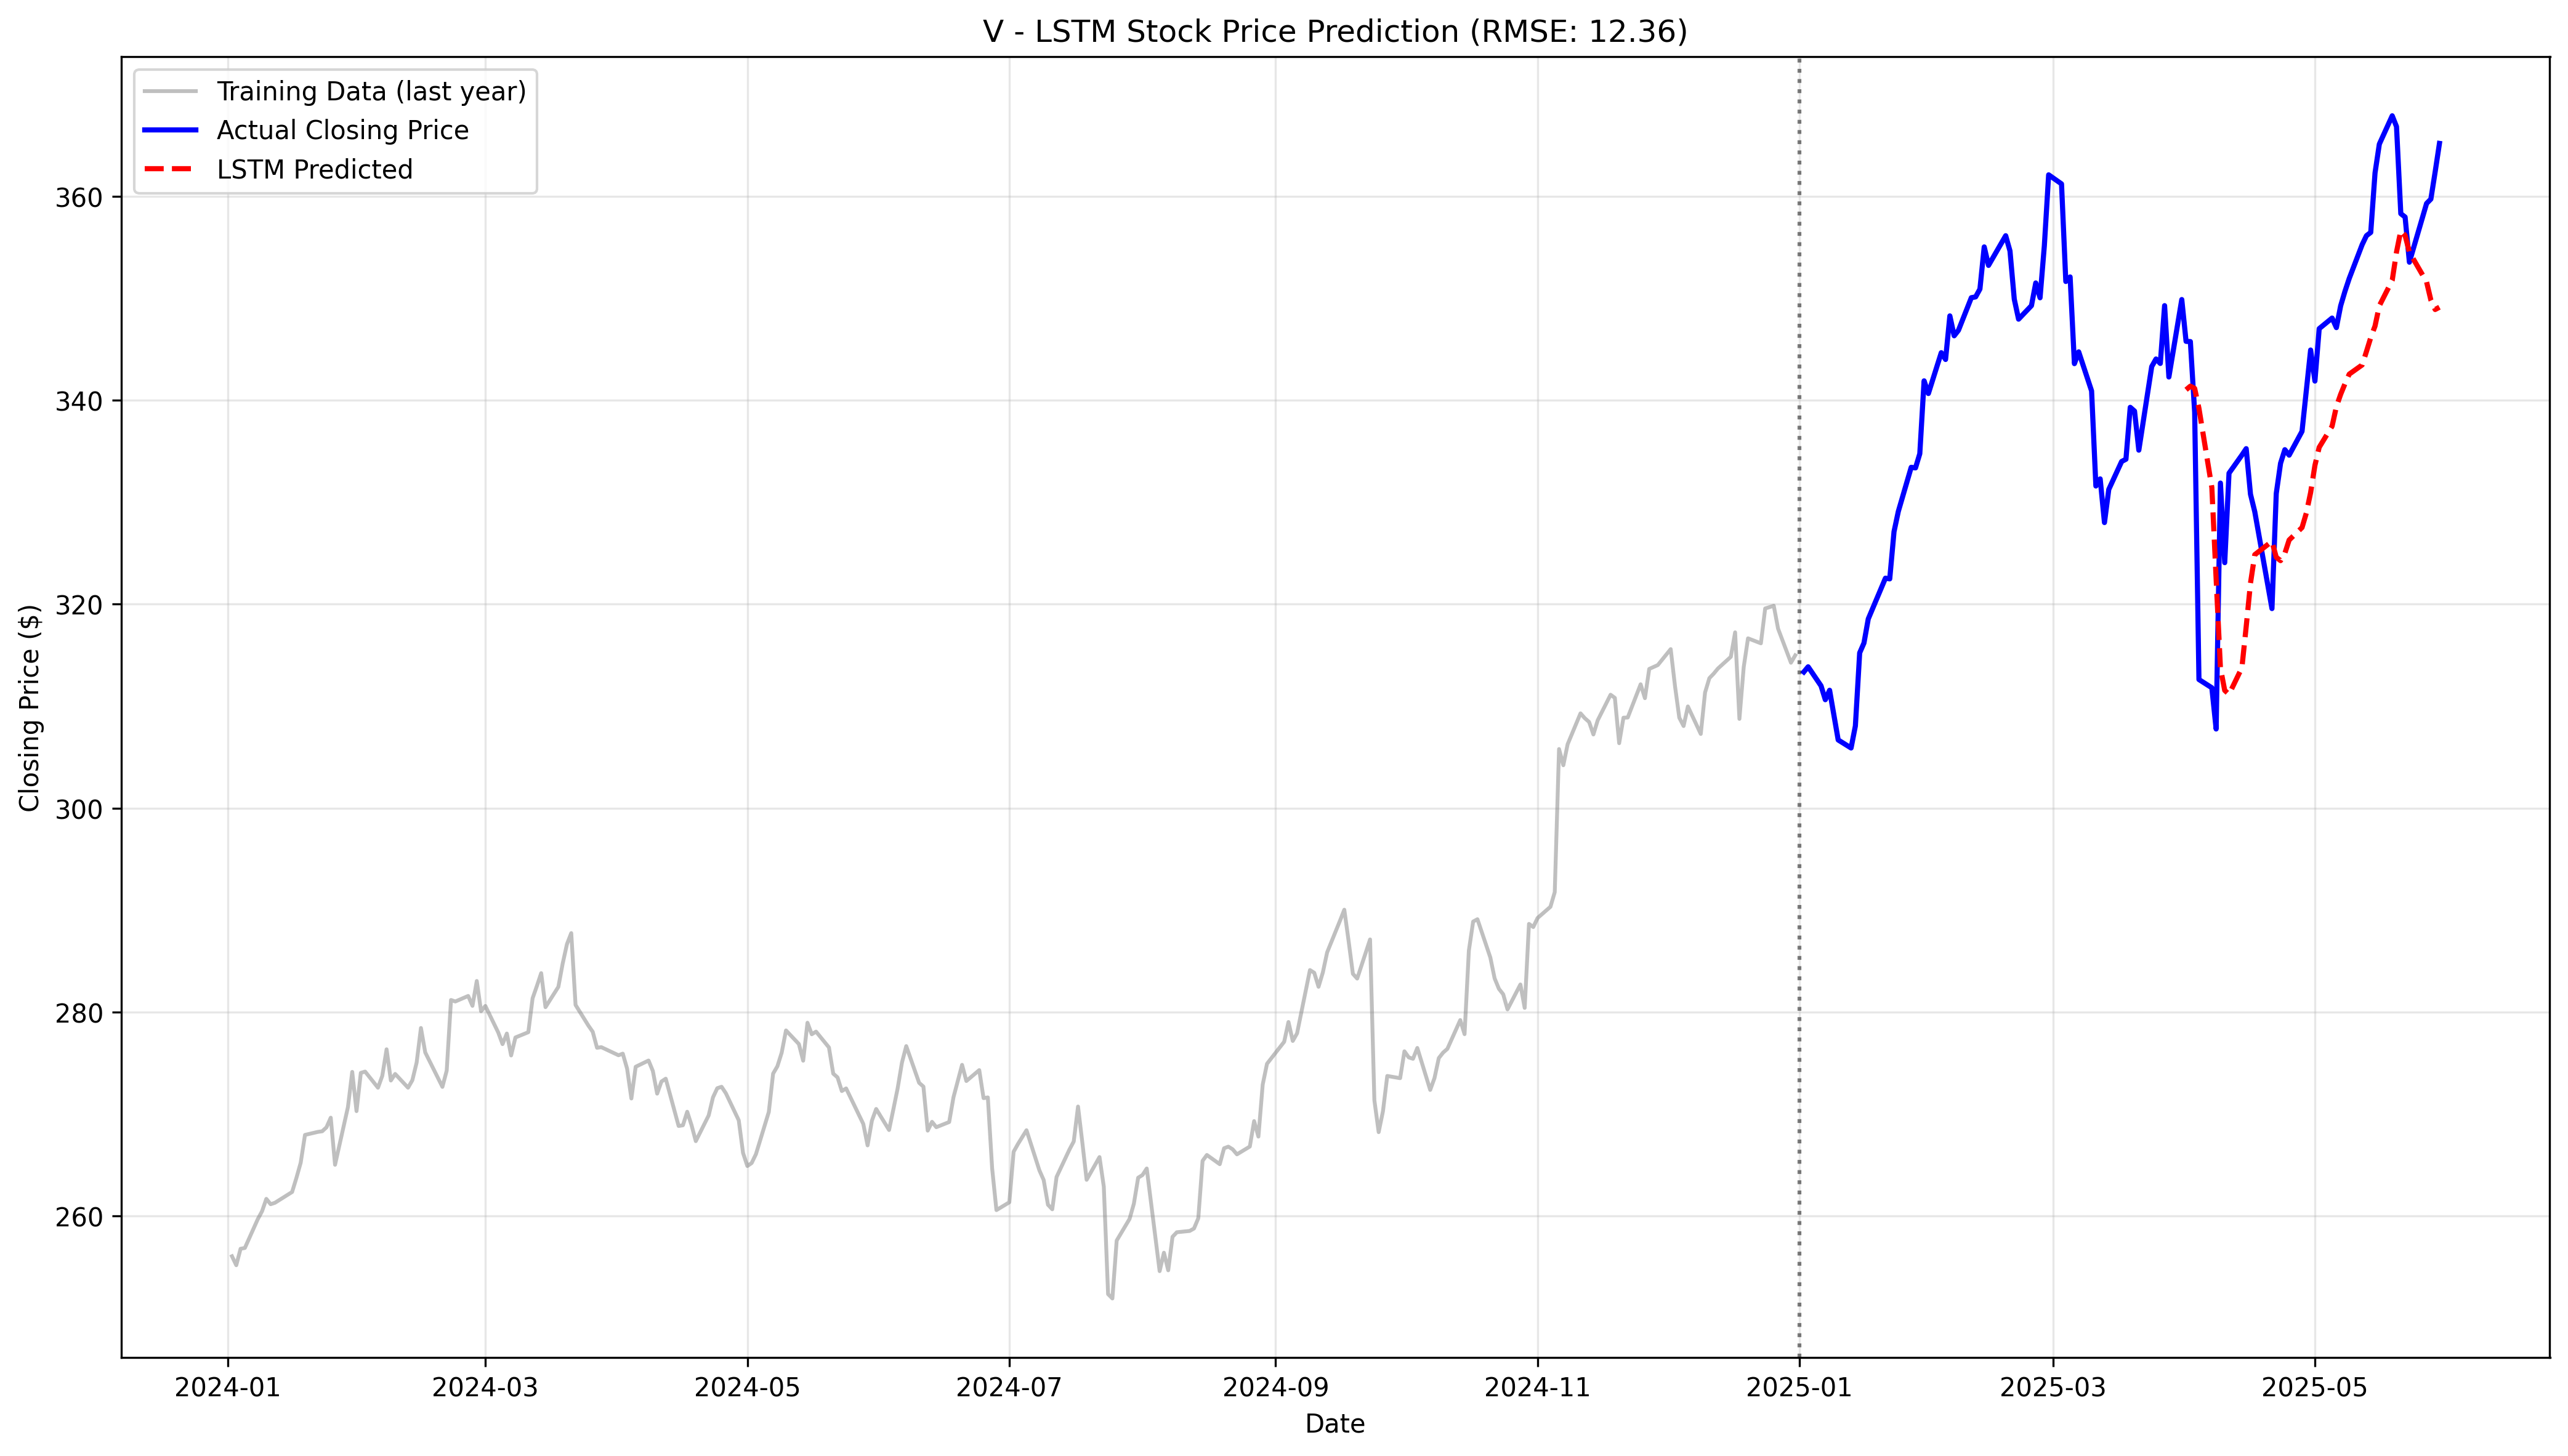

In [1]:

# Train LSTM model for each stock
print("\nTraining LSTM models for each stock...")

for ticker, df_close in stock_data.items():
    print(f"\nProcessing {ticker}...")

    try:
        # Ensure the index is a DatetimeIndex
        df_close.index = pd.to_datetime(df_close.index)

        # Split data into training and testing sets
        train_data = df_close[df_close.index <= train_end_date]
        test_data = df_close[(df_close.index >= test_start_date) & (df_close.index <= end_date)]

        print(f"  Train data points: {len(train_data)}")
        print(f"  Test data points: {len(test_data)}")

        if len(train_data) < 100 or len(test_data) < 10:
            print(f"  Skipping {ticker} due to insufficient data.")
            continue

        # Normalize the data
        scaler = MinMaxScaler(feature_range=(0, 1))

        # Ensure data is in the correct shape
        train_values = train_data.values.reshape(-1, 1)
        test_values = test_data.values.reshape(-1, 1)

        scaled_train_data = scaler.fit_transform(train_values)
        scaled_test_data = scaler.transform(test_values)

        print(f"  Scaled train shape: {scaled_train_data.shape}")
        print(f"  Scaled test shape: {scaled_test_data.shape}")

        # Create sequences for LSTM
        sequence_length = 60  # Number of past days to consider

        # Check if we have enough data for sequences
        if len(scaled_train_data) < sequence_length + 1:
            print(f"  Not enough training data for sequence length {sequence_length}. Skipping.")
            continue

        if len(scaled_test_data) < sequence_length + 1:
            print(f"  Not enough test data for sequence length {sequence_length}. Skipping.")
            continue

        X_train, y_train = create_sequences(scaled_train_data, sequence_length)
        X_test, y_test = create_sequences(scaled_test_data, sequence_length)

        print(f"  X_train shape before reshape: {X_train.shape}")
        print(f"  X_test shape before reshape: {X_test.shape}")

        # Reshape for LSTM input: [samples, timesteps, features]
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        print(f"  X_train shape after reshape: {X_train.shape}")
        print(f"  X_test shape after reshape: {X_test.shape}")

        # Build and train LSTM model
        print(f"  Training LSTM for {ticker}...")
        model_lstm = build_lstm_model(sequence_length)

        # Train with the same parameters as original
        history = model_lstm.fit(X_train, y_train, epochs=25, batch_size=32, verbose=0, validation_split=0.1)

        # Make predictions
        print(f"  Making predictions...")
        lstm_predictions_scaled = model_lstm.predict(X_test, verbose=0)
        lstm_forecast = scaler.inverse_transform(lstm_predictions_scaled)

        # Align LSTM predictions with test_data index
        # LSTM predictions will be shorter due to sequence length
        start_idx = sequence_length  # Skip the first 'sequence_length' days
        lstm_forecast_series = pd.Series(
            lstm_forecast.flatten(),
            index=test_data.index[start_idx:start_idx + len(lstm_forecast)]
        )

        # Calculate RMSE using aligned data
        actual_aligned = test_data.iloc[start_idx:start_idx + len(lstm_forecast)]
        rmse_lstm = np.sqrt(mean_squared_error(actual_aligned, lstm_forecast))

        # Store predictions and metrics
        lstm_predictions[ticker] = {
            'Actual': test_data,
            'Predicted': lstm_forecast_series,
            'Train_data': train_data,
            'RMSE': rmse_lstm,
            'History': history
        }
        lstm_metrics[ticker] = rmse_lstm

        print(f"  LSTM RMSE: {rmse_lstm:.2f}")
        print(f"  Predictions generated: {len(lstm_forecast_series)}")

    except Exception as e:
        print(f"  LSTM model failed for {ticker}: {str(e)}")
        print(f"  Error type: {type(e).__name__}")
        import traceback
        traceback.print_exc()
        lstm_metrics[ticker] = float('inf')

print("\n--- LSTM Model Training Complete ---")

In [ ]:


# Generate visualization charts
print("\nGenerating LSTM prediction charts...")

for ticker, data_info in lstm_predictions.items():
    try:
        actual = data_info['Actual']
        predicted = data_info['Predicted']
        train_data = data_info['Train_data']
        rmse = data_info['RMSE']

        plt.figure(figsize=(14, 8))

        # Plot training data (last 252 days for clarity)
        train_display = train_data.iloc[-252:]  # Last year of training data
        plt.plot(train_display.index, train_display, label='Training Data (last year)', color='gray', alpha=0.5)

        # Plot actual vs predicted
        plt.plot(actual.index, actual, label='Actual Closing Price', color='blue', linewidth=2)
        plt.plot(predicted.index, predicted, label='LSTM Predicted', color='red', linestyle='--', linewidth=2)

        plt.title(f'{ticker} - LSTM Stock Price Prediction (RMSE: {rmse:.2f})')
        plt.xlabel('Date')
        plt.ylabel('Closing Price ($)')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Add vertical line to separate train/test
        plt.axvline(x=pd.to_datetime(test_start_date), color='black', linestyle=':', alpha=0.5, label='Train/Test Split')

        plt.tight_layout()
        chart_filename = f'{ticker}_lstm_prediction.png'
        plt.savefig(chart_filename, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Chart saved for {ticker} as {chart_filename}")

    except Exception as e:
        print(f"Error generating chart for {ticker}: {e}")

print("\n--- All LSTM Charts Generated ---")



In [ ]:
# Print summary of LSTM performance
print("\nLSTM Model Performance Summary:")
print("-" * 40)
print(f"{'Ticker':<10} {'RMSE':<10}")
print("-" * 40)
for ticker, rmse in lstm_metrics.items():
    if rmse != float('inf'):
        print(f"{ticker:<10} {rmse:<10.2f}")
    else:
        print(f"{ticker:<10} {'FAILED':<10}")



In [ ]:
# Find best and worst performing stocks
valid_metrics = {k: v for k, v in lstm_metrics.items() if v != float('inf')}
if valid_metrics:
    best_stock = min(valid_metrics, key=valid_metrics.get)
    worst_stock = max(valid_metrics, key=valid_metrics.get)
    print(f"\nBest performing prediction: {best_stock} (RMSE: {valid_metrics[best_stock]:.2f})")
    print(f"Worst performing prediction: {worst_stock} (RMSE: {valid_metrics[worst_stock]:.2f})")

    # Calculate average RMSE
    avg_rmse = np.mean(list(valid_metrics.values()))
    print(f"Average RMSE across all successful predictions: {avg_rmse:.2f}")

# Optional: Display charts if running in Jupyter/Colab
try:
    from IPython.display import Image, display
    print("\nDisplaying generated charts...")
    for ticker in lstm_predictions.keys():
        filename = f'{ticker}_lstm_prediction.png'
        try:
            display(Image(filename=filename))
        except Exception as e:
            print(f"Could not display {filename}: {e}")
except ImportError:
    print("\nNote: Run this in Jupyter/Colab to display charts inline")